## Imports

In [1]:
import numpy as np
from jax.config import config; config.update("jax_enable_x64", True)
import jax.numpy as jnp
import networkx as nx
from qibo import matrices, optimizers
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

## MAXcut and Weighted MAXcut Hamiltonians

In [2]:
def maxcut(nqubits, norm=2, random_graph=False):
    """Builds maxcut hamiltonian"""
    if random_graph:
        aa = np.random.randint(1, nqubits*(nqubits-1)/2+1)
        graph = nx.random_graphs.dense_gnm_random_graph(nqubits, aa)
        V = nx.adjacency_matrix(graph).toarray()

    ham = jnp.zeros(shape=(2**nqubits,2**nqubits), dtype=np.float64)
    z = jnp.array([[1,0],[0,-1]], dtype=np.float64)
    iden = jnp.array([[1,0],[0,1]], dtype=np.float64)
    for i in range(nqubits):
        for j in range(nqubits):
            h = jnp.eye(1)
            for k in range(nqubits):
                if (k == i) ^ (k == j):
                    h = jnp.kron(h, z)
                else:
                    h = jnp.kron(h, iden)            
            M = jnp.eye(2**nqubits) - h
            if random_graph:
                ham += V[i,j] * M
            else:
                ham += M
    return - 1/norm * ham    


def weighted_maxcut(nqubits, norm=2, random_graph=False):
    """Builds maxcut hamiltonian"""
    weights = jnp.array([[0.5488135 , 0.71518937, 0.60276338, 0.54488318, 0.4236548 ],
                         [0.64589411, 0.43758721, 0.891773  , 0.96366276, 0.38344152],
                         [0.79172504, 0.52889492, 0.56804456, 0.92559664, 0.07103606],
                         [0.0871293 , 0.0202184 , 0.83261985, 0.77815675, 0.87001215],
                         [0.97861834, 0.79915856, 0.46147936, 0.78052918, 0.11827443]], 
                        dtype=np.float64)
    if random_graph:
        aa = np.random.randint(1, nqubits*(nqubits-1)/2+1)
        graph = nx.random_graphs.dense_gnm_random_graph(nqubits, aa)
        V = nx.adjacency_matrix(graph).toarray()

    ham = jnp.zeros(shape=(2**nqubits,2**nqubits), dtype=np.float64)
    z = jnp.array([[1,0],[0,-1]], dtype=np.float64)
    iden = jnp.array([[1,0],[0,1]], dtype=np.float64)
    for i in range(nqubits):
        for j in range(nqubits):
            h = jnp.eye(1)
            for k in range(nqubits):
                if (k == i) ^ (k == j):
                    h = jnp.kron(h, z)
                else:
                    h = jnp.kron(h, iden)            
            M = jnp.eye(2**nqubits) - h
            if random_graph:
                ham += V[i,j] * weights[i,j] * M
            else:
                ham += M * weights[i,j]
    return - 1/norm * ham    

## Optimization class

In [5]:
def Qu(beta, eps=1e-3, deltal=1):
    return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


class FragmentedQuITE:
    
    def __init__(self, nqubits, hamiltonian, query, eps=1e-3):
        """Test function for optimization."""
        self.n = nqubits
        energy = jnp.linalg.eigvalsh(hamiltonian)
        self.E = energy/((np.max(energy)-np.min(energy))/2)
        self.Emin = np.min(self.E)
        self.query = query
        self.eps = eps

    def minimize(self, schedule, r, b, initial_parameters=None, method='BFGS', options=None):
        """Optimizes scheduling function."""
        from scipy.optimize import minimize
        
        # imposes differences to be positive
        def derivative(p):
            return np.diff([schedule(step/r, p) for step in range(1, r+1)])
        
        con1 = {'type': 'ineq', 'fun': derivative}
        m = minimize(lambda p, _: self.compute_query(p, schedule, r, b),
                        initial_parameters, 
                        method, options=options, constraints=con1)
        if m.success == False or m.fun < 0:
            return np.nan, m.x
        return m.fun, m.x        
        
    def compute_query(self, params, schedule, r, b):
        """Compute query optimization."""
        beta = np.array([ b * schedule(step/r, params) for step in range(1, r+1)])
        
        # k == 0
        PsucBr = self.Psuc(beta[r-1])
        eps_prime = self.eps / (2 * 4.0**(r-1)) * np.sqrt(PsucBr)
        Sigma = self.query(beta[0]-0, eps=eps_prime, deltal=1)

        # k > 0
        DeltaBeta = np.diff(beta)
        for k in range(r-1):
            PsucBk = self.Psuc(beta[k+1])
            eps_prime = self.eps / 4.0**(r-(k+1)) * np.sqrt(PsucBr/PsucBk)
            Sigma += PsucBk * self.query(DeltaBeta[k], eps=eps_prime, deltal=1)
        
        Psbeta = self.Psuc(beta[r-1])        
        return 1/Psbeta * Sigma

    def Psuc(self, beta):
        Z = np.sum(np.exp(-beta * self.E))
        Zt =  Z * np.exp(beta * self.Emin)
        N = 2**self.n        
        return Zt / N
    
    def Qfrac_linear(self, r, b):
        """Return linear query prediction."""
        return self.compute_query(params=None, schedule=lambda t, _: t, r=r, b=b)
    
    def Q(self, beta, alpha=1):        
        Psbeta = self.Psuc(beta)
        bquery = self.query(beta=beta**alpha, eps=self.eps / 2 * np.sqrt(Psbeta), deltal=1)
        return 1/Psbeta * bquery
    
    def Qampl(self, beta, alpha=1):
        Psbeta = self.Psuc(beta)                
        return 1/np.sqrt(Psbeta) * self.query(beta=beta**alpha, eps=self.eps / 2 * np.sqrt(Psbeta), deltal=1)

## Example

In [4]:
ntrials = 10

# setup
r = 10
beta = 14
npol = 5

qref = []
qopt = []
qampl = []
qc = []
parameters = []

def myschedule(t, params):
    f = sum(p * t ** (i + 2) for i, p in enumerate(params))
    f += (1 - np.sum(params)) * t
    return f

for nqubits in range(2, 10):
    print('nqubits', nqubits)
    qref.append(np.zeros(ntrials))
    qopt.append(np.zeros(ntrials))
    qampl.append(np.zeros(ntrials))
    qc.append(np.zeros(ntrials))    
    parameters.append(np.zeros(shape=(ntrials,npol-1)))
    for nt in range(ntrials):
        model = FragmentedQuITE(nqubits, maxcut(nqubits, norm=40.0, random_graph=True), Qu)
        reference = model.reference_query(r, beta)
        a_ref, qampl_reference = model.reference_query_no_fragmentation(beta)
        
        initial_guess = np.zeros(npol-1)
        initial_guess[0] = 0.1
        result, params = model.minimize(myschedule, initial_parameters=initial_guess, 
                                        r=r, b=beta,
                                        method='COBYLA', options={'maxiter':50000})
        qref[nqubits-2][nt] = reference        
        qopt[nqubits-2][nt] = result
        qampl[nqubits-2][nt] = qampl_reference
        parameters[nqubits-2][nt] = params
        qc[nqubits-2][nt] = a_ref

nqubits 2


<ipython-input-3-7a2820d156f4>:2: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


nqubits 3
nqubits 4
nqubits 5
nqubits 6
nqubits 7
nqubits 8
nqubits 9


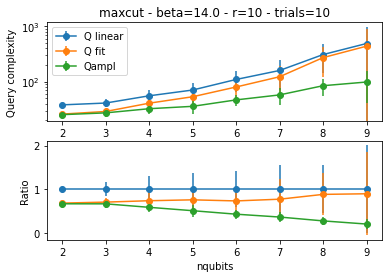

In [5]:
fig, axs = plt.subplots(2)
axs[0].set_title('maxcut - beta=%.1f - r=%d - trials=%d' % (beta, r, ntrials))
axs[0].errorbar(range(2,10), np.mean(qref, axis=1), 
             yerr=np.std(qref, axis=1), marker='o', label='Q linear')
axs[0].errorbar(range(2,10), np.nanmean(qopt, axis=1), 
             yerr=np.nanstd(qopt, axis=1), marker='o', label='Q fit')
axs[0].errorbar(range(2,10), np.nanmean(qampl, axis=1), 
             yerr=np.nanstd(qampl, axis=1), marker='o', label='Qampl')
axs[0].set_yscale('log')
axs[0].legend();
axs[0].set_ylabel('Query complexity')
axs[1].errorbar(range(2,10), np.mean(qref, axis=1)/np.mean(qref, axis=1), 
             yerr=np.std(qref, axis=1)/np.mean(qref, axis=1), marker='o')
axs[1].errorbar(range(2,10), np.nanmean(qopt, axis=1)/np.mean(qref, axis=1), 
             yerr=np.nanstd(qopt, axis=1)/np.mean(qref, axis=1), marker='o')
axs[1].errorbar(range(2,10), np.nanmean(qampl, axis=1)/np.mean(qref, axis=1), 
             yerr=np.nanstd(qampl, axis=1)/np.mean(qref, axis=1), marker='o')
axs[1].set_xlabel('nqubits')
axs[1].set_ylabel('Ratio');
plt.savefig('avg_maxcut_beta%d_r%d_pol5.png' % (beta, r), bbox_inches='tight')

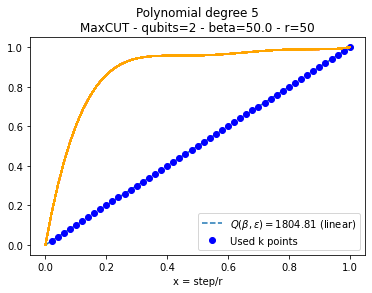

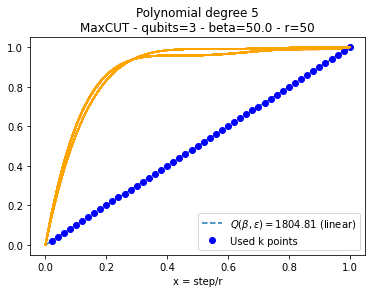

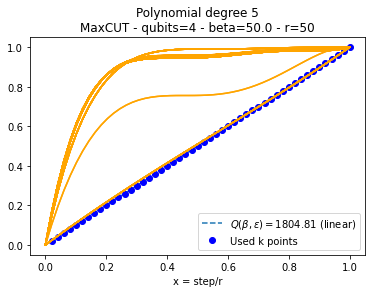

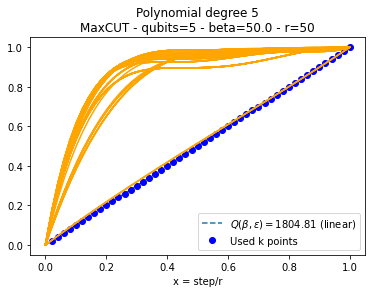

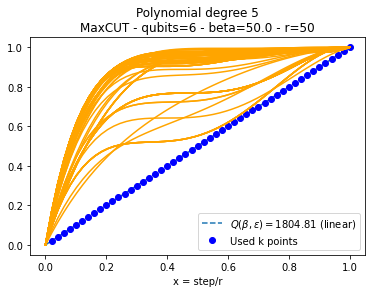

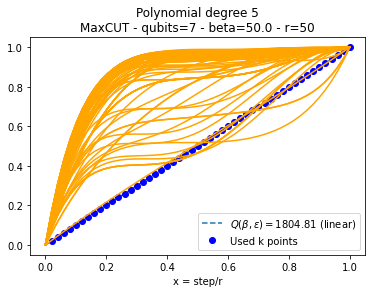

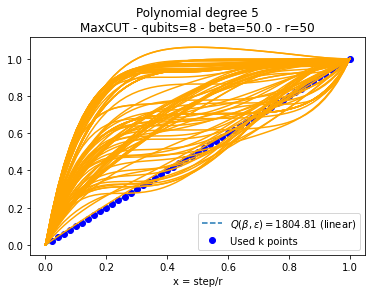

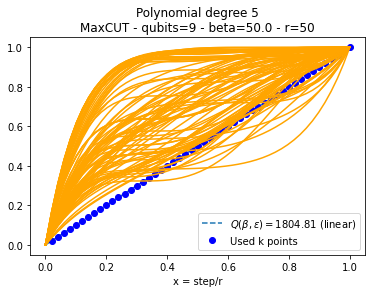

In [48]:
# plot
x = np.linspace(0,1,50)
xr = np.array(range(1,r+1))/r
for nqubits in range(2, 10):
    plt.figure()
    plt.title('Polynomial degree %d\nMaxCUT - qubits=%d - beta=%.1f - r=%d' % (len(initial_guess)+1,nqubits, beta, r))
    plt.plot(x, [i for i in x], '--', label=r'$Q(\beta,\epsilon)=%.2f$ (linear)' % reference);
    plt.plot(xr, xr, 'o', color='blue', label='Used k points')
    for j in range(parameters[nqubits-2].shape[0]):
        plt.plot(x, [myschedule(i, parameters[nqubits-2][j]) for i in x], color='orange');
        #plt.plot(xr,[myschedule(ixr, parameters[nqubits-2][j]) for ixr in xr], 'o', color='orange')
    plt.xlabel('x = step/r')
    plt.legend();

## Example 5 - Average vs beta

In [27]:
# setup
ntrials = 100
nqubits = 5
npol = 2

qref = []
qopt = []
qampl = []
qc = []
parameters = []

def myschedule(t, params):
    f = sum(p * t ** (i + 2) for i, p in enumerate(params))
    f += (1 - np.sum(params)) * t
    return f

r_range = range(1, 15) 
beta_max = 150
alpha_c = 0.5
alpha_ampl = 0.7
beta_range = range(2, beta_max+1, 5)
qref = np.zeros(shape=(len(beta_range),ntrials))
qampl = np.zeros(shape=(len(beta_range),ntrials))
qampl_alpha = np.zeros(shape=(len(beta_range),ntrials))
qc = np.zeros(shape=(len(beta_range),ntrials))
qc_alpha = np.zeros(shape=(len(beta_range),ntrials))
bestr = np.zeros(shape=(len(beta_range), ntrials))
qopt = np.zeros(shape=(len(beta_range),ntrials))
parameters = np.zeros(shape=(len(beta_range), ntrials, npol-1))


for nt in range(ntrials):
    print(f'trial={nt}')
    model = FragmentedQuITE(nqubits, weighted_maxcut(nqubits, norm=40.0, 
                            random_graph=True), Qu)
    
    for ii, beta in enumerate(beta_range):
        qampl[ii][nt] =  model.Qampl(beta)
        qampl_alpha[ii][nt] = model.Qampl(beta, alpha=alpha_ampl)
        qc[ii][nt] = model.Q(beta)
        qc_alpha[ii][nt] = model.Q(beta, alpha=alpha_c)
        
        values = []
        for r in r_range:           
            reference = model.Qfrac_linear(r, beta)
            values.append(reference)
            print(f' beta={beta}, r={r}, reference={reference}')
        
        qref[ii][nt] = np.min(values)
        bestr[ii][nt] = r_range[np.argmin(values)]
        
        initial_guess = np.zeros(npol-1)
        initial_guess[0] = 0
        result, params = model.minimize(myschedule, initial_parameters=initial_guess, 
                                        r=r_range[np.argmin(values)], b=beta,
                                        method='COBYLA', options={'maxiter': 50000})
        if result > np.min(values):
            result = np.nan
        qopt[ii][nt] = result
        parameters[ii][nt] = params

trial=0
 beta=2, r=1, reference=18.49331713635751
 beta=2, r=2, reference=19.050922469911956
 beta=2, r=3, reference=22.508203223024008
 beta=2, r=4, reference=26.861971225237134
 beta=2, r=5, reference=31.72010301662778
 beta=2, r=6, reference=36.96158280161806
 beta=2, r=7, reference=42.53860532823864
 beta=2, r=8, reference=48.42862832080861
 beta=2, r=9, reference=54.619326642222326
 beta=2, r=10, reference=61.10301636457793
 beta=2, r=11, reference=67.87432852558885
 beta=2, r=12, reference=74.92914713582407
 beta=2, r=13, reference=82.26408801408445
 beta=2, r=14, reference=89.87622696943832
 beta=7, r=1, reference=85.27584423391342
 beta=7, r=2, reference=68.76612391991117
 beta=7, r=3, reference=68.31180404958435
 beta=7, r=4, reference=72.29589472302946
 beta=7, r=5, reference=78.3475644080402
 beta=7, r=6, reference=85.65761263223918
 beta=7, r=7, reference=93.87299174261054
 beta=7, r=8, reference=102.814859502708
 beta=7, r=9, reference=112.38259380287924
 beta=7, r=10, ref

<ipython-input-5-32f6031227e9>:2: RuntimeWarning: invalid value encountered in log
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-5-32f6031227e9>:53: RuntimeWarning: overflow encountered in exp
  Zt =  Z * np.exp(beta * self.Emin)
<ipython-input-5-32f6031227e9>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))
<ipython-input-5-32f6031227e9>:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


 beta=12, r=1, reference=159.5048813782662
 beta=12, r=2, reference=118.67234091826907
 beta=12, r=3, reference=110.98832069290039
 beta=12, r=4, reference=111.87381933278435
 beta=12, r=5, reference=116.45228128914493
 beta=12, r=6, reference=123.11483761205395
 beta=12, r=7, reference=131.17166460512215
 beta=12, r=8, reference=140.2749363841138
 beta=12, r=9, reference=150.22892258217462
 beta=12, r=10, reference=160.91429925565185
 beta=12, r=11, reference=172.25365498311535
 beta=12, r=12, reference=184.19415707772492
 beta=12, r=13, reference=196.69817082051514
 beta=12, r=14, reference=209.73787758505046
 beta=17, r=1, reference=229.69362724727904
 beta=17, r=2, reference=163.13557347289742
 beta=17, r=3, reference=147.4391185953215
 beta=17, r=4, reference=144.63106722994348
 beta=17, r=5, reference=147.14390959730304
 beta=17, r=6, reference=152.50529579529672
 beta=17, r=7, reference=159.67642217798203
 beta=17, r=8, reference=168.1440066736842
 beta=17, r=9, reference=177.62

 beta=82, r=1, reference=958.829850340432
 beta=82, r=2, reference=584.7803937114702
 beta=82, r=3, reference=470.53264178072027
 beta=82, r=4, reference=420.9825186638212
 beta=82, r=5, reference=397.131813504279
 beta=82, r=6, reference=386.02216347613734
 beta=82, r=7, reference=382.1353359863941
 beta=82, r=8, reference=382.73967980256583
 beta=82, r=9, reference=386.33845783073787
 beta=82, r=10, reference=392.0492392610164
 beta=82, r=11, reference=399.322050815787
 beta=82, r=12, reference=407.79876871364803
 beta=82, r=13, reference=417.23772084609345
 beta=82, r=14, reference=427.4708775259172
 beta=87, r=1, reference=1013.3003897673849
 beta=87, r=2, reference=615.6377845007735
 beta=87, r=3, reference=493.69425280155974
 beta=87, r=4, reference=440.45559665311964
 beta=87, r=5, reference=414.52526568764546
 beta=87, r=6, reference=402.1375173818226
 beta=87, r=7, reference=397.42510909154765
 beta=87, r=8, reference=397.4808692871422
 beta=87, r=9, reference=400.710324481410

trial=1
 beta=2, r=1, reference=33.11509306328735
 beta=2, r=2, reference=30.026135697355596
 beta=2, r=3, reference=33.39338512693024
 beta=2, r=4, reference=38.815751211308125
 beta=2, r=5, reference=45.30799860618245
 beta=2, r=6, reference=52.5377807768059
 beta=2, r=7, reference=60.36502791402425
 beta=2, r=8, reference=68.72086496151455
 beta=2, r=9, reference=77.5670963748749
 beta=2, r=10, reference=86.88030698437379
 beta=2, r=11, reference=96.64485571133096
 beta=2, r=12, reference=106.84949906090665
 beta=2, r=13, reference=117.48564226727699
 beta=2, r=14, reference=128.5463773818922
 beta=7, r=1, reference=214.88649568820833
 beta=7, r=2, reference=157.80466412877345
 beta=7, r=3, reference=143.4693476037656
 beta=7, r=4, reference=141.597352014703
 beta=7, r=5, reference=145.66350967835825
 beta=7, r=6, reference=153.29325625953783
 beta=7, r=7, reference=163.38135195633652
 beta=7, r=8, reference=175.3343231714681
 beta=7, r=9, reference=188.80188811115212
 beta=7, r=10,

 beta=72, r=1, reference=1704.901174509319
 beta=72, r=2, reference=993.9966323601724
 beta=72, r=3, reference=770.8526043486285
 beta=72, r=4, reference=668.5565608791458
 beta=72, r=5, reference=613.8708038406751
 beta=72, r=6, reference=582.5364060413447
 beta=72, r=7, reference=564.2836483640195
 beta=72, r=8, reference=554.0708055292907
 beta=72, r=9, reference=549.1611563774571
 beta=72, r=10, reference=547.9554364065577
 beta=72, r=11, reference=549.4637521084067
 beta=72, r=12, reference=553.0439593557329
 beta=72, r=13, reference=558.2627012330379
 beta=72, r=14, reference=564.8173980884729
 beta=77, r=1, reference=1813.919194979778
 beta=77, r=2, reference=1052.4675947884289
 beta=77, r=3, reference=812.8605668854279
 beta=77, r=4, reference=702.6655689953454
 beta=77, r=5, reference=643.5117811160092
 beta=77, r=6, reference=609.4111340078218
 beta=77, r=7, reference=589.3446105127832
 beta=77, r=8, reference=577.8935601643053
 beta=77, r=9, reference=572.1123720435593
 beta

 beta=142, r=1, reference=3229.3616396836032
 beta=142, r=2, reference=1808.305648306869
 beta=142, r=3, reference=1351.7593963587005
 beta=142, r=4, reference=1135.8269466981772
 beta=142, r=5, reference=1015.6704509519559
 beta=142, r=6, reference=943.005415077748
 beta=142, r=7, reference=897.1611779722441
 beta=142, r=8, reference=867.837242180775
 beta=142, r=9, reference=849.3486872959519
 beta=142, r=10, reference=838.3197394248842
 beta=142, r=11, reference=832.632600979661
 beta=142, r=12, reference=830.9004176549673
 beta=142, r=13, reference=832.1829260243935
 beta=142, r=14, reference=835.8239134637756
 beta=147, r=1, reference=3338.1726271823245
 beta=147, r=2, reference=1866.2766857970873
 beta=147, r=3, reference=1392.9174868485497
 beta=147, r=4, reference=1168.7118845797174
 beta=147, r=5, reference=1043.7192908120178
 beta=147, r=6, reference=967.9488060013638
 beta=147, r=7, reference=919.9936509699218
 beta=147, r=8, reference=889.1815142918715
 beta=147, r=9, refer

 beta=62, r=1, reference=1486.734046555896
 beta=62, r=2, reference=876.7525317568565
 beta=62, r=3, reference=686.3480063980074
 beta=62, r=4, reference=599.6694670878375
 beta=62, r=5, reference=553.7609933802918
 beta=62, r=6, reference=527.8327065422133
 beta=62, r=7, reference=513.1204660931375
 beta=62, r=8, reference=505.33967920458394
 beta=62, r=9, reference=502.1714118487776
 beta=62, r=10, reference=502.2616485194625
 beta=62, r=11, reference=504.77092335856867
 beta=62, r=12, reference=509.1525049236334
 beta=62, r=13, reference=515.0352489624523
 beta=62, r=14, reference=522.1581410351872
 beta=67, r=1, reference=1595.8425631373477
 beta=67, r=2, reference=935.4316487460212
 beta=67, r=3, reference=728.6917738349541
 beta=67, r=4, reference=634.2362363792533
 beta=67, r=5, reference=583.9639885802117
 beta=67, r=6, reference=555.3493071460972
 beta=67, r=7, reference=538.8771712799133
 beta=67, r=8, reference=529.887910821134
 beta=67, r=9, reference=525.857191892783
 beta

 beta=132, r=1, reference=3011.7220337327594
 beta=132, r=2, reference=1692.319193659632
 beta=132, r=3, reference=1269.3642982984536
 beta=132, r=4, reference=1069.9379484087933
 beta=132, r=5, reference=959.4101882276684
 beta=132, r=6, reference=892.9115688891538
 beta=132, r=7, reference=851.245385604837
 beta=132, r=8, reference=824.8559126181855
 beta=132, r=9, reference=808.477407438991
 beta=132, r=10, reference=798.989095554978
 beta=132, r=11, reference=794.4375019111403
 beta=132, r=12, reference=793.5463490548319
 beta=132, r=13, reference=795.4522713640282
 beta=132, r=14, reference=799.5538993862411
 beta=137, r=1, reference=3120.5449841458267
 beta=137, r=2, reference=1750.3203267282884
 beta=137, r=3, reference=1310.5758720541776
 beta=137, r=4, reference=1102.9035632848386
 beta=137, r=5, reference=987.5690554307273
 beta=137, r=6, reference=917.9949243695376
 beta=137, r=7, reference=874.2470268505981
 beta=137, r=8, reference=846.3968111848674
 beta=137, r=9, referen

 beta=52, r=1, reference=631.6146656499476
 beta=52, r=2, reference=398.6689312922979
 beta=52, r=3, reference=329.9045647296121
 beta=52, r=4, reference=301.6849355766015
 beta=52, r=5, reference=289.37846259384753
 beta=52, r=6, reference=284.86937588079394
 beta=52, r=7, reference=284.7536609774594
 beta=52, r=8, reference=287.38000692551344
 beta=52, r=9, reference=291.8629910908824
 beta=52, r=10, reference=297.69061130630934
 beta=52, r=11, reference=304.5483352948279
 beta=52, r=12, reference=312.2329892008235
 beta=52, r=13, reference=320.60763351885294
 beta=52, r=14, reference=329.5765545629994
 beta=57, r=1, reference=686.2210757683164
 beta=57, r=2, reference=429.8562848544296
 beta=57, r=3, reference=353.6217926351994
 beta=57, r=4, reference=321.95213031585973
 beta=57, r=5, reference=307.80400070301533
 beta=57, r=6, reference=302.2422016658877
 beta=57, r=7, reference=301.50489534198533
 beta=57, r=8, reference=303.7608535852564
 beta=57, r=9, reference=308.026182569173

<ipython-input-5-32f6031227e9>:46: RuntimeWarning: overflow encountered in double_scalars
  Sigma += PsucBk * self.query(DeltaBeta[k], eps=eps_prime, deltal=1)


 beta=112, r=1, reference=1285.5155813035626
 beta=112, r=2, reference=769.5779822834004
 beta=112, r=3, reference=608.8958557380549
 beta=112, r=4, reference=536.9457316733278
 beta=112, r=5, reference=500.3628482167953
 beta=112, r=6, reference=481.3396233860522
 beta=112, r=7, reference=472.2464585606806
 beta=112, r=8, reference=469.280798273437
 beta=112, r=9, reference=470.34583394796414
 beta=112, r=10, reference=474.1992248554996
 beta=112, r=11, reference=480.06452417435406
 beta=112, r=12, reference=487.4360262273317
 beta=112, r=13, reference=495.9733017687875
 beta=112, r=14, reference=505.4408328970662
 beta=117, r=1, reference=1339.9392951181508
 beta=117, r=2, reference=800.3162064609998
 beta=117, r=3, reference=631.8471963905836
 beta=117, r=4, reference=556.1135212131383
 beta=117, r=5, reference=517.3668296038998
 beta=117, r=6, reference=497.0004278614955
 beta=117, r=7, reference=487.0383879128856
 beta=117, r=8, reference=483.5020748187855
 beta=117, r=9, referenc

<ipython-input-5-32f6031227e9>:53: RuntimeWarning: overflow encountered in double_scalars
  Zt =  Z * np.exp(beta * self.Emin)


 beta=132, r=1, reference=1503.1847190582193
 beta=132, r=2, reference=892.4633398538658
 beta=132, r=3, reference=700.5777705043885
 beta=132, r=4, reference=613.4269297475048
 beta=132, r=5, reference=568.1157548486013
 beta=132, r=6, reference=543.6441049875607
 beta=132, r=7, reference=531.0003423575106
 beta=132, r=8, reference=525.6801120532737
 beta=132, r=9, reference=525.1889192850934
 beta=132, r=10, reference=528.0405336545189
 beta=132, r=11, reference=533.2999892320689
 beta=132, r=12, reference=540.3540219192931
 beta=132, r=13, reference=548.7868548843073
 beta=132, r=14, reference=558.3089137153893
 beta=137, r=1, reference=1557.5928133011055
 beta=137, r=2, reference=923.1604209431105
 beta=137, r=3, reference=723.4536591845207
 beta=137, r=4, reference=632.4782057720411
 beta=137, r=5, reference=584.9578337093058
 beta=137, r=6, reference=559.0956601445934
 beta=137, r=7, reference=545.5357512048355
 beta=137, r=8, reference=539.5992597952219
 beta=137, r=9, reference

 beta=52, r=1, reference=725.8032572607888
 beta=52, r=2, reference=451.90723211081
 beta=52, r=3, reference=377.6240907787545
 beta=52, r=4, reference=351.387668537287
 beta=52, r=5, reference=343.7070510688472
 beta=52, r=6, reference=345.0426556474333
 beta=52, r=7, reference=351.4382974910913
 beta=52, r=8, reference=360.98860099049654
 beta=52, r=9, reference=372.67950865441804
 beta=52, r=10, reference=385.9310788178541
 beta=52, r=11, reference=400.39282177014655
 beta=52, r=12, reference=415.84324614239966
 beta=52, r=13, reference=432.13700447509234
 beta=52, r=14, reference=449.17552609122384
 beta=57, r=1, reference=827.0119741309352
 beta=57, r=2, reference=508.81194980777605
 beta=57, r=3, reference=420.85020642208644
 beta=57, r=4, reference=388.49328848570684
 beta=57, r=5, reference=377.65314657412154
 beta=57, r=6, reference=377.27060964032256
 beta=57, r=7, reference=382.7449960104116
 beta=57, r=8, reference=391.8523375849108
 beta=57, r=9, reference=403.404172100141

 beta=122, r=1, reference=2352.7042726335276
 beta=122, r=2, reference=1341.1671211206856
 beta=122, r=3, reference=1030.3793185050333
 beta=122, r=4, reference=892.8259825941706
 beta=122, r=5, reference=823.5786650228821
 beta=122, r=6, reference=787.9676567986631
 beta=122, r=7, reference=771.2789895787804
 beta=122, r=8, reference=766.2374119400763
 beta=122, r=9, reference=768.8545918608908
 beta=122, r=10, reference=776.7756608541812
 beta=122, r=11, reference=788.5305671290392
 beta=122, r=12, reference=803.1611210808113
 beta=122, r=13, reference=820.0209267526365
 beta=122, r=14, reference=838.6615414001875
 beta=127, r=1, reference=2477.0512153098734
 beta=127, r=2, reference=1407.9509055787094
 beta=127, r=3, reference=1078.2540265381572
 beta=127, r=4, reference=931.526090620304
 beta=127, r=5, reference=857.002068693552
 beta=127, r=6, reference=818.0620225357816
 beta=127, r=7, reference=799.1541760173931
 beta=127, r=8, reference=792.5827136323727
 beta=127, r=9, referen

 beta=42, r=1, reference=259.869833631325
 beta=42, r=2, reference=184.88667047429914
 beta=42, r=3, reference=166.72853676500046
 beta=42, r=4, reference=162.5719886592131
 beta=42, r=5, reference=163.88895188126884
 beta=42, r=6, reference=167.8795894568128
 beta=42, r=7, reference=173.37976071957578
 beta=42, r=8, reference=179.83355937054355
 beta=42, r=9, reference=186.94994233365344
 beta=42, r=10, reference=194.56591050827527
 beta=42, r=11, reference=202.58518836537652
 beta=42, r=12, reference=210.9483365397881
 beta=42, r=13, reference=219.6172276793775
 beta=42, r=14, reference=228.56656096736538
 beta=47, r=1, reference=287.21571916044945
 beta=47, r=2, reference=202.31917624630555
 beta=47, r=3, reference=181.1325857126995
 beta=47, r=4, reference=175.70508187639405
 beta=47, r=5, reference=176.46274706041987
 beta=47, r=6, reference=180.24580129640967
 beta=47, r=7, reference=185.73048301159994
 beta=47, r=8, reference=192.27926533046067
 beta=47, r=9, reference=199.55578

 beta=112, r=1, reference=641.4257258896465
 beta=112, r=2, reference=425.5680050448108
 beta=112, r=3, reference=362.4443774342923
 beta=112, r=4, reference=337.7505692717929
 beta=112, r=5, reference=328.5430661520643
 beta=112, r=6, reference=327.1265447206666
 beta=112, r=7, reference=330.1779798672534
 beta=112, r=8, reference=336.0246033083495
 beta=112, r=9, reference=343.73386151713737
 beta=112, r=10, reference=352.7473335312766
 beta=112, r=11, reference=362.712881419449
 beta=112, r=12, reference=373.39977432556645
 beta=112, r=13, reference=384.6523946130944
 beta=112, r=14, reference=396.3634352851072
 beta=117, r=1, reference=668.6353637879971
 beta=117, r=2, reference=442.6377701861705
 beta=117, r=3, reference=376.19933319834144
 beta=117, r=4, reference=349.91929852125736
 beta=117, r=5, reference=339.83326419990595
 beta=117, r=6, reference=337.90330543234404
 beta=117, r=7, reference=340.6572355949879
 beta=117, r=8, reference=346.34568689108954
 beta=117, r=9, refer

 beta=32, r=1, reference=101.90901124781232
 beta=32, r=2, reference=88.85087964197828
 beta=32, r=3, reference=90.17281986312081
 beta=32, r=4, reference=94.97922636536325
 beta=32, r=5, reference=101.113640966958
 beta=32, r=6, reference=107.88680364045982
 beta=32, r=7, reference=115.02792435677966
 beta=32, r=8, reference=122.41943510258136
 beta=32, r=9, reference=130.0082037558057
 beta=32, r=10, reference=137.7704675364866
 beta=32, r=11, reference=145.69645838058256
 beta=32, r=12, reference=153.78318777614055
 beta=32, r=13, reference=162.03090822477927
 beta=32, r=14, reference=170.44133152640507
 beta=37, r=1, reference=115.62117364710029
 beta=37, r=2, reference=99.42318760118519
 beta=37, r=3, reference=99.97375579537415
 beta=37, r=4, reference=104.64276307986401
 beta=37, r=5, reference=110.90461549408175
 beta=37, r=6, reference=117.93574265481367
 beta=37, r=7, reference=125.40311446464295
 beta=37, r=8, reference=133.1566848847997
 beta=37, r=9, reference=141.12536729

 beta=102, r=1, reference=292.83474684975073
 beta=102, r=2, reference=233.70668887753646
 beta=102, r=3, reference=221.46732394396832
 beta=102, r=4, reference=221.3187088317307
 beta=102, r=5, reference=226.20954465161572
 beta=102, r=6, reference=233.73156281667428
 beta=102, r=7, reference=242.81803376682848
 beta=102, r=8, reference=252.91633162358028
 beta=102, r=9, reference=263.7099266643165
 beta=102, r=10, reference=275.0052928906872
 beta=102, r=11, reference=286.679050645832
 beta=102, r=12, reference=298.65050221430124
 beta=102, r=13, reference=310.86614423826853
 beta=102, r=14, reference=323.2903674343018
 beta=107, r=1, reference=306.4408971327
 beta=107, r=2, reference=243.95289091419585
 beta=107, r=3, reference=230.64539852207062
 beta=107, r=4, reference=230.022994022542
 beta=107, r=5, reference=234.69420055489744
 beta=107, r=6, reference=242.135654642086
 beta=107, r=7, reference=251.22930009142934
 beta=107, r=8, reference=261.3949625244079
 beta=107, r=9, refe

 beta=22, r=1, reference=301.80690632378906
 beta=22, r=2, reference=207.158659463504
 beta=22, r=3, reference=181.21372391566038
 beta=22, r=4, reference=172.22208448138437
 beta=22, r=5, reference=170.0474226473173
 beta=22, r=6, reference=171.3908797436711
 beta=22, r=7, reference=174.87125966908732
 beta=22, r=8, reference=179.81090345402282
 beta=22, r=9, reference=185.8377945576464
 beta=22, r=10, reference=192.72965475992962
 beta=22, r=11, reference=200.3445997976525
 beta=22, r=12, reference=208.58715006470422
 beta=22, r=13, reference=217.3902237692429
 beta=22, r=14, reference=226.7049697820034
 beta=27, r=1, reference=357.3570935164968
 beta=27, r=2, reference=240.09567743107485
 beta=27, r=3, reference=207.34350698258373
 beta=27, r=4, reference=195.33070157566522
 beta=27, r=5, reference=191.5404673124248
 beta=27, r=6, reference=191.90511456933592
 beta=27, r=7, reference=194.7286235680708
 beta=27, r=8, reference=199.1849598437381
 beta=27, r=9, reference=204.8253286705

 beta=92, r=1, reference=1067.75990904658
 beta=92, r=2, reference=646.4674655627986
 beta=92, r=3, reference=516.8065341473857
 beta=92, r=4, reference=459.84414603894004
 beta=92, r=5, reference=431.759966381433
 beta=92, r=6, reference=417.95220352716336
 beta=92, r=7, reference=412.18459693488285
 beta=92, r=8, reference=411.36515215126855
 beta=92, r=9, reference=413.8005930916013
 beta=92, r=10, reference=418.49539694245175
 beta=92, r=11, reference=424.8320371761221
 beta=92, r=12, reference=432.4108644088488
 beta=92, r=13, reference=440.96405664025195
 beta=92, r=14, reference=450.3067525051056
 beta=97, r=1, reference=1122.209765271684
 beta=97, r=2, reference=677.273244229495
 beta=97, r=3, reference=539.8791886451356
 beta=97, r=4, reference=479.1952190336047
 beta=97, r=5, reference=449.0130654271677
 beta=97, r=6, reference=433.9278940005598
 beta=97, r=7, reference=427.35392846569147
 beta=97, r=8, reference=426.0208591774206
 beta=97, r=9, reference=428.13431278816796
 

 beta=7, r=10, reference=132.04546590563243
 beta=7, r=11, reference=143.3555743066349
 beta=7, r=12, reference=155.23276809444448
 beta=7, r=13, reference=167.64965897776196
 beta=7, r=14, reference=180.58570272857654
 beta=12, r=1, reference=199.99097751442795
 beta=12, r=2, reference=145.20717550904888
 beta=12, r=3, reference=133.57094287605761
 beta=12, r=4, reference=132.78122277181873
 beta=12, r=5, reference=136.618312849299
 beta=12, r=6, reference=143.07088436535804
 beta=12, r=7, reference=151.2793297024131
 beta=12, r=8, reference=160.8052808645252
 beta=12, r=9, reference=171.3972232901771
 beta=12, r=10, reference=182.8984209814458
 beta=12, r=11, reference=195.2050339100722
 beta=12, r=12, reference=208.24489579996097
 beta=12, r=13, reference=221.96585587303431
 beta=12, r=14, reference=236.32896491671096
 beta=17, r=1, reference=314.1525760514377
 beta=17, r=2, reference=216.61546869179662
 beta=17, r=3, reference=192.33779877770786
 beta=17, r=4, reference=186.1523902

 beta=82, r=1, reference=1891.3938961094857
 beta=82, r=2, reference=1093.6515753412139
 beta=82, r=3, reference=844.3919837765008
 beta=82, r=4, reference=731.633224785803
 beta=82, r=5, reference=672.8523982760385
 beta=82, r=6, reference=640.6754789812586
 beta=82, r=7, reference=623.4868243869167
 beta=82, r=8, reference=615.5587375486363
 beta=82, r=9, reference=613.7635180356938
 beta=82, r=10, reference=616.2615057423403
 beta=82, r=11, reference=621.9071731814751
 beta=82, r=12, reference=629.9539966219603
 beta=82, r=13, reference=639.8969015781057
 beta=82, r=14, reference=651.3832215761897
 beta=87, r=1, reference=2005.8415700052826
 beta=87, r=2, reference=1155.0351431045115
 beta=87, r=3, reference=888.2422779028399
 beta=87, r=4, reference=766.9254677199159
 beta=87, r=5, reference=703.192830307441
 beta=87, r=6, reference=667.855232561997
 beta=87, r=7, reference=648.5132553668507
 beta=87, r=8, reference=639.04679734931
 beta=87, r=9, reference=636.1110087239387
 beta=8

trial=9
 beta=2, r=1, reference=14.352902684224478
 beta=2, r=2, reference=15.943255175659404
 beta=2, r=3, reference=18.772378305765553
 beta=2, r=4, reference=22.1385054385729
 beta=2, r=5, reference=25.86597569014846
 beta=2, r=6, reference=29.887077695780047
 beta=2, r=7, reference=34.17017617771672
 beta=2, r=8, reference=38.698317155083174
 beta=2, r=9, reference=43.4613151598375
 beta=2, r=10, reference=48.452415365615614
 beta=2, r=11, reference=53.66674394793577
 beta=2, r=12, reference=59.100531965413246
 beta=2, r=13, reference=64.75070134791152
 beta=2, r=14, reference=70.61463168996796
 beta=7, r=1, reference=31.563701995968277
 beta=7, r=2, reference=31.91195581370476
 beta=7, r=3, reference=35.0215179071098
 beta=7, r=4, reference=38.81961332274159
 beta=7, r=5, reference=42.9703223982986
 beta=7, r=6, reference=47.387185476110886
 beta=7, r=7, reference=52.04144269309684
 beta=7, r=8, reference=56.920960428752366
 beta=7, r=9, reference=62.0191885616068
 beta=7, r=10, r

 beta=72, r=1, reference=211.1566873094919
 beta=72, r=2, reference=172.09000716759292
 beta=72, r=3, reference=166.1060721432922
 beta=72, r=4, reference=168.60042374039529
 beta=72, r=5, reference=174.57503132510854
 beta=72, r=6, reference=182.32520607154626
 beta=72, r=7, reference=191.10397825091945
 beta=72, r=8, reference=200.53352946157534
 beta=72, r=9, reference=210.40556853202952
 beta=72, r=10, reference=220.5992289253459
 beta=72, r=11, reference=231.04239013711464
 beta=72, r=12, reference=241.6915761985195
 beta=72, r=13, reference=252.5207377754712
 beta=72, r=14, reference=263.51466143628403
 beta=77, r=1, reference=224.77642960227197
 beta=77, r=2, reference=182.3819707588198
 beta=77, r=3, reference=175.3795669585321
 beta=77, r=4, reference=177.46413278845904
 beta=77, r=5, reference=183.29328068693312
 beta=77, r=6, reference=191.042952713315
 beta=77, r=7, reference=199.91111293342396
 beta=77, r=8, reference=209.48948572358327
 beta=77, r=9, reference=219.5508627

 beta=137, r=11, reference=347.45482411059436
 beta=137, r=12, reference=360.54556128205803
 beta=137, r=13, reference=373.9819473392308
 beta=137, r=14, reference=387.70415209127543
 beta=142, r=1, reference=401.6555259074593
 beta=142, r=2, reference=315.57756231695316
 beta=142, r=3, reference=294.6790259549107
 beta=142, r=4, reference=290.5849303333112
 beta=142, r=5, reference=293.5289551522821
 beta=142, r=6, reference=300.19046992702226
 beta=142, r=7, reference=309.1010287654701
 beta=142, r=8, reference=319.49589991583906
 beta=142, r=9, reference=330.93048436845106
 beta=142, r=10, reference=343.1258827731216
 beta=142, r=11, reference=355.8977009358066
 beta=142, r=12, reference=369.1195784669643
 beta=142, r=13, reference=382.70284198747805
 beta=142, r=14, reference=396.584334492245
 beta=147, r=1, reference=415.2547716782181
 beta=147, r=2, reference=325.79966688962895
 beta=147, r=3, reference=303.80488087510537
 beta=147, r=4, reference=299.1984511305958
 beta=147, r=5

 beta=62, r=1, reference=740.7907170064193
 beta=62, r=2, reference=460.9568358024936
 beta=62, r=3, reference=377.19722722009345
 beta=62, r=4, reference=342.0246402698744
 beta=62, r=5, reference=325.98926981907977
 beta=62, r=6, reference=319.3387271423742
 beta=62, r=7, reference=317.9518916430729
 beta=62, r=8, reference=319.8135622899679
 beta=62, r=9, reference=323.83643487857177
 beta=62, r=10, reference=329.38994451164604
 beta=62, r=11, reference=336.08716681830447
 beta=62, r=12, reference=343.6794371749177
 beta=62, r=13, reference=352.0005687375214
 beta=62, r=14, reference=360.9356801870749
 beta=67, r=1, reference=795.3314154856494
 beta=67, r=2, reference=491.98798051013307
 beta=67, r=3, reference=400.6574613457666
 beta=67, r=4, reference=361.9363211592085
 beta=67, r=5, reference=343.9725931072981
 beta=67, r=6, reference=336.20069671224434
 beta=67, r=7, reference=334.1442302365737
 beta=67, r=8, reference=335.6076325939057
 beta=67, r=9, reference=339.4029809635668

 beta=132, r=1, reference=1503.1847190582193
 beta=132, r=2, reference=892.4633398538658
 beta=132, r=3, reference=700.5777705043886
 beta=132, r=4, reference=613.4269297478247
 beta=132, r=5, reference=568.1157548852042
 beta=132, r=6, reference=543.6441057582917
 beta=132, r=7, reference=531.0003484339371
 beta=132, r=8, reference=525.6801372604508
 beta=132, r=9, reference=525.1889838397653
 beta=132, r=10, reference=528.0406370729561
 beta=132, r=11, reference=533.300051526834
 beta=132, r=12, reference=540.3538001230337
 beta=132, r=13, reference=548.7858508804944
 beta=132, r=14, reference=558.306289607257
 beta=137, r=1, reference=1557.5928133011055
 beta=137, r=2, reference=923.1604209431105
 beta=137, r=3, reference=723.4536591845208
 beta=137, r=4, reference=632.47820577217
 beta=137, r=5, reference=584.9578337274114
 beta=137, r=6, reference=559.0956605843514
 beta=137, r=7, reference=545.5357550775726
 beta=137, r=8, reference=539.5992774936147
 beta=137, r=9, reference=538

 beta=52, r=1, reference=314.5321381515276
 beta=52, r=2, reference=219.67722348944912
 beta=52, r=3, reference=195.41043060603187
 beta=52, r=4, reference=188.66041439140574
 beta=52, r=5, reference=188.81165316729488
 beta=52, r=6, reference=192.34629239683562
 beta=52, r=7, reference=197.78083475252407
 beta=52, r=8, reference=204.39452775884595
 beta=52, r=9, reference=211.8033040676793
 beta=52, r=10, reference=219.788831068305
 beta=52, r=11, reference=228.220918826485
 beta=52, r=12, reference=237.0190214090029
 beta=52, r=13, reference=246.13181298622916
 beta=52, r=14, reference=255.5257757241313
 beta=57, r=1, reference=341.82641676046416
 beta=57, r=2, reference=236.97813424835118
 beta=57, r=3, reference=209.58942136931617
 beta=57, r=4, reference=201.47384380682254
 beta=57, r=5, reference=200.9780297222686
 beta=57, r=6, reference=204.2285699103178
 beta=57, r=7, reference=209.5842578223438
 beta=57, r=8, reference=216.24292359493737
 beta=57, r=9, reference=223.774259925

 beta=122, r=1, reference=695.842862219844
 beta=122, r=2, reference=459.7013247963431
 beta=122, r=3, reference=389.94214629451074
 beta=122, r=4, reference=362.0683628317712
 beta=122, r=5, reference=351.0950750742005
 beta=122, r=6, reference=348.6421835714599
 beta=122, r=7, reference=351.08873986694954
 beta=122, r=8, reference=356.60911119634414
 beta=122, r=9, reference=364.1827097960476
 beta=122, r=10, reference=373.1959790981912
 beta=122, r=11, reference=383.260059084618
 beta=122, r=12, reference=394.1186309967853
 beta=122, r=13, reference=405.59764376088583
 beta=122, r=14, reference=417.5761771826959
 beta=127, r=1, reference=723.0484673780461
 beta=127, r=2, reference=476.7593609638666
 beta=127, r=3, reference=403.6741212543932
 beta=127, r=4, reference=374.1997921493104
 beta=127, r=5, reference=362.33130798060324
 beta=127, r=6, reference=359.34676865682275
 beta=127, r=7, reference=361.47682372130146
 beta=127, r=8, reference=366.81988502188494
 beta=127, r=9, refer

 beta=42, r=1, reference=1049.4642309833964
 beta=42, r=2, reference=640.2071795250018
 beta=42, r=3, reference=514.1596219072189
 beta=42, r=4, reference=457.76749525668583
 beta=42, r=5, reference=428.73275649141385
 beta=42, r=6, reference=413.20984662837725
 beta=42, r=7, reference=405.40328351660304
 beta=42, r=8, reference=402.48706398255683
 beta=42, r=9, reference=402.92700494183583
 beta=42, r=10, reference=405.8196637672537
 beta=42, r=11, reference=410.5976723467966
 beta=42, r=12, reference=416.88565358610686
 beta=42, r=13, reference=424.4243916938668
 beta=42, r=14, reference=433.0284214982668
 beta=47, r=1, reference=1158.9591115664336
 beta=47, r=2, reference=699.7188601599237
 beta=47, r=3, reference=557.7675629606348
 beta=47, r=4, reference=493.9455930297351
 beta=47, r=5, reference=460.7815446371488
 beta=47, r=6, reference=442.7003339620251
 beta=47, r=7, reference=433.17506336451453
 beta=47, r=8, reference=429.0249855266382
 beta=47, r=9, reference=428.5274542350

 beta=112, r=1, reference=2576.3509518593464
 beta=112, r=2, reference=1460.117107213506
 beta=112, r=3, reference=1104.1706380131698
 beta=112, r=4, reference=937.5573703048078
 beta=112, r=5, reference=846.0762631461798
 beta=112, r=6, reference=791.7002639042502
 beta=112, r=7, reference=758.1911509211678
 beta=112, r=8, reference=737.4909257606092
 beta=112, r=9, reference=725.17750870156
 beta=112, r=10, reference=718.642475895281
 beta=112, r=11, reference=716.2607770731776
 beta=112, r=12, reference=716.9751586213389
 beta=112, r=13, reference=720.0727313962701
 beta=112, r=14, reference=725.0579317576894
 beta=117, r=1, reference=2685.207585972864
 beta=117, r=2, reference=1518.2019931148463
 beta=117, r=3, reference=1145.5291235185912
 beta=117, r=4, reference=970.7415601742887
 beta=117, r=5, reference=874.5290225621369
 beta=117, r=6, reference=817.1520574581649
 beta=117, r=7, reference=781.6313995335472
 beta=117, r=8, reference=759.5336711379865
 beta=117, r=9, reference=

 beta=32, r=1, reference=716.9674089268049
 beta=32, r=2, reference=452.8874204739801
 beta=32, r=3, reference=375.9547438271388
 beta=32, r=4, reference=344.904119043798
 beta=32, r=5, reference=332.030259117262
 beta=32, r=6, reference=328.3539520758224
 beta=32, r=7, reference=330.1295583421776
 beta=32, r=8, reference=335.52211178524226
 beta=32, r=9, reference=343.52442264533613
 beta=32, r=10, reference=353.5345711418028
 beta=32, r=11, reference=365.1683292710074
 beta=32, r=12, reference=378.1672577359626
 beta=32, r=13, reference=392.3500132802011
 beta=32, r=14, reference=407.584846753705
 beta=37, r=1, reference=841.901261971127
 beta=37, r=2, reference=523.0588939329019
 beta=37, r=3, reference=428.8582005580266
 beta=37, r=4, reference=389.76048121967756
 beta=37, r=5, reference=372.35140746994745
 beta=37, r=6, reference=365.775960635285
 beta=37, r=7, reference=365.51685987657766
 beta=37, r=8, reference=369.3750741987582
 beta=37, r=9, reference=376.1536985207481
 beta=

 beta=102, r=1, reference=2352.6450763765724
 beta=102, r=2, reference=1340.6531042200584
 beta=102, r=3, reference=1019.8785185013443
 beta=102, r=4, reference=871.6169502628586
 beta=102, r=5, reference=791.8815840915407
 beta=102, r=6, reference=745.9903720101508
 beta=102, r=7, reference=719.1387057401861
 beta=102, r=8, reference=703.9921778379214
 beta=102, r=9, reference=696.5348393511191
 beta=102, r=10, reference=694.4036762942088
 beta=102, r=11, reference=696.1302878926008
 beta=102, r=12, reference=700.7617976938103
 beta=102, r=13, reference=707.657329962582
 beta=102, r=14, reference=716.3724673114812
 beta=107, r=1, reference=2462.8325210029716
 beta=107, r=2, reference=1399.5081288719139
 beta=107, r=3, reference=1061.7411975134153
 beta=107, r=4, reference=905.1124354526801
 beta=107, r=5, reference=820.4971682602486
 beta=107, r=6, reference=771.4826603145544
 beta=107, r=7, reference=742.510687758822
 beta=107, r=8, reference=725.8638327981544
 beta=107, r=9, referen

 beta=22, r=1, reference=600.5222605872883
 beta=22, r=2, reference=391.4208623264467
 beta=22, r=3, reference=328.66496330353556
 beta=22, r=4, reference=302.5397613301217
 beta=22, r=5, reference=291.38656619402195
 beta=22, r=6, reference=288.0801531487817
 beta=22, r=7, reference=289.5904160341055
 beta=22, r=8, reference=294.40006289700943
 beta=22, r=9, reference=301.65658411946043
 beta=22, r=10, reference=310.8384171086147
 beta=22, r=11, reference=321.6051532781614
 beta=22, r=12, reference=333.7231736364666
 beta=22, r=13, reference=347.0256222778908
 beta=22, r=14, reference=361.3893994482324
 beta=27, r=1, reference=716.18468811363
 beta=27, r=2, reference=456.6910224125742
 beta=27, r=3, reference=378.056195357973
 beta=27, r=4, reference=344.2574640714768
 beta=27, r=5, reference=328.46923179662434
 beta=27, r=6, reference=321.9056380770523
 beta=27, r=7, reference=320.8627946238035
 beta=27, r=8, reference=323.50906063699335
 beta=27, r=9, reference=328.83008982830995
 b

 beta=92, r=1, reference=2140.79331266947
 beta=92, r=2, reference=1227.4570548969896
 beta=92, r=3, reference=938.1850226650118
 beta=92, r=4, reference=804.0191930821534
 beta=92, r=5, reference=731.2252420300518
 beta=92, r=6, reference=688.6556180809195
 beta=92, r=7, reference=663.0582913021816
 beta=92, r=8, reference=647.8885651561508
 beta=92, r=9, reference=639.5733225662964
 beta=92, r=10, reference=636.0148268581437
 beta=92, r=11, reference=635.9108496072035
 beta=92, r=12, reference=638.4158188521927
 beta=92, r=13, reference=642.9596393072771
 beta=92, r=14, reference=649.1453206544228
 beta=97, r=1, reference=2249.706300010473
 beta=97, r=2, reference=1285.679281985223
 beta=97, r=3, reference=979.7791119576889
 beta=97, r=4, reference=837.5446982104327
 beta=97, r=5, reference=760.121640161494
 beta=97, r=6, reference=714.6412422811447
 beta=97, r=7, reference=687.1053886552086
 beta=97, r=8, reference=670.5921983607888
 beta=97, r=9, reference=661.3175191264636
 beta=9

 beta=12, r=1, reference=214.20006161037756
 beta=12, r=2, reference=154.52326093468693
 beta=12, r=3, reference=140.89057365621028
 beta=12, r=4, reference=139.4107811951598
 beta=12, r=5, reference=143.25121731367068
 beta=12, r=6, reference=150.09054998293365
 beta=12, r=7, reference=158.9108151501402
 beta=12, r=8, reference=169.1913159938354
 beta=12, r=9, reference=180.6365100188201
 beta=12, r=10, reference=193.06534359181802
 beta=12, r=11, reference=206.3600954090706
 beta=12, r=12, reference=220.4404131566224
 beta=12, r=13, reference=235.2491604280956
 beta=12, r=14, reference=250.74425080919522
 beta=17, r=1, reference=316.492951673511
 beta=17, r=2, reference=218.09813307475181
 beta=17, r=3, reference=192.31139846369004
 beta=17, r=4, reference=184.90823055350748
 beta=17, r=5, reference=185.22306439828913
 beta=17, r=6, reference=189.71599556668252
 beta=17, r=7, reference=196.86256106735766
 beta=17, r=8, reference=205.89151135326108
 beta=17, r=9, reference=216.3675078

 beta=82, r=1, reference=1838.4795170108741
 beta=82, r=2, reference=1064.7550064608324
 beta=82, r=3, reference=824.7005572465278
 beta=82, r=4, reference=716.9011906914989
 beta=82, r=5, reference=661.1051828393379
 beta=82, r=6, reference=630.7743462707826
 beta=82, r=7, reference=614.6954264487308
 beta=82, r=8, reference=607.3725326934052
 beta=82, r=9, reference=605.82704208868
 beta=82, r=10, reference=608.3213330965292
 beta=82, r=11, reference=613.7822180208216
 beta=82, r=12, reference=621.5155191994462
 beta=82, r=13, reference=631.0545007805503
 beta=82, r=14, reference=642.0747623525189
 beta=87, r=1, reference=1957.4036930424184
 beta=87, r=2, reference=1128.691160830612
 beta=87, r=3, reference=870.546131085974
 beta=87, r=4, reference=754.0139390351452
 beta=87, r=5, reference=693.2482543747394
 beta=87, r=6, reference=659.8174457496407
 beta=87, r=7, reference=641.686399168357
 beta=87, r=8, reference=632.9452387659479
 beta=87, r=9, reference=630.3856420072062
 beta=8

trial=16
 beta=2, r=1, reference=16.297607814562223
 beta=2, r=2, reference=17.402883454152768
 beta=2, r=3, reference=20.84460090977255
 beta=2, r=4, reference=25.014106181903678
 beta=2, r=5, reference=29.606694320290007
 beta=2, r=6, reference=34.53117485953578
 beta=2, r=7, reference=39.752547656146874
 beta=2, r=8, reference=45.25466528329914
 beta=2, r=9, reference=51.02877397201172
 beta=2, r=10, reference=57.06936958769096
 beta=2, r=11, reference=63.37251527053775
 beta=2, r=12, reference=69.93509645968552
 beta=2, r=13, reference=76.75446749407241
 beta=2, r=14, reference=83.82827400539658
 beta=7, r=1, reference=68.37426055770389
 beta=7, r=2, reference=57.16455785433375
 beta=7, r=3, reference=58.34832581380853
 beta=7, r=4, reference=62.84768059294197
 beta=7, r=5, reference=68.8844327353776
 beta=7, r=6, reference=75.8724407457561
 beta=7, r=7, reference=83.56243394120263
 beta=7, r=8, reference=91.83039441300478
 beta=7, r=9, reference=100.60739698532623
 beta=7, r=10, r

 beta=72, r=1, reference=1198.1730180176505
 beta=72, r=2, reference=714.7316732340456
 beta=72, r=3, reference=570.6156485045609
 beta=72, r=4, reference=509.93520856207124
 beta=72, r=5, reference=482.1268235717641
 beta=72, r=6, reference=470.4836449510896
 beta=72, r=7, reference=467.9349790548819
 beta=72, r=8, reference=471.0095468869008
 beta=72, r=9, reference=477.8243604925201
 beta=72, r=10, reference=487.28130609229993
 beta=72, r=11, reference=498.7034025088678
 beta=72, r=12, reference=511.6543124273937
 beta=72, r=13, reference=525.8422668278031
 beta=72, r=14, reference=541.0659870863709
 beta=77, r=1, reference=1299.9300405934391
 beta=77, r=2, reference=770.6064190684117
 beta=77, r=3, reference=611.7952355148019
 beta=77, r=4, reference=544.1104369728077
 beta=77, r=5, reference=512.3649112345088
 beta=77, r=6, reference=498.31139834090334
 beta=77, r=7, reference=494.213871313344
 beta=77, r=8, reference=496.26576123037233
 beta=77, r=9, reference=502.39733926142816


 beta=142, r=1, reference=2749.1903966497343
 beta=142, r=2, reference=1554.5177645452231
 beta=142, r=3, reference=1180.645795373925
 beta=142, r=4, reference=1009.2821752126736
 beta=142, r=5, reference=918.0863708054737
 beta=142, r=6, reference=866.6368481596346
 beta=142, r=7, reference=837.7085174037766
 beta=142, r=8, reference=822.7290456753047
 beta=142, r=9, reference=816.9626236580434
 beta=142, r=10, reference=817.5899795686406
 beta=142, r=11, reference=822.8364724612849
 beta=142, r=12, reference=831.535818012901
 beta=142, r=13, reference=842.8947954259753
 beta=142, r=14, reference=856.3585774414257
 beta=147, r=1, reference=2867.3365197158264
 beta=147, r=2, reference=1617.8335840482866
 beta=147, r=3, reference=1226.07111440942
 beta=147, r=4, reference=1046.0228808299644
 beta=147, r=5, reference=949.7923095650626
 beta=147, r=6, reference=895.1242191990324
 beta=147, r=7, reference=864.0137609469815
 beta=147, r=8, reference=847.4993896232124
 beta=147, r=9, referen

/home/carrazza/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


 beta=32, r=1, reference=419.1881119688201
 beta=32, r=2, reference=276.35163023236987
 beta=32, r=3, reference=238.8490307127009
 beta=32, r=4, reference=226.5787653529787
 beta=32, r=5, reference=224.2674076352486
 beta=32, r=6, reference=227.0083223710471
 beta=32, r=7, reference=232.75691868045863
 beta=32, r=8, reference=240.51248365106082
 beta=32, r=9, reference=249.72775215012464
 beta=32, r=10, reference=260.07800110639477
 beta=32, r=11, reference=271.35814119518335
 beta=32, r=12, reference=283.4321067550669
 beta=32, r=13, reference=296.20595682909845
 beta=32, r=14, reference=309.612651911591
 beta=37, r=1, reference=500.81730124068287
 beta=37, r=2, reference=323.7749237011563
 beta=37, r=3, reference=276.1802915661557
 beta=37, r=4, reference=259.511632877111
 beta=37, r=5, reference=254.92638661129251
 beta=37, r=6, reference=256.38549842098575
 beta=37, r=7, reference=261.3859448099914
 beta=37, r=8, reference=268.71069606736194
 beta=37, r=9, reference=277.69879006063

 beta=102, r=1, reference=1920.0412236819864
 beta=102, r=2, reference=1107.8276824665465
 beta=102, r=3, reference=861.1558038510339
 beta=102, r=4, reference=753.2118970815063
 beta=102, r=5, reference=699.5023162609365
 beta=102, r=6, reference=672.2858248596136
 beta=102, r=7, reference=659.8678238686346
 beta=102, r=8, reference=656.5097209552201
 beta=102, r=9, reference=659.0938537564457
 beta=102, r=10, reference=665.7984692353716
 beta=102, r=11, reference=675.4988748260395
 beta=102, r=12, reference=687.4698842623269
 beta=102, r=13, reference=701.2269258367251
 beta=102, r=14, reference=716.4362745194653
 beta=107, r=1, reference=2043.9471133610284
 beta=107, r=2, reference=1174.7125651484175
 beta=107, r=3, reference=909.5398886990698
 beta=107, r=4, reference=792.79827650885
 beta=107, r=5, reference=734.1548426199556
 beta=107, r=6, reference=703.9187675102421
 beta=107, r=7, reference=689.5600931136916
 beta=107, r=8, reference=684.9219182469893
 beta=107, r=9, reference

 beta=22, r=1, reference=606.2879293450262
 beta=22, r=2, reference=394.9812739932554
 beta=22, r=3, reference=331.0659540722464
 beta=22, r=4, reference=304.0384917425289
 beta=22, r=5, reference=292.1891274376686
 beta=22, r=6, reference=288.3784609951973
 beta=22, r=7, reference=289.554236543698
 beta=22, r=8, reference=294.17353628978725
 beta=22, r=9, reference=301.35957205270347
 beta=22, r=10, reference=310.5698741226578
 beta=22, r=11, reference=321.44687311740915
 beta=22, r=12, reference=333.7432032919735
 beta=22, r=13, reference=347.28112366109184
 beta=22, r=14, reference=361.92895170813586
 beta=27, r=1, reference=718.8853249650433
 beta=27, r=2, reference=458.32302435455045
 beta=27, r=3, reference=379.01947549105444
 beta=27, r=4, reference=344.5528217475545
 beta=27, r=5, reference=328.13322068646363
 beta=27, r=6, reference=321.0166945531109
 beta=27, r=7, reference=319.51708306324514
 beta=27, r=8, reference=321.804326101783
 beta=27, r=9, reference=326.8576504756718

 beta=92, r=1, reference=2140.7933322593335
 beta=92, r=2, reference=1227.4570655122566
 beta=92, r=3, reference=938.1848107241372
 beta=92, r=4, reference=804.0153498416335
 beta=92, r=5, reference=731.2044180002785
 beta=92, r=6, reference=688.5922441390697
 beta=92, r=7, reference=662.9186553677184
 beta=92, r=8, reference=647.6362963630511
 beta=92, r=9, reference=639.1734338685865
 beta=92, r=10, reference=635.4360047281664
 beta=92, r=11, reference=635.1264724222094
 beta=92, r=12, reference=637.4041948224433
 beta=92, r=13, reference=641.703807428986
 beta=92, r=14, reference=647.6326307929903
 beta=97, r=1, reference=2249.706307540248
 beta=97, r=2, reference=1285.6792860514715
 beta=97, r=3, reference=979.7789971181409
 beta=97, r=4, reference=837.5422636796102
 beta=97, r=5, reference=760.1070782988977
 beta=97, r=6, reference=714.5939411002562
 beta=97, r=7, reference=686.9962943546176
 beta=97, r=8, reference=670.3883630522411
 beta=97, r=9, reference=660.9859599469061
 bet

 beta=12, r=1, reference=93.55210409181211
 beta=12, r=2, reference=75.48640033019173
 beta=12, r=3, reference=73.2055624282333
 beta=12, r=4, reference=74.86155209691574
 beta=12, r=5, reference=78.21382616020729
 beta=12, r=6, reference=82.55019091704574
 beta=12, r=7, reference=87.57186593225876
 beta=12, r=8, reference=93.12895817758367
 beta=12, r=9, reference=99.13640384035905
 beta=12, r=10, reference=105.54141443534878
 beta=12, r=11, reference=112.30892574877673
 beta=12, r=12, reference=119.41435900461103
 beta=12, r=13, reference=126.83971174493267
 beta=12, r=14, reference=134.57130581649125
 beta=17, r=1, reference=121.93669525840477
 beta=17, r=2, reference=95.00327262088153
 beta=17, r=3, reference=90.52378152504974
 beta=17, r=4, reference=91.47790715836695
 beta=17, r=5, reference=94.61083309025304
 beta=17, r=6, reference=98.90403112749686
 beta=17, r=7, reference=103.94816659062425
 beta=17, r=8, reference=109.54900582452376
 beta=17, r=9, reference=115.6023416342526

 beta=82, r=1, reference=478.1019137389193
 beta=82, r=2, reference=322.9607649584484
 beta=82, r=3, reference=279.5518109993917
 beta=82, r=4, reference=264.1604223902689
 beta=82, r=5, reference=259.981660214524
 beta=82, r=6, reference=261.3888666577263
 beta=82, r=7, reference=265.96512848125747
 beta=82, r=8, reference=272.5057521722335
 beta=82, r=9, reference=280.34881816920426
 beta=82, r=10, reference=289.1052441269985
 beta=82, r=11, reference=298.534912781589
 beta=82, r=12, reference=308.48416272321674
 beta=82, r=13, reference=318.8518923109838
 beta=82, r=14, reference=329.5701266895179
 beta=87, r=1, reference=505.3330127325234
 beta=87, r=2, reference=340.09155308377353
 beta=87, r=3, reference=293.42344856462233
 beta=87, r=4, reference=276.5138505179909
 beta=87, r=5, reference=271.53253040285824
 beta=87, r=6, reference=272.5060366773422
 beta=87, r=7, reference=276.86483201571974
 beta=87, r=8, reference=283.32508126163174
 beta=87, r=9, reference=291.17906490312316

trial=20
 beta=2, r=1, reference=18.16428577770742
 beta=2, r=2, reference=18.80395943246524
 beta=2, r=3, reference=22.441874507269986
 beta=2, r=4, reference=26.955486418035765
 beta=2, r=5, reference=31.954569994577163
 beta=2, r=6, reference=37.32536935903334
 beta=2, r=7, reference=43.02513275928747
 beta=2, r=8, reference=49.034512004006295
 beta=2, r=9, reference=55.3432152945035
 beta=2, r=10, reference=61.94488791480492
 beta=2, r=11, reference=68.83505512809334
 beta=2, r=12, reference=76.01021864834728
 beta=2, r=13, reference=83.46743094211672
 beta=2, r=14, reference=91.2040825949511
 beta=7, r=1, reference=110.14217031854763
 beta=7, r=2, reference=85.84004742638169
 beta=7, r=3, reference=83.9226095991295
 beta=7, r=4, reference=88.3785235811776
 beta=7, r=5, reference=95.77860245244425
 beta=7, r=6, reference=104.92967629930362
 beta=7, r=7, reference=115.31059450444714
 beta=7, r=8, reference=126.65949694609813
 beta=7, r=9, reference=138.83093368653948
 beta=7, r=10, 

 beta=72, r=1, reference=1680.1559971123013
 beta=72, r=2, reference=980.3528636323175
 beta=72, r=3, reference=762.6716636610346
 beta=72, r=4, reference=664.8057232379766
 beta=72, r=5, reference=614.1921404042168
 beta=72, r=6, reference=586.7804249282242
 beta=72, r=7, reference=572.3969705380051
 beta=72, r=8, reference=566.0554183995885
 beta=72, r=9, reference=565.0556969028048
 beta=72, r=10, reference=567.8246173190988
 beta=72, r=11, reference=573.3913542075748
 beta=72, r=12, reference=581.127787275492
 beta=72, r=13, reference=590.6108546225765
 beta=72, r=14, reference=601.5455099715087
 beta=77, r=1, reference=1794.2163937541727
 beta=77, r=2, reference=1041.6583215862088
 beta=77, r=3, reference=806.6080140797337
 beta=77, r=4, reference=700.3112670124522
 beta=77, r=5, reference=644.8641819113299
 beta=77, r=6, reference=614.4056470363371
 beta=77, r=7, reference=597.9741134237108
 beta=77, r=8, reference=590.1850465946158
 beta=77, r=9, reference=588.1167765610156
 bet

 beta=142, r=1, reference=3228.579441762871
 beta=142, r=2, reference=1807.8921659228376
 beta=142, r=3, reference=1351.735350770985
 beta=142, r=4, reference=1136.5919834123363
 beta=142, r=5, reference=1017.6235904137225
 beta=142, r=6, reference=946.4540775867856
 beta=142, r=7, reference=902.333460422743
 beta=142, r=8, reference=874.9073662745672
 beta=142, r=9, reference=858.4556915070697
 beta=142, r=10, reference=849.5791819022187
 beta=142, r=11, reference=846.1438675309784
 beta=142, r=12, reference=846.7515523713238
 beta=142, r=13, reference=850.4540412764114
 beta=142, r=14, reference=856.5897094260043
 beta=147, r=1, reference=3337.569577674447
 beta=147, r=2, reference=1865.9584341206375
 beta=147, r=3, reference=1392.9217959945681
 beta=147, r=4, reference=1169.416933778409
 beta=147, r=5, reference=1045.5160295389117
 beta=147, r=6, reference=971.1456130277431
 beta=147, r=7, reference=924.8221438108093
 beta=147, r=8, reference=895.819401710498
 beta=147, r=9, referen

 beta=62, r=1, reference=1486.6878627026206
 beta=62, r=2, reference=876.7267634461213
 beta=62, r=3, reference=686.3641390435564
 beta=62, r=4, reference=599.8338726100417
 beta=62, r=5, reference=554.2241822647342
 beta=62, r=6, reference=528.7473536232335
 beta=62, r=7, reference=514.6252359344222
 beta=62, r=8, reference=507.5563026435711
 beta=62, r=9, reference=505.20576634312766
 beta=62, r=10, reference=506.2056411060503
 beta=62, r=11, reference=509.70439307330184
 beta=62, r=12, reference=515.1450106438338
 beta=62, r=13, reference=522.1477214709881
 beta=62, r=14, reference=530.4443821950981
 beta=67, r=1, reference=1595.8211085992223
 beta=67, r=2, reference=935.4197528380676
 beta=67, r=3, reference=728.7046329484906
 beta=67, r=4, reference=634.353572522212
 beta=67, r=5, reference=584.3116675082023
 beta=67, r=6, reference=556.0638109195943
 beta=67, r=7, reference=540.0873774589516
 beta=67, r=8, reference=531.7097609320084
 beta=67, r=9, reference=528.3933801723891
 be

 beta=132, r=1, reference=3011.7220329765187
 beta=132, r=2, reference=1692.3191932584066
 beta=132, r=3, reference=1269.3643255701454
 beta=132, r=4, reference=1069.9388289729916
 beta=132, r=5, reference=959.4171040832855
 beta=132, r=6, reference=892.9387820809543
 beta=132, r=7, reference=851.3179310206074
 beta=132, r=8, reference=825.0079764567743
 beta=132, r=9, reference=808.7493845484186
 beta=132, r=10, reference=799.4247982333127
 beta=132, r=11, reference=795.0820586075502
 beta=132, r=12, reference=794.4448129330062
 beta=132, r=13, reference=796.6487816688312
 beta=132, r=14, reference=801.0912212878068
 beta=137, r=1, reference=3120.544983806707
 beta=137, r=2, reference=1750.3203265487066
 beta=137, r=3, reference=1310.5758882164373
 beta=137, r=4, reference=1102.904160341143
 beta=137, r=5, reference=987.5741411701518
 beta=137, r=6, reference=918.0160301614089
 beta=137, r=7, reference=874.3054280945227
 beta=137, r=8, reference=846.5226249050866
 beta=137, r=9, refer

 beta=52, r=1, reference=631.6146661513301
 beta=52, r=2, reference=398.6689315756259
 beta=52, r=3, reference=329.9045301127436
 beta=52, r=4, reference=301.68385373601916
 beta=52, r=5, reference=289.3700323966875
 beta=52, r=6, reference=284.83628090297503
 beta=52, r=7, reference=284.66564932375104
 beta=52, r=8, reference=287.19632114804944
 beta=52, r=9, reference=291.5365891413021
 beta=52, r=10, reference=297.1720914691743
 beta=52, r=11, reference=303.7887425588764
 beta=52, r=12, reference=311.1854783523432
 beta=52, r=13, reference=319.22826332344346
 beta=52, r=14, reference=327.82451917647853
 beta=57, r=1, reference=686.2210758362369
 beta=57, r=2, reference=429.8562848925074
 beta=57, r=3, reference=353.6217833334812
 beta=57, r=4, reference=321.951722943197
 beta=57, r=5, reference=307.8001117303894
 beta=57, r=6, reference=302.2247356062569
 beta=57, r=7, reference=301.45378724424825
 beta=57, r=8, reference=303.64630660602774
 beta=57, r=9, reference=307.8111213973041

 beta=122, r=1, reference=1394.3583811283333
 beta=122, r=2, reference=831.0423078528964
 beta=122, r=3, reference=654.7764411370204
 beta=122, r=4, reference=575.2474101649672
 beta=122, r=5, reference=534.3240125104655
 beta=122, r=6, reference=512.6011361705073
 beta=122, r=7, reference=501.7570765083632
 beta=122, r=8, reference=497.6374477804801
 beta=122, r=9, reference=497.9457221160464
 beta=122, r=10, reference=501.3166763837551
 beta=122, r=11, reference=506.8935359718537
 beta=122, r=12, reference=514.1156112904831
 beta=122, r=13, reference=522.6035011715006
 beta=122, r=14, reference=532.093334636982
 beta=127, r=1, reference=1448.773371295999
 beta=127, r=2, reference=861.7576340066474
 beta=127, r=3, reference=677.6859532721988
 beta=127, r=4, reference=594.3508743987705
 beta=127, r=5, reference=551.2389856298084
 beta=127, r=6, reference=528.1473828778
 beta=127, r=7, reference=516.4091509307254
 beta=127, r=8, reference=511.69471248368336
 beta=127, r=9, reference=511

 beta=42, r=1, reference=1049.2713436620058
 beta=42, r=2, reference=640.0957348496656
 beta=42, r=3, reference=514.1652776705005
 beta=42, r=4, reference=458.07414612429807
 beta=42, r=5, reference=429.55843998343323
 beta=42, r=6, reference=414.76324914061513
 beta=42, r=7, reference=407.87915167568553
 beta=42, r=8, reference=406.06858838865537
 beta=42, r=9, reference=407.7876971488
 beta=42, r=10, reference=412.12438607703547
 beta=42, r=11, reference=418.50329327335845
 beta=42, r=12, reference=426.54159436384634
 beta=42, r=13, reference=435.9731523321287
 beta=42, r=14, reference=446.60610066118943
 beta=47, r=1, reference=1158.884880728578
 beta=47, r=2, reference=699.6764255242608
 beta=47, r=3, reference=557.7852739945142
 beta=47, r=4, reference=494.1582448975967
 beta=47, r=5, reference=461.3691229066255
 beta=47, r=6, reference=443.84390046054176
 beta=47, r=7, reference=435.0460156663205
 beta=47, r=8, reference=431.78539081257753
 beta=47, r=9, reference=432.33170190501

 beta=112, r=1, reference=2576.350951655175
 beta=112, r=2, reference=1460.1171071042068
 beta=112, r=3, reference=1104.1706494130228
 beta=112, r=4, reference=937.5578358030839
 beta=112, r=5, reference=846.0805260320217
 beta=112, r=6, reference=791.7188870256692
 beta=112, r=7, reference=758.2445799910502
 beta=112, r=8, reference=737.6090172195361
 beta=112, r=9, reference=725.3972214322721
 beta=112, r=10, reference=719.0053084947803
 beta=112, r=11, reference=716.8107433236406
 beta=112, r=12, reference=717.7574544601147
 beta=112, r=13, reference=721.1329666601778
 beta=112, r=14, reference=726.4417422791958
 beta=117, r=1, reference=2685.2075858977055
 beta=117, r=2, reference=1518.2019930747122
 beta=117, r=3, reference=1145.529129422969
 beta=117, r=4, reference=970.7418450742223
 beta=117, r=5, reference=874.5319095058884
 beta=117, r=6, reference=817.1655488287188
 beta=117, r=7, reference=781.6720022601866
 beta=117, r=8, reference=759.6266471512918
 beta=117, r=9, referen

 beta=32, r=1, reference=412.51026822886035
 beta=32, r=2, reference=272.39715610883195
 beta=32, r=3, reference=232.66825021571535
 beta=32, r=4, reference=217.5038254892661
 beta=32, r=5, reference=211.95608650512423
 beta=32, r=6, reference=211.17519801266982
 beta=32, r=7, reference=213.15510667822343
 beta=32, r=8, reference=216.929560837331
 beta=32, r=9, reference=221.97954374398861
 beta=32, r=10, reference=228.0018931730098
 beta=32, r=11, reference=234.80729878277464
 beta=32, r=12, reference=242.27096136635862
 beta=32, r=13, reference=250.30686312665145
 beta=32, r=14, reference=258.8534803711388
 beta=37, r=1, reference=467.4385385158043
 beta=37, r=2, reference=304.29549361651505
 beta=37, r=3, reference=257.47512927235556
 beta=37, r=4, reference=239.1828248523715
 beta=37, r=5, reference=232.0411688605924
 beta=37, r=6, reference=230.3831264801215
 beta=37, r=7, reference=231.85655738642907
 beta=37, r=8, reference=235.32875256466872
 beta=37, r=9, reference=240.1938782

 beta=102, r=1, reference=1176.6516381259557
 beta=102, r=2, reference=708.0585493830116
 beta=102, r=3, reference=562.9153811945558
 beta=102, r=4, reference=498.4916762276055
 beta=102, r=5, reference=466.19253567534145
 beta=102, r=6, reference=449.8110027345437
 beta=102, r=7, reference=442.4119103612419
 beta=102, r=8, reference=440.54577512066777
 beta=102, r=9, reference=442.31548419234997
 beta=102, r=10, reference=446.6003031680031
 beta=102, r=11, reference=452.70179210048514
 beta=102, r=12, reference=460.16619043837943
 beta=102, r=13, reference=468.6886360515209
 beta=102, r=14, reference=478.05850153484886
 beta=107, r=1, reference=1231.086611429535
 beta=107, r=2, reference=738.8260532444054
 beta=107, r=3, reference=585.9196625113138
 beta=107, r=4, reference=517.7400142611793
 beta=107, r=5, reference=483.30678630956277
 beta=107, r=6, reference=465.61226928764165
 beta=107, r=7, reference=457.37371198861257
 beta=107, r=8, reference=454.9647516354994
 beta=107, r=9, r

 beta=22, r=1, reference=562.6841598073001
 beta=22, r=2, reference=368.0581067230138
 beta=22, r=3, reference=310.92337795812733
 beta=22, r=4, reference=287.7612212045902
 beta=22, r=5, reference=278.3155326870213
 beta=22, r=6, reference=276.0267752547261
 beta=22, r=7, reference=278.13947533745414
 beta=22, r=8, reference=283.2825559887657
 beta=22, r=9, reference=290.68679192380375
 beta=22, r=10, reference=299.88083506720983
 beta=22, r=11, reference=310.5560850287559
 beta=22, r=12, reference=322.4999586688992
 beta=22, r=13, reference=335.56004530246645
 beta=22, r=14, reference=349.6234966236813
 beta=27, r=1, reference=687.9912740997952
 beta=27, r=2, reference=439.655015040218
 beta=27, r=3, reference=365.72493579796145
 beta=27, r=4, reference=334.73092077716046
 beta=27, r=5, reference=320.77480282929986
 beta=27, r=6, reference=315.46768215639787
 beta=27, r=7, reference=315.3202493670558
 beta=27, r=8, reference=318.6258761636028
 beta=27, r=9, reference=324.446017780533

 beta=92, r=1, reference=2140.7364104047706
 beta=92, r=2, reference=1227.4262209557005
 beta=92, r=3, reference=938.206447288717
 beta=92, r=4, reference=804.2233541940957
 beta=92, r=5, reference=731.7861320515195
 beta=92, r=6, reference=689.7290120957123
 beta=92, r=7, reference=664.7601365718575
 beta=92, r=8, reference=650.2954781516893
 beta=92, r=9, reference=642.7300630984633
 beta=92, r=10, reference=639.9426007055886
 beta=92, r=11, reference=640.6144994245916
 beta=92, r=12, reference=643.8894882437354
 beta=92, r=13, reference=649.191002254606
 beta=92, r=14, reference=656.1186166953441
 beta=97, r=1, reference=2249.6725769266463
 beta=97, r=2, reference=1285.6610707588993
 beta=97, r=3, reference=979.7973917621123
 beta=97, r=4, reference=837.707572874089
 beta=97, r=5, reference=760.5862732871636
 beta=97, r=6, reference=715.5580593635407
 beta=97, r=7, reference=688.5931244904843
 beta=97, r=8, reference=672.7344683921829
 beta=97, r=9, reference=664.1676482151477
 beta

 beta=12, r=1, reference=373.3373552227569
 beta=12, r=2, reference=258.94741413360634
 beta=12, r=3, reference=225.13506358647166
 beta=12, r=4, reference=212.91839823802852
 beta=12, r=5, reference=210.40425135463747
 beta=12, r=6, reference=213.46696439175807
 beta=12, r=7, reference=220.22684785740464
 beta=12, r=8, reference=229.6784925656423
 beta=12, r=9, reference=241.2261993025729
 beta=12, r=10, reference=254.4912333435198
 beta=12, r=11, reference=269.21988487273774
 beta=12, r=12, reference=285.2350675360263
 beta=12, r=13, reference=302.4089286239822
 beta=12, r=14, reference=320.64647196214173
 beta=17, r=1, reference=494.91467917811815
 beta=17, r=2, reference=331.21841124919416
 beta=17, r=3, reference=281.60553609134854
 beta=17, r=4, reference=260.9198120996484
 beta=17, r=5, reference=252.44535791916476
 beta=17, r=6, reference=250.64401412186632
 beta=17, r=7, reference=253.10952589384917
 beta=17, r=8, reference=258.599603477966
 beta=17, r=9, reference=266.3930307

 beta=82, r=1, reference=1922.9037250538713
 beta=82, r=2, reference=1110.8601650205142
 beta=82, r=3, reference=854.7397176171472
 beta=82, r=4, reference=736.5950713686502
 beta=82, r=5, reference=672.9236154844572
 beta=82, r=6, reference=636.0043103011534
 beta=82, r=7, reference=614.0632652285329
 beta=82, r=8, reference=601.3011627105221
 beta=82, r=9, reference=594.5627219555212
 beta=82, r=10, reference=592.0027167187098
 beta=82, r=11, reference=592.4801858249017
 beta=82, r=12, reference=595.2569865212824
 beta=82, r=13, reference=599.8370300217798
 beta=82, r=14, reference=605.8757470798674
 beta=87, r=1, reference=2031.860308808271
 beta=87, r=2, reference=1169.1866934269033
 beta=87, r=3, reference=896.5092966533334
 beta=87, r=4, reference=770.3718463719523
 beta=87, r=5, reference=702.1486085238471
 beta=87, r=6, reference=662.39588171626
 beta=87, r=7, reference=638.5923838600752
 beta=87, r=8, reference=624.5604348890287
 beta=87, r=9, reference=616.932864248032
 beta=

trial=27
 beta=2, r=1, reference=14.352902684224478
 beta=2, r=2, reference=15.943255175659404
 beta=2, r=3, reference=18.772378305765553
 beta=2, r=4, reference=22.1385054385729
 beta=2, r=5, reference=25.86597569014846
 beta=2, r=6, reference=29.887077695780047
 beta=2, r=7, reference=34.17017617771672
 beta=2, r=8, reference=38.698317155083174
 beta=2, r=9, reference=43.4613151598375
 beta=2, r=10, reference=48.452415365615614
 beta=2, r=11, reference=53.66674394793577
 beta=2, r=12, reference=59.100531965413246
 beta=2, r=13, reference=64.75070134791152
 beta=2, r=14, reference=70.61463168996796
 beta=7, r=1, reference=31.563701995968277
 beta=7, r=2, reference=31.91195581370476
 beta=7, r=3, reference=35.0215179071098
 beta=7, r=4, reference=38.81961332274159
 beta=7, r=5, reference=42.9703223982986
 beta=7, r=6, reference=47.387185476110886
 beta=7, r=7, reference=52.04144269309684
 beta=7, r=8, reference=56.920960428752366
 beta=7, r=9, reference=62.0191885616068
 beta=7, r=10, 

 beta=72, r=6, reference=182.32520607154626
 beta=72, r=7, reference=191.10397825091945
 beta=72, r=8, reference=200.53352946157534
 beta=72, r=9, reference=210.40556853202952
 beta=72, r=10, reference=220.5992289253459
 beta=72, r=11, reference=231.04239013711464
 beta=72, r=12, reference=241.6915761985195
 beta=72, r=13, reference=252.5207377754712
 beta=72, r=14, reference=263.51466143628403
 beta=77, r=1, reference=224.77642960227197
 beta=77, r=2, reference=182.3819707588198
 beta=77, r=3, reference=175.3795669585321
 beta=77, r=4, reference=177.46413278845904
 beta=77, r=5, reference=183.29328068693312
 beta=77, r=6, reference=191.042952713315
 beta=77, r=7, reference=199.91111293342396
 beta=77, r=8, reference=209.48948572358327
 beta=77, r=9, reference=219.55086270457983
 beta=77, r=10, reference=229.96176607898283
 beta=77, r=11, reference=240.64131684445783
 beta=77, r=12, reference=251.5398199557816
 beta=77, r=13, reference=262.62676341876744
 beta=77, r=14, reference=273.8

 beta=142, r=12, reference=369.1195784669643
 beta=142, r=13, reference=382.70284198747805
 beta=142, r=14, reference=396.584334492245
 beta=147, r=1, reference=415.2547716782181
 beta=147, r=2, reference=325.79966688962895
 beta=147, r=3, reference=303.80488087510537
 beta=147, r=4, reference=299.1984511305958
 beta=147, r=5, reference=301.8752904555579
 beta=147, r=6, reference=308.40163096535355
 beta=147, r=7, reference=317.2598496364186
 beta=147, r=8, reference=327.659729308449
 beta=147, r=9, reference=339.14158531276917
 beta=147, r=10, reference=351.4166132239846
 beta=147, r=11, reference=364.29338551025285
 beta=147, r=12, reference=377.6402611957278
 beta=147, r=13, reference=391.36445190044384
 beta=147, r=14, reference=405.3995182722967
trial=28
 beta=2, r=1, reference=18.16428577770742
 beta=2, r=2, reference=18.80395943246524
 beta=2, r=3, reference=22.441874507269986
 beta=2, r=4, reference=26.955486418035765
 beta=2, r=5, reference=31.954569994577163
 beta=2, r=6, ref

 beta=67, r=1, reference=1564.9280994106
 beta=67, r=2, reference=918.2909973398815
 beta=67, r=3, reference=718.075520989835
 beta=67, r=4, reference=628.6539519722959
 beta=67, r=5, reference=582.8632863529311
 beta=67, r=6, reference=558.483657873916
 beta=67, r=7, reference=546.1371634839063
 beta=67, r=8, reference=541.2383734644674
 beta=67, r=9, reference=541.309185756253
 beta=67, r=10, reference=544.9072624725741
 beta=67, r=11, reference=551.1424255469101
 beta=67, r=12, reference=559.4379932506674
 beta=67, r=13, reference=569.404665684954
 beta=67, r=14, reference=580.7701278338574
 beta=72, r=1, reference=1680.1559971123013
 beta=72, r=2, reference=980.3528636323175
 beta=72, r=3, reference=762.6716636610346
 beta=72, r=4, reference=664.8057232379766
 beta=72, r=5, reference=614.1921404042168
 beta=72, r=6, reference=586.7804249282242
 beta=72, r=7, reference=572.3969705380051
 beta=72, r=8, reference=566.0554183995885
 beta=72, r=9, reference=565.0556969028048
 beta=72, r

 beta=137, r=1, reference=3119.5315878273186
 beta=137, r=2, reference=1749.783680362483
 beta=137, r=3, reference=1310.5096593875126
 beta=137, r=4, reference=1103.7260827637358
 beta=137, r=5, reference=989.6845213297089
 beta=137, r=6, reference=921.7079215561861
 beta=137, r=7, reference=879.7813619958583
 beta=137, r=8, reference=853.9233316196601
 beta=137, r=9, reference=838.6242243294577
 beta=137, r=10, reference=830.6130453666017
 beta=137, r=11, reference=827.8385186488646
 beta=137, r=12, reference=828.9580951306849
 beta=137, r=13, reference=833.0622770564302
 beta=137, r=14, reference=839.5170460456094
 beta=142, r=1, reference=3228.579441762871
 beta=142, r=2, reference=1807.8921659228376
 beta=142, r=3, reference=1351.735350770985
 beta=142, r=4, reference=1136.5919834123363
 beta=142, r=5, reference=1017.6235904137225
 beta=142, r=6, reference=946.4540775867856
 beta=142, r=7, reference=902.333460422743
 beta=142, r=8, reference=874.9073662745672
 beta=142, r=9, refere

 beta=57, r=1, reference=686.2210692204964
 beta=57, r=2, reference=429.8562811835701
 beta=57, r=3, reference=353.6219372625008
 beta=57, r=4, reference=321.9545884929004
 beta=57, r=5, reference=307.8164344817869
 beta=57, r=6, reference=302.27697392708893
 beta=57, r=7, reference=301.57426493476464
 beta=57, r=8, reference=303.872685489583
 beta=57, r=9, reference=308.1819908092309
 beta=57, r=10, reference=313.9268073736676
 beta=57, r=11, reference=320.75284476577826
 beta=57, r=12, reference=328.43142747871883
 beta=57, r=13, reference=336.80905281273704
 beta=57, r=14, reference=345.7791890791562
 beta=62, r=1, reference=740.7907156212316
 beta=62, r=2, reference=460.9568350313271
 beta=62, r=3, reference=377.19727932035454
 beta=62, r=4, reference=342.02580105592835
 beta=62, r=5, reference=325.99639049407074
 beta=62, r=6, reference=319.36203979504234
 beta=62, r=7, reference=318.0055130395131
 beta=62, r=8, reference=319.9127489627922
 beta=62, r=9, reference=323.995330128273

 beta=127, r=1, reference=1448.773371295999
 beta=127, r=2, reference=861.7576340066474
 beta=127, r=3, reference=677.6859532722814
 beta=127, r=4, reference=594.3508744615222
 beta=127, r=5, reference=551.2389889164124
 beta=127, r=6, reference=528.1474284428308
 beta=127, r=7, reference=516.4094478232299
 beta=127, r=8, reference=511.69592233348084
 beta=127, r=9, reference=511.6119709858175
 beta=127, r=10, reference=514.7328136222856
 beta=127, r=11, reference=520.1636874298235
 beta=127, r=12, reference=527.3187155655171
 beta=127, r=13, reference=535.8012696988276
 beta=127, r=14, reference=545.335369362795
 beta=132, r=1, reference=1503.1847190582193
 beta=132, r=2, reference=892.4633398538658
 beta=132, r=3, reference=700.5777705044175
 beta=132, r=4, reference=613.4269297761979
 beta=132, r=5, reference=568.1157565937448
 beta=132, r=6, reference=543.6441313791211
 beta=132, r=7, reference=531.0005226733823
 beta=132, r=8, reference=525.6808620360854
 beta=132, r=9, reference=

 beta=47, r=1, reference=1158.9615075067873
 beta=47, r=2, reference=699.7202298180133
 beta=47, r=3, reference=557.7632133099132
 beta=47, r=4, reference=493.9010951954517
 beta=47, r=5, reference=460.6187554981913
 beta=47, r=6, reference=442.31175629072146
 beta=47, r=7, reference=432.4439233011982
 beta=47, r=8, reference=427.8383945892953
 beta=47, r=9, reference=426.78259725645444
 beta=47, r=10, reference=428.2779775827203
 beta=47, r=11, reference=431.7046574285478
 beta=47, r=12, reference=436.6574595218824
 beta=47, r=13, reference=442.85986126800526
 beta=47, r=14, reference=450.1161393086369
 beta=52, r=1, reference=1268.3136476843079
 beta=52, r=2, reference=758.9381950852504
 beta=52, r=3, reference=600.9427805347987
 beta=52, r=4, reference=529.569735765531
 beta=52, r=5, reference=492.1460910752638
 beta=52, r=6, reference=471.3311999498872
 beta=52, r=7, reference=459.84263940426297
 beta=52, r=8, reference=454.13434826024485
 beta=52, r=9, reference=452.2939527300057


 beta=117, r=1, reference=2685.2075859728793
 beta=117, r=2, reference=1518.201993114855
 beta=117, r=3, reference=1145.5291234983406
 beta=117, r=4, reference=970.7415562075944
 beta=117, r=5, reference=874.5289285553403
 beta=117, r=6, reference=817.1512776114325
 beta=117, r=7, reference=781.6278427162888
 beta=117, r=8, reference=759.5225057299467
 beta=117, r=9, reference=746.1980833845864
 beta=117, r=10, reference=738.9138526617714
 beta=117, r=11, reference=735.9588444261174
 beta=117, r=12, reference=736.2178905946494
 beta=117, r=13, reference=738.938070254376
 beta=117, r=14, reference=743.5956788734056
 beta=122, r=1, reference=2794.0542419821963
 beta=122, r=2, reference=1576.2622108057017
 beta=122, r=3, reference=1186.844613434037
 beta=122, r=4, reference=1003.8622099543287
 beta=122, r=5, reference=902.8968874109368
 beta=122, r=6, reference=842.4977456579447
 beta=122, r=7, reference=804.9443996355976
 beta=122, r=8, reference=781.4266108706549
 beta=122, r=9, referen

 beta=37, r=1, reference=939.7237413474626
 beta=37, r=2, reference=580.2744500802154
 beta=37, r=3, reference=469.994641288052
 beta=37, r=4, reference=421.00004442111856
 beta=37, r=5, reference=396.1636054394639
 beta=37, r=6, reference=383.34176722744775
 beta=37, r=7, reference=377.44460612509056
 beta=37, r=8, reference=375.98251348193196
 beta=37, r=9, reference=377.59807663390626
 beta=37, r=10, reference=381.487967274679
 beta=37, r=11, reference=387.14514441946113
 beta=37, r=12, reference=394.23257432633125
 beta=37, r=13, reference=402.51656616933747
 beta=37, r=14, reference=411.8293363705912
 beta=42, r=1, reference=1049.4511242595936
 beta=42, r=2, reference=640.1996068395001
 beta=42, r=3, reference=514.1645740636945
 beta=42, r=4, reference=457.8163302713845
 beta=42, r=5, reference=428.86456795236444
 beta=42, r=6, reference=413.45670155829714
 beta=42, r=7, reference=405.7868864677707
 beta=42, r=8, reference=403.02052877377935
 beta=42, r=9, reference=403.6175057623

 beta=107, r=1, reference=2467.482986752407
 beta=107, r=2, reference=1402.0043427658616
 beta=107, r=3, reference=1062.7638184884884
 beta=107, r=4, reference=904.3021803398266
 beta=107, r=5, reference=817.5296087444743
 beta=107, r=6, reference=766.1339767729357
 beta=107, r=7, reference=734.6210548849137
 beta=107, r=8, reference=715.31096841777
 beta=107, r=9, reference=703.9950139183036
 beta=107, r=10, reference=698.1939848265255
 beta=107, r=11, reference=696.3649593349088
 beta=107, r=12, reference=697.5046930543324
 beta=107, r=13, reference=700.9367194355756
 beta=107, r=14, reference=706.190526544211
 beta=112, r=1, reference=2576.3509518587816
 beta=112, r=2, reference=1460.1171072132036
 beta=112, r=3, reference=1104.1706382024006
 beta=112, r=4, reference=937.5573879262727
 beta=112, r=5, reference=846.0765203518291
 beta=112, r=6, reference=791.7017696097338
 beta=112, r=7, reference=758.1964115358845
 beta=112, r=8, reference=737.5042796471732
 beta=112, r=9, reference

 beta=27, r=1, reference=332.3838687049352
 beta=27, r=2, reference=225.04493295036872
 beta=27, r=3, reference=197.91496477303244
 beta=27, r=4, reference=190.65735004338256
 beta=27, r=5, reference=191.25068112375405
 beta=27, r=6, reference=195.78922950387954
 beta=27, r=7, reference=202.6608330540936
 beta=27, r=8, reference=211.092235900171
 beta=27, r=9, reference=220.67101581152176
 beta=27, r=10, reference=231.1587286635373
 beta=27, r=11, reference=242.40835965641674
 beta=27, r=12, reference=254.32432610888398
 beta=27, r=13, reference=266.84163174662746
 beta=27, r=14, reference=279.9143353833699
 beta=32, r=1, reference=395.1187859675185
 beta=32, r=2, reference=262.09943629540464
 beta=32, r=3, reference=226.75480444349975
 beta=32, r=4, reference=215.7041142762771
 beta=32, r=5, reference=214.25034884715208
 beta=32, r=6, reference=217.5762461199533
 beta=32, r=7, reference=223.67975966607003
 beta=32, r=8, reference=231.59736152304356
 beta=32, r=9, reference=240.8150870

 beta=97, r=1, reference=1122.1416951867595
 beta=97, r=2, reference=677.2365487594035
 beta=97, r=3, reference=539.9320562103436
 beta=97, r=4, reference=479.5405353987595
 beta=97, r=5, reference=449.91394983769925
 beta=97, r=6, reference=435.64428254446256
 beta=97, r=7, reference=430.12023788098173
 beta=97, r=8, reference=430.0411055190291
 beta=97, r=9, reference=433.58331520308025
 beta=97, r=10, reference=439.6639017605261
 beta=97, r=11, reference=447.6040296546182
 beta=97, r=12, reference=456.9599481009945
 beta=97, r=13, reference=467.4316390377795
 beta=97, r=14, reference=478.81053360367576
 beta=102, r=1, reference=1176.608390970125
 beta=102, r=2, reference=708.0353075369688
 beta=102, r=3, reference=562.9582313455718
 beta=102, r=4, reference=498.77245651166623
 beta=102, r=5, reference=466.94832818204213
 beta=102, r=6, reference=451.2848744127682
 beta=102, r=7, reference=444.8290884095155
 beta=102, r=8, reference=444.1073727117242
 beta=102, r=9, reference=447.198

 beta=17, r=1, reference=446.8076410168737
 beta=17, r=2, reference=300.7032722331902
 beta=17, r=3, reference=259.47933413790554
 beta=17, r=4, reference=245.05622573734357
 beta=17, r=5, reference=241.83129055903976
 beta=17, r=6, reference=244.62398183943563
 beta=17, r=7, reference=251.21044682251303
 beta=17, r=8, reference=260.4672016153709
 beta=17, r=9, reference=271.7588881864419
 beta=17, r=10, reference=284.69547909352565
 beta=17, r=11, reference=299.0222329078322
 beta=17, r=12, reference=314.56449078269543
 beta=17, r=13, reference=331.1977061778404
 beta=17, r=14, reference=348.83012041572454
 beta=22, r=1, reference=581.9651072714036
 beta=22, r=2, reference=379.96227389857347
 beta=22, r=3, reference=320.70226200428425
 beta=22, r=4, reference=297.3689045888432
 beta=22, r=5, reference=288.7076152931326
 beta=22, r=6, reference=287.69989697969606
 beta=22, r=7, reference=291.3651933126329
 beta=22, r=8, reference=298.2191584595482
 beta=22, r=9, reference=307.434588509

 beta=87, r=1, reference=2031.856686969704
 beta=87, r=2, reference=1169.18472348114
 beta=87, r=3, reference=896.5150237989066
 beta=87, r=4, reference=770.4278266229002
 beta=87, r=5, reference=702.3498265701085
 beta=87, r=6, reference=662.8781832212867
 beta=87, r=7, reference=639.5145793272336
 beta=87, r=8, reference=626.0897393529898
 beta=87, r=9, reference=619.2348742649893
 beta=87, r=10, reference=616.9699107027096
 beta=87, r=11, reference=618.0629125754799
 beta=87, r=12, reference=621.7113597355456
 beta=87, r=13, reference=627.372002064493
 beta=87, r=14, reference=634.6648240424329
 beta=92, r=1, reference=2140.791550845904
 beta=92, r=2, reference=1227.4561002079895
 beta=92, r=3, reference=938.1886197297779
 beta=92, r=4, reference=804.0548774210455
 beta=92, r=5, reference=731.3540123338537
 beta=92, r=6, reference=688.9607604946367
 beta=92, r=7, reference=663.6322626115663
 beta=92, r=8, reference=648.8245632784547
 beta=92, r=9, reference=640.9605521172917
 beta=9

 beta=2, r=10, reference=84.14081013223746
 beta=2, r=11, reference=93.58457038277028
 beta=2, r=12, reference=103.45378269133606
 beta=2, r=13, reference=113.7401220841203
 beta=2, r=14, reference=124.43689886751403
 beta=7, r=1, reference=128.54432264652192
 beta=7, r=2, reference=98.47869132533908
 beta=7, r=3, reference=91.5755194459341
 beta=7, r=4, reference=91.47869441621647
 beta=7, r=5, reference=94.73390166099239
 beta=7, r=6, reference=100.0593117936255
 beta=7, r=7, reference=106.84241433129019
 beta=7, r=8, reference=114.7473530034694
 beta=7, r=9, reference=123.57292357134777
 beta=7, r=10, reference=133.19057784305582
 beta=7, r=11, reference=143.51392146042951
 beta=7, r=12, reference=154.4824062476925
 beta=7, r=13, reference=166.05205121876412
 beta=7, r=14, reference=178.18989597420733
 beta=12, r=1, reference=189.12683172750235
 beta=12, r=2, reference=138.0852892221176
 beta=12, r=3, reference=124.64437666447525
 beta=12, r=4, reference=120.82735774196568
 beta=12,

 beta=77, r=1, reference=904.3475620079653
 beta=77, r=2, reference=553.8911222026602
 beta=77, r=3, reference=447.3091323527969
 beta=77, r=4, reference=401.3779390231996
 beta=77, r=5, reference=379.4509019317389
 beta=77, r=6, reference=369.34173488587453
 beta=77, r=7, reference=365.8646393993406
 beta=77, r=8, reference=366.46077623356996
 beta=77, r=9, reference=369.73626560392034
 beta=77, r=10, reference=374.87585465324184
 beta=77, r=11, reference=381.3761953355212
 beta=77, r=12, reference=388.9128225088664
 beta=77, r=13, reference=397.26901167479394
 beta=77, r=14, reference=406.2955824455987
 beta=82, r=1, reference=958.830643330397
 beta=82, r=2, reference=584.780825969771
 beta=82, r=3, reference=470.5288493579392
 beta=82, r=4, reference=420.94571920517234
 beta=82, r=5, reference=396.9915592083217
 beta=82, r=6, reference=385.6732821134841
 beta=82, r=7, reference=381.45356680570535
 beta=82, r=8, reference=381.5946563260368
 beta=82, r=9, reference=384.6018374149375
 

 beta=147, r=1, reference=1666.400538360895
 beta=147, r=2, reference=984.5320484631005
 beta=147, r=3, reference=769.1636137159768
 beta=147, r=4, reference=670.5153558193606
 beta=147, r=5, reference=618.5499410335547
 beta=147, r=6, reference=589.878288204655
 beta=147, r=7, reference=574.457047041786
 beta=147, r=8, reference=567.2593492555429
 beta=147, r=9, reference=565.4952249660818
 beta=147, r=10, reference=567.4973182478383
 beta=147, r=11, reference=572.212659155065
 beta=147, r=12, reference=578.9474105814302
 beta=147, r=13, reference=587.2287296686703
 beta=147, r=14, reference=596.7254432755013
trial=35
 beta=2, r=1, reference=18.16428577770742
 beta=2, r=2, reference=18.80395943246524
 beta=2, r=3, reference=22.441874507269986
 beta=2, r=4, reference=26.955486418035765
 beta=2, r=5, reference=31.954569994577163
 beta=2, r=6, reference=37.32536935903334
 beta=2, r=7, reference=43.02513275928747
 beta=2, r=8, reference=49.034512004006295
 beta=2, r=9, reference=55.343215

 beta=67, r=1, reference=1564.9280994106
 beta=67, r=2, reference=918.2909973398815
 beta=67, r=3, reference=718.075520989835
 beta=67, r=4, reference=628.6539519722959
 beta=67, r=5, reference=582.8632863529311
 beta=67, r=6, reference=558.483657873916
 beta=67, r=7, reference=546.1371634839063
 beta=67, r=8, reference=541.2383734644674
 beta=67, r=9, reference=541.309185756253
 beta=67, r=10, reference=544.9072624725741
 beta=67, r=11, reference=551.1424255469101
 beta=67, r=12, reference=559.4379932506674
 beta=67, r=13, reference=569.404665684954
 beta=67, r=14, reference=580.7701278338574
 beta=72, r=1, reference=1680.1559971123013
 beta=72, r=2, reference=980.3528636323175
 beta=72, r=3, reference=762.6716636610346
 beta=72, r=4, reference=664.8057232379766
 beta=72, r=5, reference=614.1921404042168
 beta=72, r=6, reference=586.7804249282242
 beta=72, r=7, reference=572.3969705380051
 beta=72, r=8, reference=566.0554183995885
 beta=72, r=9, reference=565.0556969028048
 beta=72, r

 beta=137, r=1, reference=3119.5315878273186
 beta=137, r=2, reference=1749.783680362483
 beta=137, r=3, reference=1310.5096593875126
 beta=137, r=4, reference=1103.7260827637358
 beta=137, r=5, reference=989.6845213297089
 beta=137, r=6, reference=921.7079215561861
 beta=137, r=7, reference=879.7813619958583
 beta=137, r=8, reference=853.9233316196601
 beta=137, r=9, reference=838.6242243294577
 beta=137, r=10, reference=830.6130453666017
 beta=137, r=11, reference=827.8385186488646
 beta=137, r=12, reference=828.9580951306849
 beta=137, r=13, reference=833.0622770564302
 beta=137, r=14, reference=839.5170460456094
 beta=142, r=1, reference=3228.579441762871
 beta=142, r=2, reference=1807.8921659228376
 beta=142, r=3, reference=1351.735350770985
 beta=142, r=4, reference=1136.5919834123363
 beta=142, r=5, reference=1017.6235904137225
 beta=142, r=6, reference=946.4540775867856
 beta=142, r=7, reference=902.333460422743
 beta=142, r=8, reference=874.9073662745672
 beta=142, r=9, refere

 beta=57, r=1, reference=170.2692257896767
 beta=57, r=2, reference=141.12220865864896
 beta=57, r=3, reference=138.10056990312245
 beta=57, r=4, reference=141.71083268812438
 beta=57, r=5, reference=147.99749480306917
 beta=57, r=6, reference=155.6219746798007
 beta=57, r=7, reference=164.0083073659435
 beta=57, r=8, reference=172.8736849405657
 beta=57, r=9, reference=182.0684403201119
 beta=57, r=10, reference=191.51014407217377
 beta=57, r=11, reference=201.15273298938558
 beta=57, r=12, reference=210.97069468124846
 beta=57, r=13, reference=220.95044136807502
 beta=57, r=14, reference=231.08539365958814
 beta=62, r=1, reference=183.90416797611167
 beta=62, r=2, reference=151.4634463479138
 beta=62, r=3, reference=147.4728412613512
 beta=62, r=4, reference=150.73323440647408
 beta=62, r=5, reference=156.93967986523697
 beta=62, r=6, reference=164.630015205741
 beta=62, r=7, reference=173.1702217790916
 beta=62, r=8, reference=182.24521700716198
 beta=62, r=9, reference=191.68552936

 beta=127, r=1, reference=360.85417775269394
 beta=127, r=2, reference=284.89849392989834
 beta=127, r=3, reference=267.273457734366
 beta=127, r=4, reference=264.6950246295905
 beta=127, r=5, reference=268.41370448304133
 beta=127, r=6, reference=275.4491773272195
 beta=127, r=7, reference=284.48162529520096
 beta=127, r=8, reference=294.8239138056216
 beta=127, r=9, reference=306.07777043370237
 beta=127, r=10, reference=317.99493740158954
 beta=127, r=11, reference=330.41287024599643
 beta=127, r=12, reference=343.2216187773804
 beta=127, r=13, reference=356.3452555108803
 beta=127, r=14, reference=369.73072725635564
 beta=132, r=1, reference=374.4552957057047
 beta=132, r=2, reference=295.1272047837973
 beta=132, r=3, reference=276.41380045233853
 beta=132, r=4, reference=273.3340426291987
 beta=132, r=5, reference=276.79938877382216
 beta=132, r=6, reference=283.7159081998464
 beta=132, r=7, reference=292.7140342623278
 beta=132, r=8, reference=303.08055682257054
 beta=132, r=9, r

 beta=47, r=1, reference=628.7141482878758
 beta=47, r=2, reference=396.88903809307453
 beta=47, r=3, reference=335.46331042819446
 beta=47, r=4, reference=314.9017451214794
 beta=47, r=5, reference=310.0936950793771
 beta=47, r=6, reference=312.9433352618767
 beta=47, r=7, reference=320.10563735356624
 beta=47, r=8, reference=329.97661709467036
 beta=47, r=9, reference=341.7064793487367
 beta=47, r=10, reference=354.8111191984526
 beta=47, r=11, reference=368.9987465050869
 beta=47, r=12, reference=384.0851654076188
 beta=47, r=13, reference=399.9494262173318
 beta=47, r=14, reference=416.50931080936317
 beta=52, r=1, reference=725.8032572607888
 beta=52, r=2, reference=451.90723211081
 beta=52, r=3, reference=377.6240907787545
 beta=52, r=4, reference=351.387668537287
 beta=52, r=5, reference=343.7070510688472
 beta=52, r=6, reference=345.0426556474333
 beta=52, r=7, reference=351.4382974910913
 beta=52, r=8, reference=360.98860099049654
 beta=52, r=9, reference=372.67950865441804
 b

 beta=117, r=1, reference=2228.597910097216
 beta=117, r=2, reference=1274.420487676378
 beta=117, r=3, reference=982.4331161218776
 beta=117, r=4, reference=853.9771936191227
 beta=117, r=5, reference=789.9443139222283
 beta=117, r=6, reference=757.6088032115692
 beta=117, r=7, reference=743.0918511740105
 beta=117, r=8, reference=739.5373784180579
 beta=117, r=9, reference=743.1908893809739
 beta=117, r=10, reference=751.8382710578516
 beta=117, r=11, reference=764.0991692119676
 beta=117, r=12, reference=779.0751277561105
 beta=117, r=13, reference=796.1609378157128
 beta=117, r=14, reference=814.9373615130976
 beta=122, r=1, reference=2352.7042726335276
 beta=122, r=2, reference=1341.1671211206856
 beta=122, r=3, reference=1030.3793185050333
 beta=122, r=4, reference=892.8259825941706
 beta=122, r=5, reference=823.5786650228821
 beta=122, r=6, reference=787.9676567986631
 beta=122, r=7, reference=771.2789895787804
 beta=122, r=8, reference=766.2374119400763
 beta=122, r=9, referenc

 beta=37, r=1, reference=841.9064998275591
 beta=37, r=2, reference=523.0619568902525
 beta=37, r=3, reference=428.8498643173909
 beta=37, r=4, reference=389.68122805568305
 beta=37, r=5, reference=372.07928941416753
 beta=37, r=6, reference=365.1570524423181
 beta=37, r=7, reference=364.3967541648811
 beta=37, r=8, reference=367.6153047213064
 beta=37, r=9, reference=373.6365233592263
 beta=37, r=10, reference=381.77130337357056
 beta=37, r=11, reference=391.5878236890222
 beta=37, r=12, reference=402.80016811560773
 beta=37, r=13, reference=415.21019297324915
 beta=37, r=14, reference=428.67525808109195
 beta=42, r=1, reference=966.1473350115353
 beta=42, r=2, reference=592.0760494314079
 beta=42, r=3, reference=480.2984364115147
 beta=42, r=4, reference=432.9455177541068
 beta=42, r=5, reference=410.81214063360096
 beta=42, r=6, reference=401.09404506486055
 beta=42, r=7, reference=398.46012420453195
 beta=42, r=8, reference=400.3328646025354
 beta=42, r=9, reference=405.32758013886

 beta=107, r=1, reference=2462.832521002972
 beta=107, r=2, reference=1399.508128871914
 beta=107, r=3, reference=1061.7411975097875
 beta=107, r=4, reference=905.1124342744256
 beta=107, r=5, reference=820.4971299266073
 beta=107, r=6, reference=771.4822659197969
 beta=107, r=7, reference=742.5085883382986
 beta=107, r=8, reference=725.8564345895577
 beta=107, r=9, reference=717.2904974068134
 beta=107, r=10, reference=714.3125461951413
 beta=107, r=11, reference=715.365913269826
 beta=107, r=12, reference=719.4377616894446
 beta=107, r=13, reference=725.8454006171328
 beta=107, r=14, reference=734.1147778642401
 beta=112, r=1, reference=2572.7280991885737
 beta=112, r=2, reference=1458.177686785964
 beta=112, r=3, reference=1103.4488991414648
 beta=112, r=4, reference=938.4572920652984
 beta=112, r=5, reference=848.9548450354577
 beta=112, r=6, reference=796.8054830560396
 beta=112, r=7, reference=765.7004181691768
 beta=112, r=8, reference=747.5394420166214
 beta=112, r=9, reference

 beta=27, r=1, reference=717.3992754700449
 beta=27, r=2, reference=457.424997991089
 beta=27, r=3, reference=378.45592983893977
 beta=27, r=4, reference=344.1846690439053
 beta=27, r=5, reference=327.74393060103824
 beta=27, r=6, reference=320.3665636032521
 beta=27, r=7, reference=318.3800503479961
 beta=27, r=8, reference=319.981561008995
 beta=27, r=9, reference=324.17947618448494
 beta=27, r=10, reference=330.37891260085496
 beta=27, r=11, reference=338.1977826710649
 beta=27, r=12, reference=347.3769373420435
 beta=27, r=13, reference=357.73272714312276
 beta=27, r=14, reference=369.13028062203944
 beta=32, r=1, reference=829.0298803867081
 beta=32, r=2, reference=519.4008397035983
 beta=32, r=3, reference=424.87645881814086
 beta=32, r=4, reference=383.3262288019437
 beta=32, r=5, reference=362.7339665358579
 beta=32, r=6, reference=352.6396510645823
 beta=32, r=7, reference=348.6684970932813
 beta=32, r=8, reference=348.6846975885544
 beta=32, r=9, reference=351.52426784304726


 beta=97, r=1, reference=2249.7063057866276
 beta=97, r=2, reference=1285.679285104477
 beta=97, r=3, reference=979.7790402998769
 beta=97, r=4, reference=837.5433858732725
 beta=97, r=5, reference=760.114543128427
 beta=97, r=6, reference=714.6194182359114
 beta=97, r=7, reference=687.0558728777221
 beta=97, r=8, reference=670.4984712954023
 beta=97, r=9, reference=661.1598192278003
 beta=97, r=10, reference=656.8126769046847
 beta=97, r=11, reference=656.0725696448502
 beta=97, r=12, reference=658.039849389583
 beta=97, r=13, reference=662.1079814220632
 beta=97, r=14, reference=667.854977940022
 beta=102, r=1, reference=2358.6020809792694
 beta=102, r=2, reference=1343.8599066203597
 beta=102, r=3, reference=1021.3024243434157
 beta=102, r=4, reference=870.9678777421823
 beta=102, r=5, reference=788.8822435540415
 beta=102, r=6, reference=740.4539556598838
 beta=102, r=7, reference=710.9361714090553
 beta=102, r=8, reference=693.0268588383201
 beta=102, r=9, reference=682.7276784534

 beta=17, r=1, reference=60.413500200176195
 beta=17, r=2, reference=56.190223117838286
 beta=17, r=3, reference=59.20875339238946
 beta=17, r=4, reference=63.86902566200757
 beta=17, r=5, reference=69.14890628096869
 beta=17, r=6, reference=74.75786963119481
 beta=17, r=7, reference=80.59696372638412
 beta=17, r=8, reference=86.63009544407083
 beta=17, r=9, reference=92.84449084595646
 beta=17, r=10, reference=99.23656542236465
 beta=17, r=11, reference=105.80635637163014
 beta=17, r=12, reference=112.55519497427898
 beta=17, r=13, reference=119.48471147943914
 beta=17, r=14, reference=126.59641984825802
 beta=22, r=1, reference=74.3408496396818
 beta=22, r=2, reference=67.31590559757251
 beta=22, r=3, reference=69.90862924685435
 beta=22, r=4, reference=74.73556370696951
 beta=22, r=5, reference=80.39488739123385
 beta=22, r=6, reference=86.46737526530954
 beta=22, r=7, reference=92.80181538644948
 beta=22, r=8, reference=99.33908125016623
 beta=22, r=9, reference=106.05590623960587


 beta=82, r=7, reference=208.63010307988344
 beta=82, r=8, reference=218.34056377465802
 beta=82, r=9, reference=228.5754539652274
 beta=82, r=10, reference=239.18886305938807
 beta=82, r=11, reference=250.09120453675303
 beta=82, r=12, reference=261.22653142339914
 beta=82, r=13, reference=272.5597863509295
 beta=82, r=14, reference=284.0692239031131
 beta=87, r=1, reference=252.00649197051723
 beta=87, r=2, reference=202.9345768966478
 beta=87, r=3, reference=193.86212765420262
 beta=87, r=4, reference=195.08538527072955
 beta=87, r=5, reference=200.57632810259173
 beta=87, r=6, reference=208.27507529235328
 beta=87, r=7, reference=217.27182796310984
 beta=87, r=8, reference=227.09909470606502
 beta=87, r=9, reference=237.49290176796728
 beta=87, r=10, reference=248.295107552368
 beta=87, r=11, reference=259.4075017123004
 beta=87, r=12, reference=270.7678870681475
 beta=87, r=13, reference=282.3366103916813
 beta=87, r=14, reference=294.0885258498468
 beta=92, r=1, reference=265.617

trial=41
 beta=2, r=1, reference=14.352902684224478
 beta=2, r=2, reference=15.943255175659404
 beta=2, r=3, reference=18.772378305765553
 beta=2, r=4, reference=22.1385054385729
 beta=2, r=5, reference=25.86597569014846
 beta=2, r=6, reference=29.887077695780047
 beta=2, r=7, reference=34.17017617771672
 beta=2, r=8, reference=38.698317155083174
 beta=2, r=9, reference=43.4613151598375
 beta=2, r=10, reference=48.452415365615614
 beta=2, r=11, reference=53.66674394793577
 beta=2, r=12, reference=59.100531965413246
 beta=2, r=13, reference=64.75070134791152
 beta=2, r=14, reference=70.61463168996796
 beta=7, r=1, reference=31.563701995968277
 beta=7, r=2, reference=31.91195581370476
 beta=7, r=3, reference=35.0215179071098
 beta=7, r=4, reference=38.81961332274159
 beta=7, r=5, reference=42.9703223982986
 beta=7, r=6, reference=47.387185476110886
 beta=7, r=7, reference=52.04144269309684
 beta=7, r=8, reference=56.920960428752366
 beta=7, r=9, reference=62.0191885616068
 beta=7, r=10, 

 beta=72, r=14, reference=263.51466143628403
 beta=77, r=1, reference=224.77642960227197
 beta=77, r=2, reference=182.3819707588198
 beta=77, r=3, reference=175.3795669585321
 beta=77, r=4, reference=177.46413278845904
 beta=77, r=5, reference=183.29328068693312
 beta=77, r=6, reference=191.042952713315
 beta=77, r=7, reference=199.91111293342396
 beta=77, r=8, reference=209.48948572358327
 beta=77, r=9, reference=219.55086270457983
 beta=77, r=10, reference=229.96176607898283
 beta=77, r=11, reference=240.64131684445783
 beta=77, r=12, reference=251.5398199557816
 beta=77, r=13, reference=262.62676341876744
 beta=77, r=14, reference=273.8837219309221
 beta=82, r=1, reference=238.3928468547655
 beta=82, r=2, reference=192.6629089537512
 beta=82, r=3, reference=184.63044157045866
 beta=82, r=4, reference=186.29066687683076
 beta=82, r=5, reference=191.95793539314002
 beta=82, r=6, reference=199.68984188208282
 beta=82, r=7, reference=208.63010307988344
 beta=82, r=8, reference=218.34056

 beta=147, r=1, reference=415.2547716782181
 beta=147, r=2, reference=325.79966688962895
 beta=147, r=3, reference=303.80488087510537
 beta=147, r=4, reference=299.1984511305958
 beta=147, r=5, reference=301.8752904555579
 beta=147, r=6, reference=308.40163096535355
 beta=147, r=7, reference=317.2598496364186
 beta=147, r=8, reference=327.659729308449
 beta=147, r=9, reference=339.14158531276917
 beta=147, r=10, reference=351.4166132239846
 beta=147, r=11, reference=364.29338551025285
 beta=147, r=12, reference=377.6402611957278
 beta=147, r=13, reference=391.36445190044384
 beta=147, r=14, reference=405.3995182722967
trial=42
 beta=2, r=1, reference=18.16428577770742
 beta=2, r=2, reference=18.80395943246524
 beta=2, r=3, reference=22.441874507269986
 beta=2, r=4, reference=26.955486418035765
 beta=2, r=5, reference=31.954569994577163
 beta=2, r=6, reference=37.32536935903334
 beta=2, r=7, reference=43.02513275928747
 beta=2, r=8, reference=49.034512004006295
 beta=2, r=9, reference=5

 beta=67, r=1, reference=1564.9280994106
 beta=67, r=2, reference=918.2909973398815
 beta=67, r=3, reference=718.075520989835
 beta=67, r=4, reference=628.6539519722959
 beta=67, r=5, reference=582.8632863529311
 beta=67, r=6, reference=558.483657873916
 beta=67, r=7, reference=546.1371634839063
 beta=67, r=8, reference=541.2383734644674
 beta=67, r=9, reference=541.309185756253
 beta=67, r=10, reference=544.9072624725741
 beta=67, r=11, reference=551.1424255469101
 beta=67, r=12, reference=559.4379932506674
 beta=67, r=13, reference=569.404665684954
 beta=67, r=14, reference=580.7701278338574
 beta=72, r=1, reference=1680.1559971123013
 beta=72, r=2, reference=980.3528636323175
 beta=72, r=3, reference=762.6716636610346
 beta=72, r=4, reference=664.8057232379766
 beta=72, r=5, reference=614.1921404042168
 beta=72, r=6, reference=586.7804249282242
 beta=72, r=7, reference=572.3969705380051
 beta=72, r=8, reference=566.0554183995885
 beta=72, r=9, reference=565.0556969028048
 beta=72, r

 beta=137, r=1, reference=3119.5315878273186
 beta=137, r=2, reference=1749.783680362483
 beta=137, r=3, reference=1310.5096593875126
 beta=137, r=4, reference=1103.7260827637358
 beta=137, r=5, reference=989.6845213297089
 beta=137, r=6, reference=921.7079215561861
 beta=137, r=7, reference=879.7813619958583
 beta=137, r=8, reference=853.9233316196601
 beta=137, r=9, reference=838.6242243294577
 beta=137, r=10, reference=830.6130453666017
 beta=137, r=11, reference=827.8385186488646
 beta=137, r=12, reference=828.9580951306849
 beta=137, r=13, reference=833.0622770564302
 beta=137, r=14, reference=839.5170460456094
 beta=142, r=1, reference=3228.579441762871
 beta=142, r=2, reference=1807.8921659228376
 beta=142, r=3, reference=1351.735350770985
 beta=142, r=4, reference=1136.5919834123363
 beta=142, r=5, reference=1017.6235904137225
 beta=142, r=6, reference=946.4540775867856
 beta=142, r=7, reference=902.333460422743
 beta=142, r=8, reference=874.9073662745672
 beta=142, r=9, refere

 beta=57, r=1, reference=341.8264167594002
 beta=57, r=2, reference=236.9781342477561
 beta=57, r=3, reference=209.5894221077596
 beta=57, r=4, reference=201.47389492831226
 beta=57, r=5, reference=200.97867294992682
 beta=57, r=6, reference=204.23204492097557
 beta=57, r=7, reference=209.59587447414268
 beta=57, r=8, reference=216.2717322839805
 beta=57, r=9, reference=223.83284388662835
 beta=57, r=10, reference=232.03568251123488
 beta=57, r=11, reference=240.7342295176615
 beta=57, r=12, reference=249.8373928278991
 beta=57, r=13, reference=259.286434470596
 beta=57, r=14, reference=269.04238160231586
 beta=62, r=1, reference=369.1036381074301
 beta=62, r=2, reference=254.2342404794877
 beta=62, r=3, reference=223.6895199883132
 beta=62, r=4, reference=214.17215263244947
 beta=62, r=5, reference=212.99422155013264
 beta=62, r=6, reference=215.9295113507706
 beta=62, r=7, reference=221.1819090270856
 beta=62, r=8, reference=227.8707952432244
 beta=62, r=9, reference=235.522453892499

 beta=127, r=1, reference=723.0484673780461
 beta=127, r=2, reference=476.7593609638666
 beta=127, r=3, reference=403.6741212543932
 beta=127, r=4, reference=374.19979214931845
 beta=127, r=5, reference=362.3313079831462
 beta=127, r=6, reference=359.3467687730893
 beta=127, r=7, reference=361.4768254960903
 beta=127, r=8, reference=366.81989869818347
 beta=127, r=9, reference=374.31178574985745
 beta=127, r=10, reference=383.3117061480215
 beta=127, r=11, reference=393.4127645496026
 beta=127, r=12, reference=404.34619367797944
 beta=127, r=13, reference=415.92911528463594
 beta=127, r=14, reference=428.0342441305927
 beta=132, r=1, reference=750.252389076676
 beta=132, r=2, reference=493.8124716126585
 beta=132, r=3, reference=417.3963821183506
 beta=132, r=4, reference=386.3153460143853
 beta=132, r=5, reference=373.54441246331817
 beta=132, r=6, reference=370.0202088042863
 beta=132, r=7, reference=371.82530715304387
 beta=132, r=8, reference=376.98245442617235
 beta=132, r=9, refe

 beta=47, r=1, reference=576.9605223969461
 beta=47, r=2, reference=367.3710061696961
 beta=47, r=3, reference=306.0104141113175
 beta=47, r=4, reference=281.1828788422574
 beta=47, r=5, reference=270.67942319673887
 beta=47, r=6, reference=267.2084960858095
 beta=47, r=7, reference=267.72300855542875
 beta=47, r=8, reference=270.748333999265
 beta=47, r=9, reference=275.4941432383214
 beta=47, r=10, reference=281.502680323364
 beta=47, r=11, reference=288.49175622399855
 beta=47, r=12, reference=296.27818229959473
 beta=47, r=13, reference=304.7377403636976
 beta=47, r=14, reference=313.7830167025806
 beta=52, r=1, reference=631.6146589180458
 beta=52, r=2, reference=398.6689274881414
 beta=52, r=3, reference=329.9046914670169
 beta=52, r=4, reference=301.686833240635
 beta=52, r=5, reference=289.38721151458975
 beta=52, r=6, reference=284.8925960618061
 beta=52, r=7, reference=284.79944187486177
 beta=52, r=8, reference=287.4558431634597
 beta=52, r=9, reference=291.9756554134415
 be

 beta=117, r=1, reference=1339.9392951181508
 beta=117, r=2, reference=800.3162064609998
 beta=117, r=3, reference=631.8471963906586
 beta=117, r=4, reference=556.1135212686369
 beta=117, r=5, reference=517.3668323702088
 beta=117, r=6, reference=497.000463734974
 beta=117, r=7, reference=487.03860405295444
 beta=117, r=8, reference=483.50288383735943
 beta=117, r=9, reference=484.1970258062319
 beta=117, r=10, reference=487.81787928923507
 beta=117, r=11, reference=493.5496203809025
 beta=117, r=12, reference=500.8599126715852
 beta=117, r=13, reference=509.38971441276175
 beta=117, r=14, reference=518.8901737488234
 beta=122, r=1, reference=1394.3583811283333
 beta=122, r=2, reference=831.0423078528964
 beta=122, r=3, reference=654.7764411370448
 beta=122, r=4, reference=575.2474101899343
 beta=122, r=5, reference=534.3240140755463
 beta=122, r=6, reference=512.601160657172
 beta=122, r=7, reference=501.75725075192224
 beta=122, r=8, reference=497.6382081815537
 beta=122, r=9, refere

 beta=37, r=1, reference=841.9064998275591
 beta=37, r=2, reference=523.0619568902525
 beta=37, r=3, reference=428.8498643173909
 beta=37, r=4, reference=389.68122805568305
 beta=37, r=5, reference=372.07928941416753
 beta=37, r=6, reference=365.1570524423181
 beta=37, r=7, reference=364.3967541648811
 beta=37, r=8, reference=367.6153047213064
 beta=37, r=9, reference=373.6365233592263
 beta=37, r=10, reference=381.77130337357056
 beta=37, r=11, reference=391.5878236890222
 beta=37, r=12, reference=402.80016811560773
 beta=37, r=13, reference=415.21019297324915
 beta=37, r=14, reference=428.67525808109195
 beta=42, r=1, reference=966.1473350115353
 beta=42, r=2, reference=592.0760494314079
 beta=42, r=3, reference=480.2984364115147
 beta=42, r=4, reference=432.9455177541068
 beta=42, r=5, reference=410.81214063360096
 beta=42, r=6, reference=401.09404506486055
 beta=42, r=7, reference=398.46012420453195
 beta=42, r=8, reference=400.3328646025354
 beta=42, r=9, reference=405.32758013886

 beta=107, r=1, reference=2462.832521002972
 beta=107, r=2, reference=1399.508128871914
 beta=107, r=3, reference=1061.7411975097875
 beta=107, r=4, reference=905.1124342744256
 beta=107, r=5, reference=820.4971299266073
 beta=107, r=6, reference=771.4822659197969
 beta=107, r=7, reference=742.5085883382986
 beta=107, r=8, reference=725.8564345895577
 beta=107, r=9, reference=717.2904974068134
 beta=107, r=10, reference=714.3125461951413
 beta=107, r=11, reference=715.365913269826
 beta=107, r=12, reference=719.4377616894446
 beta=107, r=13, reference=725.8454006171328
 beta=107, r=14, reference=734.1147778642401
 beta=112, r=1, reference=2572.7280991885737
 beta=112, r=2, reference=1458.177686785964
 beta=112, r=3, reference=1103.4488991414648
 beta=112, r=4, reference=938.4572920652984
 beta=112, r=5, reference=848.9548450354577
 beta=112, r=6, reference=796.8054830560396
 beta=112, r=7, reference=765.7004181691768
 beta=112, r=8, reference=747.5394420166214
 beta=112, r=9, reference

 beta=27, r=1, reference=719.4935206656962
 beta=27, r=2, reference=458.6905616776967
 beta=27, r=3, reference=379.10673215232714
 beta=27, r=4, reference=344.0264758531947
 beta=27, r=5, reference=326.59134033714327
 beta=27, r=6, reference=318.0777222983597
 beta=27, r=7, reference=314.84718081683917
 beta=27, r=8, reference=315.1196182056116
 beta=27, r=9, reference=317.917904468199
 beta=27, r=10, reference=322.6563024455605
 beta=27, r=11, reference=328.9585486545728
 beta=27, r=12, reference=336.5692776944165
 beta=27, r=13, reference=345.3073658879868
 beta=27, r=14, reference=355.03968227576075
 beta=32, r=1, reference=829.8535053617532
 beta=32, r=2, reference=519.8898206223715
 beta=32, r=3, reference=425.05700855516415
 beta=32, r=4, reference=382.9905720539848
 beta=32, r=5, reference=361.6816974390686
 beta=32, r=6, reference=350.71157940273173
 beta=32, r=7, reference=345.7406053263247
 beta=32, r=8, reference=344.65836457634373
 beta=32, r=9, reference=346.31835907199047

 beta=97, r=1, reference=2249.7063075483416
 beta=97, r=2, reference=1285.6792860558423
 beta=97, r=3, reference=979.7789958015516
 beta=97, r=4, reference=837.5421718137396
 beta=97, r=5, reference=760.1059059522258
 beta=97, r=6, reference=714.5875071369397
 beta=97, r=7, reference=686.9744208970475
 beta=97, r=8, reference=670.3331020178398
 beta=97, r=9, reference=660.8712415626595
 beta=97, r=10, reference=656.359415324247
 beta=97, r=11, reference=655.412854919784
 beta=97, r=12, reference=657.1327607246519
 beta=97, r=13, reference=660.9140530335545
 beta=97, r=14, reference=666.336463720128
 beta=102, r=1, reference=2358.6020816057867
 beta=102, r=2, reference=1343.8599069576303
 beta=102, r=3, reference=1021.3024016528083
 beta=102, r=4, reference=870.9671426309969
 beta=102, r=5, reference=788.876438547364
 beta=102, r=6, reference=740.430987055462
 beta=102, r=7, reference=710.874654679018
 beta=102, r=8, reference=692.8974576092382
 beta=102, r=9, reference=682.495678881093

 beta=17, r=1, reference=470.245783240058
 beta=17, r=2, reference=315.56928038096606
 beta=17, r=3, reference=270.46316159930035
 beta=17, r=4, reference=253.39642418708405
 beta=17, r=5, reference=248.20060150960973
 beta=17, r=6, reference=249.48998967012724
 beta=17, r=7, reference=254.92173562504928
 beta=17, r=8, reference=263.28999440738727
 beta=17, r=9, reference=273.899345031065
 beta=17, r=10, reference=286.31523333334957
 beta=17, r=11, reference=300.24963850906096
 beta=17, r=12, reference=315.5028467594714
 beta=17, r=13, reference=331.93129633221713
 beta=17, r=14, reference=349.428669016989
 beta=22, r=1, reference=596.3130643315574
 beta=22, r=2, reference=388.8216773197846
 beta=22, r=3, reference=326.8537234106761
 beta=22, r=4, reference=301.35013675346266
 beta=22, r=5, reference=290.78468276406744
 beta=22, r=6, reference=288.0880045991867
 beta=22, r=7, reference=290.25388424186133
 beta=22, r=8, reference=295.7729172720195
 beta=22, r=9, reference=303.7929615232

 beta=87, r=1, reference=2031.860048646149
 beta=87, r=2, reference=1169.1865519227304
 beta=87, r=3, reference=896.5104264446123
 beta=87, r=4, reference=770.3863958594325
 beta=87, r=5, reference=702.2133417902226
 beta=87, r=6, reference=662.5733997867046
 beta=87, r=7, reference=638.9631884555935
 beta=87, r=8, reference=625.213947438204
 beta=87, r=9, reference=617.9606256087623
 beta=87, r=10, reference=615.228768958303
 beta=87, r=11, reference=615.793021884031
 beta=87, r=12, reference=618.8577427677436
 beta=87, r=13, reference=623.8864041250843
 beta=87, r=14, reference=630.5052749989626
 beta=92, r=1, reference=2140.7932222391487
 beta=92, r=2, reference=1227.457005895015
 beta=92, r=3, reference=938.1854674078882
 beta=92, r=4, reference=804.0247642333873
 beta=92, r=5, reference=731.2487606058489
 beta=92, r=6, reference=688.7164325932674
 beta=92, r=7, reference=663.1783149155231
 beta=92, r=8, reference=648.0893110157983
 beta=92, r=9, reference=639.8744007670814
 beta=9

 beta=2, r=14, reference=126.62123281636771
 beta=7, r=1, reference=209.7171146615419
 beta=7, r=2, reference=154.25179923161255
 beta=7, r=3, reference=140.60884057435493
 beta=7, r=4, reference=139.1029575562264
 beta=7, r=5, reference=143.35935111052757
 beta=7, r=6, reference=151.07065410349287
 beta=7, r=7, reference=161.16733744328468
 beta=7, r=8, reference=173.0766277282853
 beta=7, r=9, reference=186.4609790589089
 beta=7, r=10, reference=201.1071360606438
 beta=7, r=11, reference=216.8728752192266
 beta=7, r=12, reference=233.6590623580416
 beta=7, r=13, reference=251.39397412617512
 beta=7, r=14, reference=270.0240218118788
 beta=12, r=1, reference=363.77737691610963
 beta=12, r=2, reference=252.67060364166096
 beta=12, r=3, reference=220.1499028567145
 beta=12, r=4, reference=208.34152075526222
 beta=12, r=5, reference=205.6061424432038
 beta=12, r=6, reference=207.97954126255263
 beta=12, r=7, reference=213.70101642693714
 beta=12, r=8, reference=221.85039298404467
 beta=1

 beta=77, r=1, reference=1813.9191951316245
 beta=77, r=2, reference=1052.4675948717354
 beta=77, r=3, reference=812.8605648143284
 beta=77, r=4, reference=702.6655337732209
 beta=77, r=5, reference=643.5116604294706
 beta=77, r=6, reference=609.4111966914305
 beta=77, r=7, reference=589.3461604190372
 beta=77, r=8, reference=577.8995851491288
 beta=77, r=9, reference=572.1277647323924
 beta=77, r=10, reference=570.3093275054822
 beta=77, r=11, reference=571.3785565100209
 beta=77, r=12, reference=574.6442243134121
 beta=77, r=13, reference=579.6400611692792
 beta=77, r=14, reference=586.040730704312
 beta=82, r=1, reference=1922.9037243275213
 beta=82, r=2, reference=1110.8601646238205
 beta=82, r=3, reference=854.7397414277889
 beta=82, r=4, reference=736.5958000219634
 beta=82, r=5, reference=672.9291153774905
 beta=82, r=6, reference=636.0251798892223
 beta=82, r=7, reference=614.11689563951
 beta=82, r=8, reference=601.4093634991401
 beta=82, r=9, reference=594.7486596151582
 beta

 beta=147, r=1, reference=3338.1726271823245
 beta=147, r=2, reference=1866.2766857970873
 beta=147, r=3, reference=1392.9174868485181
 beta=147, r=4, reference=1168.7118845675493
 beta=147, r=5, reference=1043.7192904102174
 beta=147, r=6, reference=967.9488020969507
 beta=147, r=7, reference=919.9936323574111
 beta=147, r=8, reference=889.1814593254043
 beta=147, r=9, reference=869.6181479489122
 beta=147, r=10, reference=857.8007534386563
 beta=147, r=11, reference=851.5297035089956
 beta=147, r=12, reference=849.3633416290347
 beta=147, r=13, reference=850.3235330128924
 beta=147, r=14, reference=853.7272757066792
trial=49
 beta=2, r=1, reference=22.908429903230186
 beta=2, r=2, reference=22.364842492456244
 beta=2, r=3, reference=25.40772308521029
 beta=2, r=4, reference=29.68872636424635
 beta=2, r=5, reference=34.65890758215651
 beta=2, r=6, reference=40.12755159186934
 beta=2, r=7, reference=46.01249270963635
 beta=2, r=8, reference=52.27255916156061
 beta=2, r=9, reference=58.

 beta=67, r=1, reference=396.3674397620013
 beta=67, r=2, reference=271.4545613990708
 beta=67, r=3, reference=237.7256419551119
 beta=67, r=4, reference=226.77569761217595
 beta=67, r=5, reference=224.8844424543401
 beta=67, r=6, reference=227.47269131891792
 beta=67, r=7, reference=232.58630247473667
 beta=67, r=8, reference=239.26086856930746
 beta=67, r=9, reference=246.97313918806842
 beta=67, r=10, reference=255.41992123742216
 beta=67, r=11, reference=264.4169152190907
 beta=67, r=12, reference=273.847965325136
 beta=67, r=13, reference=283.6377775868478
 beta=67, r=14, reference=293.7364474266116
 beta=72, r=1, reference=423.6204935399097
 beta=72, r=2, reference=288.6458464635681
 beta=72, r=3, reference=251.709160386033
 beta=72, r=4, reference=239.30036432197073
 beta=72, r=5, reference=236.66921589050335
 beta=72, r=6, reference=238.88603897261265
 beta=72, r=7, reference=243.8415692378557
 beta=72, r=8, reference=250.4908438544292
 beta=72, r=9, reference=258.2642244403412

 beta=137, r=1, reference=777.4548072312003
 beta=137, r=2, reference=510.86116765099393
 beta=137, r=3, reference=431.1099026210335
 beta=137, r=4, reference=398.41655718551965
 beta=137, r=5, reference=384.73653430518715
 beta=137, r=6, reference=380.66527657872507
 beta=137, r=7, reference=382.13756850492746
 beta=137, r=8, reference=387.1007443640673
 beta=137, r=9, reference=394.40395375130294
 beta=137, r=10, reference=403.35224134707096
 beta=137, r=11, reference=413.50254581531755
 beta=137, r=12, reference=424.56071902877363
 beta=137, r=13, reference=436.325380348095
 beta=137, r=14, reference=448.6553626490604
 beta=142, r=1, reference=804.6558770010987
 beta=142, r=2, reference=527.9058916802123
 beta=142, r=3, reference=444.81553051242815
 beta=142, r=4, reference=410.504767072377
 beta=142, r=5, reference=395.9095613059231
 beta=142, r=6, reference=391.2844240784601
 beta=142, r=7, reference=392.4166152515901
 beta=142, r=8, reference=397.17830330101935
 beta=142, r=9, re

 beta=57, r=1, reference=1356.091053118624
 beta=57, r=2, reference=805.8680291749399
 beta=57, r=3, reference=636.7534542467969
 beta=57, r=4, reference=562.6245763009973
 beta=57, r=5, reference=526.1654788920594
 beta=57, r=6, reference=508.32848139019575
 beta=57, r=7, reference=501.02881963449573
 beta=57, r=8, reference=500.28759420502035
 beta=57, r=9, reference=503.93924397511734
 beta=57, r=10, reference=510.71481844433674
 beta=57, r=11, reference=519.827086212066
 beta=57, r=12, reference=530.7647854153544
 beta=57, r=13, reference=543.1830958812699
 beta=57, r=14, reference=556.8419166126027
 beta=62, r=1, reference=1470.978660154246
 beta=62, r=2, reference=867.9619498275952
 beta=62, r=3, reference=681.4701296910512
 beta=62, r=4, reference=598.8181412419092
 beta=62, r=5, reference=557.3808140969728
 beta=62, r=6, reference=536.3279756709113
 beta=62, r=7, reference=526.804135388478
 beta=62, r=8, reference=524.4429412921088
 beta=62, r=9, reference=526.8636221886418
 be

 beta=127, r=1, reference=2902.6595449131237
 beta=127, r=2, reference=1634.1768828515192
 beta=127, r=3, reference=1228.1551056281162
 beta=127, r=4, reference=1037.4010084519668
 beta=127, r=5, reference=932.4855759177125
 beta=127, r=6, reference=870.2588624056684
 beta=127, r=7, reference=832.2408574754879
 beta=127, r=8, reference=809.2172693366412
 beta=127, r=9, reference=796.0982468144185
 beta=127, r=10, reference=789.8572511494226
 beta=127, r=11, reference=788.5916442723391
 beta=127, r=12, reference=791.0518494914047
 beta=127, r=13, reference=796.3874897707836
 beta=127, r=14, reference=804.0023930175385
 beta=132, r=1, reference=3011.5557630667695
 beta=132, r=2, reference=1692.2309784253914
 beta=132, r=3, reference=1269.399817243414
 beta=132, r=4, reference=1070.3502979011105
 beta=132, r=5, reference=960.5500108855946
 beta=132, r=6, reference=895.1472725524999
 beta=132, r=7, reference=854.9302267145824
 beta=132, r=8, reference=830.3162804919638
 beta=132, r=9, refe

 beta=47, r=1, reference=1158.0088265540535
 beta=47, r=2, reference=699.1756230518447
 beta=47, r=3, reference=557.6081968290682
 beta=47, r=4, reference=494.48168971798725
 beta=47, r=5, reference=462.33918787619893
 beta=47, r=6, reference=445.54910714615517
 beta=47, r=7, reference=437.5265894581455
 beta=47, r=8, reference=435.0448377753853
 beta=47, r=9, reference=436.34700576891316
 beta=47, r=10, reference=440.39786004977145
 beta=47, r=11, reference=446.54829044134374
 beta=47, r=12, reference=454.37037157834067
 beta=47, r=13, reference=463.5701348826615
 beta=47, r=14, reference=473.93858772528216
 beta=52, r=1, reference=1267.8296978190572
 beta=52, r=2, reference=758.6640729469192
 beta=52, r=3, reference=600.9040326738359
 beta=52, r=4, reference=530.0523859098835
 beta=52, r=5, reference=493.5023027893647
 beta=52, r=6, reference=473.9044454575042
 beta=52, r=7, reference=463.9432079185991
 beta=52, r=8, reference=460.03364100139225
 beta=52, r=9, reference=460.226170038

 beta=117, r=1, reference=2685.2075339119106
 beta=117, r=2, reference=1518.2019653142304
 beta=117, r=3, reference=1145.5295538610837
 beta=117, r=4, reference=970.7486797120531
 beta=117, r=5, reference=874.5663332845576
 beta=117, r=6, reference=817.2656871891188
 beta=117, r=7, reference=781.8863711406434
 beta=117, r=8, reference=760.0068632742832
 beta=117, r=9, reference=746.9991446719046
 beta=117, r=10, reference=740.1274693682257
 beta=117, r=11, reference=737.6828354914354
 beta=117, r=12, reference=738.5499510622993
 beta=117, r=13, reference=741.9743615190122
 beta=117, r=14, reference=747.4299172842731
 beta=122, r=1, reference=2794.0542166274126
 beta=122, r=2, reference=1576.262197297477
 beta=122, r=3, reference=1186.8448852020665
 beta=122, r=4, reference=1003.8672371180454
 beta=122, r=5, reference=902.9251875152823
 beta=122, r=6, reference=842.5882707133139
 beta=122, r=7, reference=805.1553512039313
 beta=122, r=8, reference=781.8307613510824
 beta=122, r=9, refer

 beta=37, r=1, reference=232.4835212636264
 beta=37, r=2, reference=167.3545802660856
 beta=37, r=3, reference=152.15975170459862
 beta=37, r=4, reference=149.2117635535905
 beta=37, r=5, reference=151.03202764241462
 beta=37, r=6, reference=155.17960026052776
 beta=37, r=7, reference=160.64601093277076
 beta=37, r=8, reference=166.9524201581215
 beta=37, r=9, reference=173.84947585784792
 beta=37, r=10, reference=181.19839763204962
 beta=37, r=11, reference=188.9178762720587
 beta=37, r=12, reference=196.95822259741695
 beta=37, r=13, reference=205.28793741541713
 beta=37, r=14, reference=213.88637279458754
 beta=42, r=1, reference=259.86983363253825
 beta=42, r=2, reference=184.88667047499658
 beta=42, r=3, reference=166.72853599705599
 beta=42, r=4, reference=162.57193829621798
 beta=42, r=5, reference=163.88834050821583
 beta=42, r=6, reference=167.87638455987826
 beta=42, r=7, reference=173.36934825058512
 beta=42, r=8, reference=179.80845076062934
 beta=42, r=9, reference=186.900

 beta=102, r=14, reference=374.6795704429858
 beta=107, r=1, reference=614.2136577111254
 beta=107, r=2, reference=408.49121647838626
 beta=107, r=3, reference=348.6757562093311
 beta=107, r=4, reference=325.55982061620546
 beta=107, r=5, reference=317.22124328853454
 beta=107, r=6, reference=316.3077897371884
 beta=107, r=7, reference=319.64603989642774
 beta=107, r=8, reference=325.64018479539703
 beta=107, r=9, reference=333.4020758196568
 beta=107, r=10, reference=342.4011065718684
 beta=107, r=11, reference=352.303612979486
 beta=107, r=12, reference=362.89164684013275
 beta=107, r=13, reference=374.0186834402886
 beta=107, r=14, reference=385.5840004040247
 beta=112, r=1, reference=641.4257258896465
 beta=112, r=2, reference=425.5680050448108
 beta=112, r=3, reference=362.4443774342923
 beta=112, r=4, reference=337.75056927179287
 beta=112, r=5, reference=328.5430661520303
 beta=112, r=6, reference=327.1265447175137
 beta=112, r=7, reference=330.17797978743783
 beta=112, r=8, ref

 beta=27, r=1, reference=717.0980353854054
 beta=27, r=2, reference=457.2429580793655
 beta=27, r=3, reference=378.33139674364963
 beta=27, r=4, reference=344.0662855839692
 beta=27, r=5, reference=327.55720135226295
 beta=27, r=6, reference=320.0284225213551
 beta=27, r=7, reference=317.8058374284569
 beta=27, r=8, reference=319.086651406564
 beta=27, r=9, reference=322.8798481310657
 beta=27, r=10, reference=328.59187349607976
 beta=27, r=11, reference=335.842799189679
 beta=27, r=12, reference=344.37634374435595
 beta=27, r=13, reference=354.01219916510803
 beta=27, r=14, reference=364.61906845195114
 beta=32, r=1, reference=828.8839162463127
 beta=32, r=2, reference=519.3141819050496
 beta=32, r=3, reference=424.8274369975124
 beta=32, r=4, reference=383.29931862760145
 beta=32, r=5, reference=362.6891184868492
 beta=32, r=6, reference=352.5216794725453
 beta=32, r=7, reference=348.4161702158926
 beta=32, r=8, reference=348.23462369943485
 beta=32, r=9, reference=350.81210193414455

 beta=97, r=1, reference=2249.7063046462404
 beta=97, r=2, reference=1285.6792844886422
 beta=97, r=3, reference=979.7790576848068
 beta=97, r=4, reference=837.5437308779713
 beta=97, r=5, reference=760.1164656699837
 beta=97, r=6, reference=714.6252494927248
 beta=97, r=7, reference=687.0684006751815
 beta=97, r=8, reference=670.5200799872108
 beta=97, r=9, reference=661.191780703226
 beta=97, r=10, reference=656.8547220296889
 beta=97, r=11, reference=656.1227290448601
 beta=97, r=12, reference=658.0944930468138
 beta=97, r=13, reference=662.1619758684492
 beta=97, r=14, reference=667.9018939732912
 beta=102, r=1, reference=2358.602080546815
 beta=102, r=2, reference=1343.859906387558
 beta=102, r=3, reference=1021.3024337798139
 beta=102, r=4, reference=870.9680987986771
 beta=102, r=5, reference=788.8836082148146
 beta=102, r=6, reference=740.4583885438757
 beta=102, r=7, reference=710.946192364423
 beta=102, r=8, reference=693.044879124921
 beta=102, r=9, reference=682.75534515279

 beta=17, r=1, reference=494.7492862883494
 beta=17, r=2, reference=331.11348324309944
 beta=17, r=3, reference=281.60424187527144
 beta=17, r=4, reference=261.20165589978376
 beta=17, r=5, reference=253.21956388348306
 beta=17, r=6, reference=252.08915639603765
 beta=17, r=7, reference=255.36176045420493
 beta=17, r=8, reference=261.75955492379995
 beta=17, r=9, reference=270.5358091468581
 beta=17, r=10, reference=281.21866879427347
 beta=17, r=11, reference=293.492608699221
 beta=17, r=12, reference=307.1373615554004
 beta=17, r=13, reference=321.9938052332425
 beta=17, r=14, reference=337.9436928651945
 beta=22, r=1, reference=608.2659579093694
 beta=22, r=2, reference=396.20277190908365
 beta=22, r=3, reference=331.6738211651477
 beta=22, r=4, reference=303.7991017216743
 beta=22, r=5, reference=290.92711656172776
 beta=22, r=6, reference=285.9977437330147
 beta=22, r=7, reference=286.00724237686785
 beta=22, r=8, reference=289.4372503588985
 beta=22, r=9, reference=295.4218288436

 beta=82, r=11, reference=592.5033874627088
 beta=82, r=12, reference=595.2999728182821
 beta=82, r=13, reference=599.9096919769801
 beta=82, r=14, reference=605.9900371757103
 beta=87, r=1, reference=2031.860308808271
 beta=87, r=2, reference=1169.1866934269033
 beta=87, r=3, reference=896.5092966533498
 beta=87, r=4, reference=770.3718463917997
 beta=87, r=5, reference=702.1486099193879
 beta=87, r=6, reference=662.395905426274
 beta=87, r=7, reference=638.5925631243487
 beta=87, r=8, reference=624.5612532893471
 beta=87, r=9, reference=616.9355364233672
 beta=87, r=10, reference=613.7442586866565
 beta=87, r=11, reference=613.7679924419831
 beta=87, r=12, reference=616.2181855990896
 beta=87, r=13, reference=620.5656173556745
 beta=87, r=14, reference=626.4435272322606
 beta=92, r=1, reference=2140.7933322894514
 beta=92, r=2, reference=1227.4570655285763
 beta=92, r=3, reference=938.1848075849365
 beta=92, r=4, reference=804.0151745266094
 beta=92, r=5, reference=731.2024698683053


trial=55
 beta=2, r=1, reference=18.290389321442788
 beta=2, r=2, reference=18.89860967505645
 beta=2, r=3, reference=22.44824391601367
 beta=2, r=4, reference=26.88445904742245
 beta=2, r=5, reference=31.81560251239543
 beta=2, r=6, reference=37.12403337770723
 beta=2, r=7, reference=42.76443191521787
 beta=2, r=8, reference=48.71587876667053
 beta=2, r=9, reference=54.96710509958911
 beta=2, r=10, reference=61.511128958690335
 beta=2, r=11, reference=68.3430598112061
 beta=2, r=12, reference=75.45911575179818
 beta=2, r=13, reference=82.85615101155737
 beta=2, r=14, reference=90.53141477447308
 beta=7, r=1, reference=97.72950280884729
 beta=7, r=2, reference=77.31647018161546
 beta=7, r=3, reference=76.25875006452114
 beta=7, r=4, reference=80.55998899956212
 beta=7, r=5, reference=87.33612240054829
 beta=7, r=6, reference=95.603169435247
 beta=7, r=7, reference=104.93255599195933
 beta=7, r=8, reference=115.10775191899332
 beta=7, r=9, reference=126.00740093960444
 beta=7, r=10, ref

 beta=72, r=1, reference=1621.0574330387124
 beta=72, r=2, reference=947.7700386041757
 beta=72, r=3, reference=740.2833735646253
 beta=72, r=4, reference=648.0914086343961
 beta=72, r=5, reference=601.2403130139857
 beta=72, r=6, reference=576.6402609943218
 beta=72, r=7, reference=564.5484233549796
 beta=72, r=8, reference=560.193993366708
 beta=72, r=9, reference=560.9923161933599
 beta=72, r=10, reference=565.4348818379042
 beta=72, r=11, reference=572.5884194794003
 beta=72, r=12, reference=581.8473511705037
 beta=72, r=13, reference=592.802644825792
 beta=72, r=14, reference=605.1683656412016
 beta=77, r=1, reference=1740.6831167631592
 beta=77, r=2, reference=1012.2908146280029
 beta=77, r=3, reference=786.7423536262386
 beta=77, r=4, reference=685.8569528231776
 beta=77, r=5, reference=634.0560564435186
 beta=77, r=6, reference=606.3533244189206
 beta=77, r=7, reference=592.1872375159865
 beta=77, r=8, reference=586.3768147576017
 beta=77, r=9, reference=586.1110310220988
 beta

 beta=142, r=1, reference=3220.0765307363777
 beta=142, r=2, reference=1803.3974030747995
 beta=142, r=3, reference=1349.5597600826989
 beta=142, r=4, reference=1136.5758771739943
 beta=142, r=5, reference=1019.6051340348954
 beta=142, r=6, reference=950.2622500891981
 beta=142, r=7, reference=907.8274424615046
 beta=142, r=8, reference=881.9836200352478
 beta=142, r=9, reference=867.0424790399446
 beta=142, r=10, reference=859.6290673803093
 beta=142, r=11, reference=857.627306319684
 beta=142, r=12, reference=859.6520187932631
 beta=142, r=13, reference=864.7644537212619
 beta=142, r=14, reference=872.3098253032392
 beta=147, r=1, reference=3330.358101401886
 beta=147, r=2, reference=1862.152678007782
 beta=147, r=3, reference=1391.1620457256179
 beta=147, r=4, reference=1169.6593933387119
 beta=147, r=5, reference=1047.6652185703797
 beta=147, r=6, reference=975.0660654290285
 beta=147, r=7, reference=930.3913793950306
 beta=147, r=8, reference=902.9432426704728
 beta=147, r=9, refe

 beta=62, r=1, reference=1441.0105018774634
 beta=62, r=2, reference=851.2422917818764
 beta=62, r=3, reference=669.8668293050321
 beta=62, r=4, reference=589.6840562048885
 beta=62, r=5, reference=549.3634019023003
 beta=62, r=6, reference=528.6798301565167
 beta=62, r=7, reference=519.1110953361443
 beta=62, r=8, reference=516.4852891730852
 beta=62, r=9, reference=518.5385625821463
 beta=62, r=10, reference=523.9448176973941
 beta=62, r=11, reference=531.8792276197433
 beta=62, r=12, reference=541.8030559098678
 beta=62, r=13, reference=553.3497751771209
 beta=62, r=14, reference=566.2612441045106
 beta=67, r=1, reference=1558.4491685900914
 beta=67, r=2, reference=914.69885692692
 beta=67, r=3, reference=715.6450960820766
 beta=67, r=4, reference=626.9425637889897
 beta=67, r=5, reference=581.7452806988503
 beta=67, r=6, reference=557.966461722329
 beta=67, r=7, reference=546.2840079111139
 beta=67, r=8, reference=542.1291978860874
 beta=67, r=9, reference=543.0216753818106
 beta=6

 beta=132, r=1, reference=3009.799998398773
 beta=132, r=2, reference=1691.2994545752908
 beta=132, r=3, reference=1269.1081103272759
 beta=132, r=4, reference=1070.9027619994126
 beta=132, r=5, reference=962.0094303580374
 beta=132, r=6, reference=897.4437875148896
 beta=132, r=7, reference=857.9314061802247
 beta=132, r=8, reference=833.8734239875337
 beta=132, r=9, reference=819.9808021943129
 beta=132, r=10, reference=813.1193323382058
 beta=132, r=11, reference=811.3267468796871
 beta=132, r=12, reference=813.3201916304547
 beta=132, r=13, reference=818.2309080389218
 beta=132, r=14, reference=825.4529117497834
 beta=137, r=1, reference=3119.0378547684154
 beta=137, r=2, reference=1749.5222230035715
 beta=137, r=3, reference=1310.4150745440177
 beta=137, r=4, reference=1103.8324067906733
 beta=137, r=5, reference=990.0057933451053
 beta=137, r=6, reference=922.2462017132133
 beta=137, r=7, reference=880.5395622067972
 beta=137, r=8, reference=854.9111178706069
 beta=137, r=9, refe

 beta=52, r=1, reference=1268.313639587616
 beta=52, r=2, reference=758.938190499065
 beta=52, r=3, reference=600.9428795765533
 beta=52, r=4, reference=529.5716207907776
 beta=52, r=5, reference=492.1568725184806
 beta=52, r=6, reference=471.3661261322887
 beta=52, r=7, reference=459.924826036427
 beta=52, r=8, reference=454.2927217599085
 beta=52, r=9, reference=452.56074220188714
 beta=52, r=10, reference=453.61629096241785
 beta=52, r=11, reference=456.7693336857533
 beta=52, r=12, reference=461.56930488157025
 beta=52, r=13, reference=467.7089909752891
 beta=52, r=14, reference=474.97110230274745
 beta=57, r=1, reference=1377.5633648079267
 beta=57, r=2, reference=817.9330641855836
 beta=57, r=3, reference=643.7817313568851
 beta=57, r=4, reference=564.7977927338244
 beta=57, r=5, reference=523.1597982970269
 beta=57, r=6, reference=499.7974734006323
 beta=57, r=7, reference=486.6863457846521
 beta=57, r=8, reference=479.91325496674926
 beta=57, r=9, reference=477.3664554570205
 b

 beta=122, r=1, reference=2794.0542419821963
 beta=122, r=2, reference=1576.2622108057017
 beta=122, r=3, reference=1186.8446134340472
 beta=122, r=4, reference=1003.862209967184
 beta=122, r=5, reference=902.8968883060938
 beta=122, r=6, reference=842.4977604716886
 beta=122, r=7, reference=804.9445081179072
 beta=122, r=8, reference=781.4270904367536
 beta=122, r=9, reference=767.0982743848299
 beta=122, r=10, reference=759.0903223330504
 beta=122, r=11, reference=755.6113036412986
 beta=122, r=12, reference=755.4924175300729
 beta=122, r=13, reference=757.9441722941398
 beta=122, r=14, reference=762.4173584668584
 beta=127, r=1, reference=2902.8920656371556
 beta=127, r=2, reference=1634.3004958428362
 beta=127, r=3, reference=1228.121687854712
 beta=127, r=4, reference=1036.9257993944916
 beta=127, r=5, reference=931.188231692513
 beta=127, r=6, reference=867.7482556100052
 beta=127, r=7, reference=828.1467342265131
 beta=127, r=8, reference=803.1999856635533
 beta=127, r=9, refere

 beta=42, r=1, reference=522.2430246502157
 beta=42, r=2, reference=335.9292790911869
 beta=42, r=3, reference=281.88949737018595
 beta=42, r=4, reference=260.36948044146794
 beta=42, r=5, reference=251.56652312369187
 beta=42, r=6, reference=248.9933649315696
 beta=42, r=7, reference=249.9459041826921
 beta=42, r=8, reference=253.11913106365557
 beta=42, r=9, reference=257.81567085701215
 beta=42, r=10, reference=263.63282550451476
 beta=42, r=11, reference=270.32309786148295
 beta=42, r=12, reference=277.726293635025
 beta=42, r=13, reference=285.7340924802751
 beta=42, r=14, reference=294.27047092252604
 beta=47, r=1, reference=576.9605607326818
 beta=47, r=2, reference=367.37102803138947
 beta=47, r=3, reference=306.0099436586597
 beta=47, r=4, reference=281.1763313208689
 beta=47, r=5, reference=270.6481000391475
 beta=47, r=6, reference=267.1183367590502
 beta=47, r=7, reference=267.52822710669636
 beta=47, r=8, reference=270.3965339989439
 beta=47, r=9, reference=274.93056900473

 beta=112, r=1, reference=1285.5155813035626
 beta=112, r=2, reference=769.5779822834004
 beta=112, r=3, reference=608.8958557380511
 beta=112, r=4, reference=536.9457316661365
 beta=112, r=5, reference=500.3628475673767
 beta=112, r=6, reference=481.3396105117394
 beta=112, r=7, reference=472.2463508690883
 beta=112, r=8, reference=469.28027170931614
 beta=112, r=9, reference=470.34403093175763
 beta=112, r=10, reference=474.1944076573514
 beta=112, r=11, reference=480.0537684438098
 beta=112, r=12, reference=487.41502047622356
 beta=112, r=13, reference=495.93627248582044
 beta=112, r=14, reference=505.3805806554396
 beta=117, r=1, reference=1339.9392951181508
 beta=117, r=2, reference=800.3162064609998
 beta=117, r=3, reference=631.8471963905826
 beta=117, r=4, reference=556.113521210504
 beta=117, r=5, reference=517.3668293112108
 beta=117, r=6, reference=497.0004211989732
 beta=117, r=7, reference=487.03832640345587
 beta=117, r=8, reference=483.5017510248489
 beta=117, r=9, refer

 beta=32, r=1, reference=716.9674089268049
 beta=32, r=2, reference=452.8874204739801
 beta=32, r=3, reference=375.9547438271388
 beta=32, r=4, reference=344.904119043798
 beta=32, r=5, reference=332.030259117262
 beta=32, r=6, reference=328.3539520758224
 beta=32, r=7, reference=330.1295583421776
 beta=32, r=8, reference=335.52211178524226
 beta=32, r=9, reference=343.52442264533613
 beta=32, r=10, reference=353.5345711418028
 beta=32, r=11, reference=365.1683292710074
 beta=32, r=12, reference=378.1672577359626
 beta=32, r=13, reference=392.3500132802011
 beta=32, r=14, reference=407.584846753705
 beta=37, r=1, reference=841.901261971127
 beta=37, r=2, reference=523.0588939329019
 beta=37, r=3, reference=428.8582005580266
 beta=37, r=4, reference=389.76048121967756
 beta=37, r=5, reference=372.35140746994745
 beta=37, r=6, reference=365.775960635285
 beta=37, r=7, reference=365.51685987657766
 beta=37, r=8, reference=369.3750741987582
 beta=37, r=9, reference=376.1536985207481
 beta=

 beta=102, r=1, reference=2352.6450763765724
 beta=102, r=2, reference=1340.6531042200584
 beta=102, r=3, reference=1019.8785185013443
 beta=102, r=4, reference=871.6169502628586
 beta=102, r=5, reference=791.8815840915407
 beta=102, r=6, reference=745.9903720101508
 beta=102, r=7, reference=719.1387057401861
 beta=102, r=8, reference=703.9921778379214
 beta=102, r=9, reference=696.5348393511191
 beta=102, r=10, reference=694.4036762942088
 beta=102, r=11, reference=696.1302878926008
 beta=102, r=12, reference=700.7617976938103
 beta=102, r=13, reference=707.657329962582
 beta=102, r=14, reference=716.3724673114812
 beta=107, r=1, reference=2462.8325210029716
 beta=107, r=2, reference=1399.5081288719139
 beta=107, r=3, reference=1061.7411975134153
 beta=107, r=4, reference=905.1124354526801
 beta=107, r=5, reference=820.4971682602486
 beta=107, r=6, reference=771.4826603145544
 beta=107, r=7, reference=742.510687758822
 beta=107, r=8, reference=725.8638327981544
 beta=107, r=9, referen

 beta=22, r=1, reference=301.9849235601832
 beta=22, r=2, reference=207.2683199507599
 beta=22, r=3, reference=181.19840627214748
 beta=22, r=4, reference=171.95731790723642
 beta=22, r=5, reference=169.44508915110893
 beta=22, r=6, reference=170.40655085895017
 beta=22, r=7, reference=173.48718017518036
 beta=22, r=8, reference=178.02228800572038
 beta=22, r=9, reference=183.64515035555962
 beta=22, r=10, reference=190.13501901939915
 beta=22, r=11, reference=197.3498455418238
 beta=22, r=12, reference=205.19330100878295
 beta=22, r=13, reference=213.59724059282132
 beta=22, r=14, reference=222.51174715298865
 beta=27, r=1, reference=357.3968605662589
 beta=27, r=2, reference=240.11964725945248
 beta=27, r=3, reference=207.32042480745028
 beta=27, r=4, reference=195.1714052247525
 beta=27, r=5, reference=191.1546632187891
 beta=27, r=6, reference=191.22896293823973
 beta=27, r=7, reference=193.72394019844174
 beta=27, r=8, reference=197.8309766223737
 beta=27, r=9, reference=203.11144

 beta=92, r=1, reference=1067.7599090466172
 beta=92, r=2, reference=646.4674655628186
 beta=92, r=3, reference=516.8065340933734
 beta=92, r=4, reference=459.8441383378434
 beta=92, r=5, reference=431.7598181364488
 beta=92, r=6, reference=417.9511480175788
 beta=92, r=7, reference=412.1803274719019
 beta=92, r=8, reference=411.3530060991444
 beta=92, r=9, reference=413.77324289687573
 beta=92, r=10, reference=418.4430796812766
 beta=92, r=11, reference=424.74312180282806
 beta=92, r=12, reference=432.2725323766738
 beta=92, r=13, reference=440.76294170123464
 beta=92, r=14, reference=450.0294636056753
 beta=97, r=1, reference=1122.2097652716914
 beta=97, r=2, reference=677.2732442294989
 beta=97, r=3, reference=539.8791886267736
 beta=97, r=4, reference=479.1952155762763
 beta=97, r=5, reference=449.01298682675736
 beta=97, r=6, reference=433.92726886368274
 beta=97, r=7, reference=427.3511921148809
 beta=97, r=8, reference=426.0126003933107
 beta=97, r=9, reference=428.1148418349361

 beta=12, r=1, reference=360.8381994134765
 beta=12, r=2, reference=250.74090249633662
 beta=12, r=3, reference=219.05253993159005
 beta=12, r=4, reference=208.40690220602167
 beta=12, r=5, reference=207.18151276084123
 beta=12, r=6, reference=211.35023358028192
 beta=12, r=7, reference=219.08805907521426
 beta=12, r=8, reference=229.4251346719589
 beta=12, r=9, reference=241.7904903345485
 beta=12, r=10, reference=255.82316412989292
 beta=12, r=11, reference=271.282492766415
 beta=12, r=12, reference=288.00112947775864
 beta=12, r=13, reference=305.85860050259583
 beta=12, r=14, reference=324.76557565297077
 beta=17, r=1, reference=490.321779886921
 beta=17, r=2, reference=328.3046400937076
 beta=17, r=3, reference=279.72644900921165
 beta=17, r=4, reference=260.06450810032686
 beta=17, r=5, reference=252.62755338790865
 beta=17, r=6, reference=251.8649358832827
 beta=17, r=7, reference=255.3631867892479
 beta=17, r=8, reference=261.8785458397332
 beta=17, r=9, reference=270.691455405

 beta=82, r=1, reference=1922.9037248747509
 beta=82, r=2, reference=1110.860164922688
 beta=82, r=3, reference=854.7397276463424
 beta=82, r=4, reference=736.5954803444974
 beta=82, r=5, reference=672.9273392863131
 beta=82, r=6, reference=636.0204161256268
 beta=82, r=7, reference=614.1088803756112
 beta=82, r=8, reference=601.4005140582472
 beta=82, r=9, reference=594.744670566292
 beta=82, r=10, reference=592.298262176198
 beta=82, r=11, reference=592.9206051992975
 beta=82, r=12, reference=595.8726808838575
 beta=82, r=13, reference=600.6569194690214
 beta=82, r=14, reference=606.9270253079075
 beta=87, r=1, reference=2031.8603087623062
 beta=87, r=2, reference=1169.1866934019026
 beta=87, r=3, reference=896.5093007401439
 beta=87, r=4, reference=770.3720558444829
 beta=87, r=5, reference=702.1508022964198
 beta=87, r=6, reference=662.4063034341992
 beta=87, r=7, reference=638.6239448961903
 beta=87, r=8, reference=624.6326886186763
 beta=87, r=9, reference=617.0703415211156
 beta

trial=62
 beta=2, r=1, reference=32.5717777431819
 beta=2, r=2, reference=29.6183027949989
 beta=2, r=3, reference=32.973347229337264
 beta=2, r=4, reference=38.338731183381086
 beta=2, r=5, reference=44.75310013237423
 beta=2, r=6, reference=51.8920177094842
 beta=2, r=7, reference=59.61866831708864
 beta=2, r=8, reference=67.86573613921965
 beta=2, r=9, reference=76.59586576010844
 beta=2, r=10, reference=85.78614037664967
 beta=2, r=11, reference=95.42123975862948
 beta=2, r=12, reference=105.49014210282952
 beta=2, r=13, reference=115.98441542991728
 beta=2, r=14, reference=126.89727765348881
 beta=7, r=1, reference=207.8886391307884
 beta=7, r=2, reference=152.9951312021821
 beta=7, r=3, reference=139.47015698542077
 beta=7, r=4, reference=137.95479083554926
 beta=7, r=5, reference=142.14943113713807
 beta=7, r=6, reference=149.7706424820551
 beta=7, r=7, reference=159.7584728137437
 beta=7, r=8, reference=171.54469545746062
 beta=7, r=9, reference=184.79422188107512
 beta=7, r=10

 beta=72, r=1, reference=1704.901137685315
 beta=72, r=2, reference=993.9966120560574
 beta=72, r=3, reference=770.8528338801896
 beta=72, r=4, reference=668.5596910022161
 beta=72, r=5, reference=613.8846727163799
 beta=72, r=6, reference=582.573191768493
 beta=72, r=7, reference=564.3573635834898
 beta=72, r=8, reference=554.1955378853123
 beta=72, r=9, reference=549.3502205157708
 beta=72, r=10, reference=548.2210269928125
 beta=72, r=11, reference=549.8168351333459
 beta=72, r=12, reference=553.4942858710838
 beta=72, r=13, reference=558.8188889458784
 beta=72, r=14, reference=565.4870481678687
 beta=77, r=1, reference=1813.9191829838405
 beta=77, r=2, reference=1052.4675882071633
 beta=77, r=3, reference=812.8606817473651
 beta=77, r=4, reference=702.6674419107491
 beta=77, r=5, reference=643.5210900198512
 beta=77, r=6, reference=609.4377090365753
 beta=77, r=7, reference=589.4005715888675
 beta=77, r=8, reference=577.9916337055952
 beta=77, r=9, reference=572.2649455572679
 beta

 beta=142, r=1, reference=3229.361639683599
 beta=142, r=2, reference=1808.3056483068667
 beta=142, r=3, reference=1351.7593963659685
 beta=142, r=4, reference=1135.8269483030303
 beta=142, r=5, reference=1015.6704893326338
 beta=142, r=6, reference=943.0057215929725
 beta=142, r=7, reference=897.1624979039962
 beta=142, r=8, reference=867.8411294237321
 beta=142, r=9, reference=849.3576115583818
 beta=142, r=10, reference=838.3370027721271
 beta=142, r=11, reference=832.6621513832607
 beta=142, r=12, reference=830.946643421012
 beta=142, r=13, reference=832.2504773246403
 beta=142, r=14, reference=835.9175652261112
 beta=147, r=1, reference=3338.172627182323
 beta=147, r=2, reference=1866.2766857970864
 beta=147, r=3, reference=1392.9174868519278
 beta=147, r=4, reference=1168.711885494593
 beta=147, r=5, reference=1043.7193155409545
 beta=147, r=6, reference=967.9490202006832
 beta=147, r=7, reference=919.9946279450631
 beta=147, r=8, reference=889.1845165273392
 beta=147, r=9, refer

 beta=62, r=1, reference=1472.0307488463648
 beta=62, r=2, reference=868.548944476621
 beta=62, r=3, reference=682.1063222857339
 beta=62, r=4, reference=599.8816626805037
 beta=62, r=5, reference=559.1548981662764
 beta=62, r=6, reference=539.038570585326
 beta=62, r=7, reference=530.6410656187135
 beta=62, r=8, reference=529.5716518229602
 beta=62, r=9, reference=533.4327578652233
 beta=62, r=10, reference=540.8154204208621
 beta=62, r=11, reference=550.8433702664639
 beta=62, r=12, reference=562.9461883693577
 beta=62, r=13, reference=576.7381754830012
 beta=62, r=14, reference=591.9499366503496
 beta=67, r=1, reference=1585.5345455523532
 beta=67, r=2, reference=929.7162132652193
 beta=67, r=3, reference=725.9722089673958
 beta=67, r=4, reference=635.1828369068884
 beta=67, r=5, reference=589.3859842492327
 beta=67, r=6, reference=565.9363289740605
 beta=67, r=7, reference=555.1827394984678
 beta=67, r=8, reference=552.352321003321
 beta=67, r=9, reference=554.8346420557536
 beta=6

 beta=132, r=1, reference=3011.6417409717874
 beta=132, r=2, reference=1692.2765941735445
 beta=132, r=3, reference=1269.4073019917264
 beta=132, r=4, reference=1070.3248465613046
 beta=132, r=5, reference=960.5465124606153
 beta=132, r=6, reference=895.2450288948831
 beta=132, r=7, reference=855.2127682668391
 beta=132, r=8, reference=830.8645899312444
 beta=132, r=9, reference=816.9003947336623
 beta=132, r=10, reference=810.1649502066246
 beta=132, r=11, reference=808.6721352320844
 beta=132, r=12, reference=811.1157232008318
 beta=132, r=13, reference=816.6055149423213
 beta=132, r=14, reference=824.5165583012566
 beta=137, r=1, reference=3120.490272472149
 beta=137, r=2, reference=1750.291354026055
 beta=137, r=3, reference=1310.6125819327062
 beta=137, r=4, reference=1103.2279943373326
 beta=137, r=5, reference=988.5484277686256
 beta=137, r=6, reference=920.0472659899038
 beta=137, r=7, reference=877.7875169538636
 beta=137, r=8, reference=851.8172212272754
 beta=137, r=9, refer

 beta=52, r=1, reference=1268.3124614672338
 beta=52, r=2, reference=758.9375231797673
 beta=52, r=3, reference=600.9453451301225
 beta=52, r=4, reference=529.5966598396781
 beta=52, r=5, reference=492.2486017118086
 beta=52, r=6, reference=471.58609445885224
 beta=52, r=7, reference=460.3426176048128
 beta=52, r=8, reference=454.98003247495404
 beta=52, r=9, reference=453.5885000989401
 beta=52, r=10, reference=455.05352445570315
 beta=52, r=11, reference=458.68287190571345
 beta=52, r=12, reference=464.0238114161912
 beta=52, r=13, reference=470.7670983773445
 beta=52, r=14, reference=478.6935544751336
 beta=57, r=1, reference=1377.5630275340834
 beta=57, r=2, reference=817.9328746706351
 beta=57, r=3, reference=643.7829110112784
 beta=57, r=4, reference=564.811635720723
 beta=57, r=5, reference=523.2167045572519
 beta=57, r=6, reference=499.94462735220014
 beta=57, r=7, reference=486.9806918881211
 beta=57, r=8, reference=480.41589696861206
 beta=57, r=9, reference=478.1393914164168

 beta=122, r=1, reference=2794.0542419821763
 beta=122, r=2, reference=1576.2622108056912
 beta=122, r=3, reference=1186.844613457886
 beta=122, r=4, reference=1003.8622143243178
 beta=122, r=5, reference=902.8969850201919
 beta=122, r=6, reference=842.498514341897
 beta=122, r=7, reference=804.9477552169567
 beta=122, r=8, reference=781.4367784739028
 beta=122, r=9, reference=767.1209634339764
 beta=122, r=10, reference=759.1352592898684
 beta=122, r=11, reference=755.6901917630505
 beta=122, r=12, reference=755.6190385241259
 beta=122, r=13, reference=758.1339755136858
 beta=122, r=14, reference=762.6870806389633
 beta=127, r=1, reference=2902.8920656371506
 beta=127, r=2, reference=1634.3004958428332
 beta=127, r=3, reference=1228.1216878648463
 beta=127, r=4, reference=1036.92580170492
 beta=127, r=5, reference=931.1882902395196
 beta=127, r=6, reference=867.7487539563218
 beta=127, r=7, reference=828.1490188603811
 beta=127, r=8, reference=803.2071241066222
 beta=127, r=9, referen

 beta=42, r=1, reference=1049.470744885418
 beta=42, r=2, reference=640.2109430691012
 beta=42, r=3, reference=514.154319711976
 beta=42, r=4, reference=457.71667271714426
 beta=42, r=5, reference=428.56719225460915
 beta=42, r=6, reference=412.83951105657206
 beta=42, r=7, reference=404.7285228371946
 beta=42, r=8, reference=401.40631786672026
 beta=42, r=9, reference=401.3419248025849
 beta=42, r=10, reference=403.63828496435195
 beta=42, r=11, reference=407.73608125705687
 beta=42, r=12, reference=413.2685525297351
 beta=42, r=13, reference=419.98492854956436
 beta=42, r=14, reference=427.7075825333409
 beta=47, r=1, reference=1158.960914021552
 beta=47, r=2, reference=699.7198905475243
 beta=47, r=3, reference=557.764814276757
 beta=47, r=4, reference=493.91826556904095
 beta=47, r=5, reference=460.6831794886662
 beta=47, r=6, reference=442.4642717251962
 beta=47, r=7, reference=432.7226760956868
 beta=47, r=8, reference=428.27212702604004
 beta=47, r=9, reference=427.3890551349922

 beta=112, r=1, reference=2576.3509518594037
 beta=112, r=2, reference=1460.1171072135367
 beta=112, r=3, reference=1104.1706379694429
 beta=112, r=4, reference=937.5573640831568
 beta=112, r=5, reference=846.0761443060198
 beta=112, r=6, reference=791.6994185274398
 beta=112, r=7, reference=758.1877047605398
 beta=112, r=8, reference=737.4809693273473
 beta=112, r=9, reference=725.1546000313932
 beta=112, r=10, reference=718.5974869662118
 beta=112, r=11, reference=716.1819990155029
 beta=112, r=12, reference=716.848550225248
 beta=112, r=13, reference=719.8822225836785
 beta=112, r=14, reference=724.7857305736354
 beta=117, r=1, reference=2685.2075859728793
 beta=117, r=2, reference=1518.201993114855
 beta=117, r=3, reference=1145.5291235006027
 beta=117, r=4, reference=970.7415569483048
 beta=117, r=5, reference=874.5289519369261
 beta=117, r=6, reference=817.1515082870562
 beta=117, r=7, reference=781.6290170688226
 beta=117, r=8, reference=759.5264657482435
 beta=117, r=9, referen

 beta=32, r=1, reference=734.4157729792732
 beta=32, r=2, reference=463.24133729782744
 beta=32, r=3, reference=384.9248130204726
 beta=32, r=4, reference=354.30225593590546
 beta=32, r=5, reference=342.49026204275805
 beta=32, r=6, reference=340.0190887639236
 beta=32, r=7, reference=342.92744967917565
 beta=32, r=8, reference=349.2910746161155
 beta=32, r=9, reference=358.0739380559433
 beta=32, r=10, reference=368.6740110480926
 beta=32, r=11, reference=380.7198151942568
 beta=32, r=12, reference=393.9705100672381
 beta=32, r=13, reference=408.2632250155639
 beta=32, r=14, reference=423.4836864597561
 beta=37, r=1, reference=864.3017737921434
 beta=37, r=2, reference=536.1587364660895
 beta=37, r=3, reference=439.5082345699289
 beta=37, r=4, reference=400.20013744232915
 beta=37, r=5, reference=383.5122492067872
 beta=37, r=6, reference=378.02205064199734
 beta=37, r=7, reference=378.9349088132205
 beta=37, r=8, reference=383.9138301639836
 beta=37, r=9, reference=391.69638281116295

 beta=102, r=1, reference=2356.5809128115034
 beta=102, r=2, reference=1342.7718597878327
 beta=102, r=3, reference=1020.9766656920334
 beta=102, r=4, reference=871.8455958069445
 beta=102, r=5, reference=791.4310565831503
 beta=102, r=6, reference=745.0826849821885
 beta=102, r=7, reference=717.9911545083916
 beta=102, r=8, reference=702.7995672259806
 beta=102, r=9, reference=695.4635766238631
 beta=102, r=10, reference=693.5912058338739
 beta=102, r=11, reference=695.6867741787548
 beta=102, r=12, reference=700.7727385703894
 beta=102, r=13, reference=708.1864992665165
 beta=102, r=14, reference=717.4648751374514
 beta=107, r=1, reference=2465.987756828245
 beta=107, r=2, reference=1401.2017523369166
 beta=107, r=3, reference=1062.569204424514
 beta=107, r=4, reference=905.1448784671386
 beta=107, r=5, reference=819.8681250921751
 beta=107, r=6, reference=770.3765824159123
 beta=107, r=7, reference=741.1213455223442
 beta=107, r=8, reference=724.3723645633916
 beta=107, r=9, referen

 beta=22, r=1, reference=601.5917371371756
 beta=22, r=2, reference=392.0812757956949
 beta=22, r=3, reference=329.25833183249006
 beta=22, r=4, reference=303.34470721465317
 beta=22, r=5, reference=292.6510833717764
 beta=22, r=6, reference=290.01109613959494
 beta=22, r=7, reference=292.35653087098217
 beta=22, r=8, reference=298.1387471888597
 beta=22, r=9, reference=306.48076588704805
 beta=22, r=10, reference=316.84243297855966
 beta=22, r=11, reference=328.86940711401905
 beta=22, r=12, reference=342.31768801010355
 beta=22, r=13, reference=357.0126903188149
 beta=22, r=14, reference=372.8255442887636
 beta=27, r=1, reference=716.9463385139785
 beta=27, r=2, reference=457.15128749855353
 beta=27, r=3, reference=378.40905745514067
 beta=27, r=4, reference=344.66687534653437
 beta=27, r=5, reference=329.11344494427294
 beta=27, r=6, reference=322.95278233134104
 beta=27, r=7, reference=322.462302929191
 beta=27, r=8, reference=325.7908051938996
 beta=27, r=9, reference=331.90625465

 beta=92, r=1, reference=2140.7933273339304
 beta=92, r=2, reference=1227.4570628433012
 beta=92, r=3, reference=938.184896249144
 beta=92, r=4, reference=804.0172864170153
 beta=92, r=5, reference=731.216622714904
 beta=92, r=6, reference=688.6337642522662
 beta=92, r=7, reference=663.0186215673042
 beta=92, r=8, reference=647.830798088476
 beta=92, r=9, reference=639.5021703929976
 beta=92, r=10, reference=635.9396600113594
 beta=92, r=11, reference=635.8449404979457
 beta=92, r=12, reference=638.375511648474
 beta=92, r=13, reference=642.9635991351515
 beta=92, r=14, reference=649.2139112698626
 beta=97, r=1, reference=2249.7063057831947
 beta=97, r=2, reference=1285.6792851026232
 beta=97, r=3, reference=979.7790410197963
 beta=97, r=4, reference=837.5434425492217
 beta=97, r=5, reference=760.115325045692
 beta=97, r=6, reference=714.6239689213597
 beta=97, r=7, reference=687.0720848322562
 beta=97, r=8, reference=670.5410008791902
 beta=97, r=9, reference=661.2508037076842
 beta=9

 beta=7, r=13, reference=168.88616986355902
 beta=7, r=14, reference=181.32177910509196
 beta=12, r=1, reference=188.729355593096
 beta=12, r=2, reference=137.82474672138372
 beta=12, r=3, reference=124.61132953115091
 beta=12, r=4, reference=121.19947202068431
 beta=12, r=5, reference=122.0973494576532
 beta=12, r=6, reference=125.4539948254554
 beta=12, r=7, reference=130.4510063079062
 beta=12, r=8, reference=136.66164396233663
 beta=12, r=9, reference=143.83747610753818
 beta=12, r=10, reference=151.82205085366286
 beta=12, r=11, reference=160.5108495304853
 beta=12, r=12, reference=169.83074055494714
 beta=12, r=13, reference=179.72859512547095
 beta=12, r=14, reference=190.1645864807844
 beta=17, r=1, reference=246.0379074632735
 beta=17, r=2, reference=173.48052047010896
 beta=17, r=3, reference=153.89973694146454
 beta=17, r=4, reference=147.47725133722128
 beta=17, r=5, reference=146.48634961344425
 beta=17, r=6, reference=148.41771819586378
 beta=17, r=7, reference=152.206631

 beta=82, r=1, reference=958.830643330397
 beta=82, r=2, reference=584.780825969771
 beta=82, r=3, reference=470.5288493579596
 beta=82, r=4, reference=420.94571922568497
 beta=82, r=5, reference=396.99156048704964
 beta=82, r=6, reference=385.67330212572386
 beta=82, r=7, reference=381.4537096198173
 beta=82, r=8, reference=381.59528186411
 beta=82, r=9, reference=384.6038192200239
 beta=82, r=10, reference=389.60393302170144
 beta=82, r=11, reference=396.05461301180594
 beta=82, r=12, reference=403.60707334839503
 beta=82, r=13, reference=412.0285143402332
 beta=82, r=14, reference=421.15891443559434
 beta=87, r=1, reference=1013.3007460691119
 beta=87, r=2, reference=615.6379779366395
 beta=87, r=3, reference=493.6919573936873
 beta=87, r=4, reference=440.4307237484009
 beta=87, r=5, reference=414.4232224572923
 beta=87, r=6, reference=401.8710350365363
 beta=87, r=7, reference=396.8862072670502
 beta=87, r=8, reference=396.5525595043838
 beta=87, r=9, reference=399.27488450944014
 

trial=69
 beta=2, r=1, reference=34.66088806263604
 beta=2, r=2, reference=31.186474343693263
 beta=2, r=3, reference=34.580267836774766
 beta=2, r=4, reference=40.15856451182479
 beta=2, r=5, reference=46.8672509248117
 beta=2, r=6, reference=54.35088193727271
 beta=2, r=7, reference=62.45984656687047
 beta=2, r=8, reference=71.12069262813793
 beta=2, r=9, reference=80.29275898909363
 beta=2, r=10, reference=89.95116973739303
 beta=2, r=11, reference=100.07934533323086
 beta=2, r=12, reference=110.66539561713563
 beta=2, r=13, reference=121.70025247616071
 beta=2, r=14, reference=133.17664320041638
 beta=7, r=1, reference=229.93874610209076
 beta=7, r=2, reference=168.15050847172242
 beta=7, r=3, reference=151.97927328753283
 beta=7, r=4, reference=149.1988318676271
 beta=7, r=5, reference=152.84155338828518
 beta=7, r=6, reference=160.348446467618
 beta=7, r=7, reference=170.51762613779505
 beta=7, r=8, reference=182.69955027109347
 beta=7, r=9, reference=196.5093108367617
 beta=7, r

 beta=72, r=1, reference=1704.9011840940934
 beta=72, r=2, reference=993.9966376450502
 beta=72, r=3, reference=770.8524774652037
 beta=72, r=4, reference=668.5540259921497
 beta=72, r=5, reference=613.8561527607767
 beta=72, r=6, reference=582.4899507912772
 beta=72, r=7, reference=564.178715912353
 beta=72, r=8, reference=553.8785091418674
 beta=72, r=9, reference=548.853871284504
 beta=72, r=10, reference=547.5084022162343
 beta=72, r=11, reference=548.8553654142282
 beta=72, r=12, reference=552.2554238381842
 beta=72, r=13, reference=557.2774774811363
 beta=72, r=14, reference=563.6206738449781
 beta=77, r=1, reference=1813.9191977051998
 beta=77, r=2, reference=1052.467596283662
 beta=77, r=3, reference=812.8605105615843
 beta=77, r=4, reference=702.6641850586711
 beta=77, r=5, reference=643.502664244356
 beta=77, r=6, reference=609.3795766524718
 beta=77, r=7, reference=589.2687340930016
 beta=77, r=8, reference=577.7479240565411
 beta=77, r=9, reference=571.8713148223868
 beta=7

 beta=142, r=1, reference=3229.3616396836032
 beta=142, r=2, reference=1808.305648306869
 beta=142, r=3, reference=1351.7593963576546
 beta=142, r=4, reference=1135.8269462688058
 beta=142, r=5, reference=1015.6704354578383
 beta=142, r=6, reference=943.0052481144548
 beta=142, r=7, reference=897.1602731636684
 beta=142, r=8, reference=867.8340463391784
 beta=142, r=9, reference=849.3401951968873
 beta=142, r=10, reference=838.3012413644755
 beta=142, r=11, reference=832.5977183660342
 beta=142, r=12, reference=830.8413626887847
 beta=142, r=13, reference=832.0908782206965
 beta=142, r=14, reference=835.6894169235901
 beta=147, r=1, reference=3338.1726271823245
 beta=147, r=2, reference=1866.2766857970873
 beta=147, r=3, reference=1392.9174868481023
 beta=147, r=4, reference=1168.7118843512128
 beta=147, r=5, reference=1043.7192814142393
 beta=147, r=6, reference=967.9486955153537
 beta=147, r=7, reference=919.9930137662449
 beta=147, r=8, reference=889.1791558795576
 beta=147, r=9, re

 beta=57, r=14, reference=514.171269821149
 beta=62, r=1, reference=1486.693513703249
 beta=62, r=2, reference=876.7299164254335
 beta=62, r=3, reference=686.368203941217
 beta=62, r=4, reference=599.8647219734339
 beta=62, r=5, reference=554.3413833764448
 beta=62, r=6, reference=529.0271989315065
 beta=62, r=7, reference=515.1443648068458
 beta=62, r=8, reference=508.38475560296115
 beta=62, r=9, reference=506.4061239300768
 beta=62, r=10, reference=507.83453851500104
 beta=62, r=11, reference=511.81444793913795
 beta=62, r=12, reference=517.7864106923547
 beta=62, r=13, reference=525.3693035244966
 beta=62, r=14, reference=534.2942616503661
 beta=67, r=1, reference=1595.824351444576
 beta=67, r=2, reference=935.4215509000412
 beta=67, r=3, reference=728.7062645302125
 beta=67, r=4, reference=634.3705754562948
 beta=67, r=5, reference=584.388099833455
 beta=67, r=6, reference=556.2631100112768
 beta=67, r=7, reference=540.4780038589112
 beta=67, r=8, reference=532.3569199469839
 beta

 beta=132, r=1, reference=3011.7220332597617
 beta=132, r=2, reference=1692.319193408682
 beta=132, r=3, reference=1269.3643189216243
 beta=132, r=4, reference=1069.9387003101651
 beta=132, r=5, reference=959.4166797936691
 beta=132, r=6, reference=892.9391178916334
 beta=132, r=7, reference=851.3234467438856
 beta=132, r=8, reference=825.0278469663734
 beta=132, r=9, reference=808.7975989305186
 beta=132, r=10, reference=799.5192852944429
 beta=132, r=11, reference=795.2434661873589
 beta=132, r=12, reference=794.6953418290901
 beta=132, r=13, reference=797.0112577927077
 beta=132, r=14, reference=801.5884469399165
 beta=137, r=1, reference=3120.544983937764
 beta=137, r=2, reference=1750.3203266181083
 beta=137, r=3, reference=1310.5758840743101
 beta=137, r=4, reference=1102.9040650659351
 beta=137, r=5, reference=987.5737548582855
 beta=137, r=6, reference=918.0159686892549
 beta=137, r=7, reference=874.3089705052888
 beta=137, r=8, reference=846.5371678344405
 beta=137, r=9, refer

 beta=52, r=1, reference=1210.531728205384
 beta=52, r=2, reference=726.2114856352373
 beta=52, r=3, reference=578.9515128734918
 beta=52, r=4, reference=514.885349581751
 beta=52, r=5, reference=483.4589079016017
 beta=52, r=6, reference=468.07384397545906
 beta=52, r=7, reference=461.7829111106099
 beta=52, r=8, reference=461.2121729325875
 beta=52, r=9, reference=464.54376412610327
 beta=52, r=10, reference=470.71777625011856
 beta=52, r=11, reference=479.07595246073623
 beta=52, r=12, reference=489.1876759625792
 beta=52, r=13, reference=500.75873129646976
 beta=52, r=14, reference=513.5805739279417
 beta=57, r=1, reference=1330.260924973266
 beta=57, r=2, reference=791.3552107603083
 beta=57, r=3, reference=626.3635062441873
 beta=57, r=4, reference=553.8529526691225
 beta=57, r=5, reference=517.662142945344
 beta=57, r=6, reference=499.2975289219774
 beta=57, r=7, reference=490.9956005166181
 beta=57, r=8, reference=488.9785566150122
 beta=57, r=9, reference=491.2105304464107
 be

 beta=122, r=1, reference=2791.8677147479607
 beta=122, r=2, reference=1575.097299414673
 beta=122, r=3, reference=1186.5113004659963
 beta=122, r=4, reference=1004.8014946582207
 beta=122, r=5, reference=905.5034639143789
 beta=122, r=6, reference=847.0527415567386
 beta=122, r=7, reference=811.6510424781978
 beta=122, r=8, reference=790.4424594741178
 beta=122, r=9, reference=778.5528717986327
 beta=122, r=10, reference=773.0981891563264
 beta=122, r=11, reference=772.276183688843
 beta=122, r=12, reference=774.9114732158206
 beta=122, r=13, reference=780.2104028670744
 beta=122, r=14, reference=787.6212312456751
 beta=127, r=1, reference=2901.1975547035568
 beta=127, r=2, reference=1633.399658052988
 beta=127, r=3, reference=1227.908335800377
 beta=127, r=4, reference=1037.8409556612098
 beta=127, r=5, reference=933.6348543608161
 beta=127, r=6, reference=872.0181485935185
 beta=127, r=7, reference=834.4515001348447
 beta=127, r=8, reference=811.7025294585698
 beta=127, r=9, referen

 beta=42, r=1, reference=521.0801298971453
 beta=42, r=2, reference=335.2590732180742
 beta=42, r=3, reference=281.786394506535
 beta=42, r=4, reference=261.1669387533768
 beta=42, r=5, reference=253.5355325490504
 beta=42, r=6, reference=252.33068857642482
 beta=42, r=7, reference=254.79812713987198
 beta=42, r=8, reference=259.6011094575144
 beta=42, r=9, reference=266.02213465032776
 beta=42, r=10, reference=273.6456308948763
 beta=42, r=11, reference=282.2158395634215
 beta=42, r=12, reference=291.5672605633055
 beta=42, r=13, reference=301.5881548980371
 beta=42, r=14, reference=312.2002725330445
 beta=47, r=1, reference=576.3396031322702
 beta=47, r=2, reference=367.0169156433787
 beta=47, r=3, reference=306.0240052735927
 beta=47, r=4, reference=281.86967883360563
 beta=47, r=5, reference=272.2931877012056
 beta=47, r=6, reference=269.92118776799583
 beta=47, r=7, reference=271.6448379950953
 beta=47, r=8, reference=275.94940882269276
 beta=47, r=9, reference=282.0200826251015
 

 beta=112, r=1, reference=1285.5154736351374
 beta=112, r=2, reference=769.5779247366653
 beta=112, r=3, reference=608.8969604535191
 beta=112, r=4, reference=536.9599427251694
 beta=112, r=5, reference=500.42677204481396
 beta=112, r=6, reference=481.5144408774569
 beta=112, r=7, reference=472.6080473950001
 beta=112, r=8, reference=469.9099564925365
 beta=112, r=9, reference=471.3217810772932
 beta=112, r=10, reference=475.59604743948074
 beta=112, r=11, reference=481.94959494025755
 beta=112, r=12, reference=489.8696120564575
 beta=112, r=13, reference=499.0088387766222
 beta=112, r=14, reference=509.12554150609424
 beta=117, r=1, reference=1339.9392409117115
 beta=117, r=2, reference=800.3161775593065
 beta=117, r=3, reference=631.8479087656381
 beta=117, r=4, reference=556.1237338159655
 beta=117, r=5, reference=517.4159867313056
 beta=117, r=6, reference=497.14093907511784
 beta=117, r=7, reference=487.33812326319077
 beta=117, r=8, reference=484.03557449844106
 beta=117, r=9, re

 beta=32, r=1, reference=739.8333657161002
 beta=32, r=2, reference=466.4563393502774
 beta=32, r=3, reference=386.1684889260361
 beta=32, r=4, reference=353.13089103282994
 beta=32, r=5, reference=338.64012005383927
 beta=32, r=6, reference=333.38199002424585
 beta=32, r=7, reference=333.49086816868663
 beta=32, r=8, reference=337.0937554089544
 beta=32, r=9, reference=343.17684539915047
 beta=32, r=10, reference=351.1428567129841
 beta=32, r=11, reference=360.6154916291561
 beta=32, r=12, reference=371.3445086275099
 beta=32, r=13, reference=383.15598697453555
 beta=32, r=14, reference=395.92456085486555
 beta=37, r=1, reference=864.6286114931409
 beta=37, r=2, reference=536.3498806860564
 beta=37, r=3, reference=438.7330973367016
 beta=37, r=4, reference=397.67970014561826
 beta=37, r=5, reference=378.77286714534927
 beta=37, r=6, reference=370.8000355361096
 beta=37, r=7, reference=369.0973602741656
 beta=37, r=8, reference=371.4075166083562
 beta=37, r=9, reference=376.51426358627

 beta=102, r=1, reference=2355.8721445499796
 beta=102, r=2, reference=1342.390312127842
 beta=102, r=3, reference=1020.790153067616
 beta=102, r=4, reference=871.8068068123417
 beta=102, r=5, reference=791.4191711491507
 beta=102, r=6, reference=744.9239149581558
 beta=102, r=7, reference=717.4948039709813
 beta=102, r=8, reference=701.7802235666944
 beta=102, r=9, reference=693.7509572682233
 beta=102, r=10, reference=691.0332052929296
 beta=102, r=11, reference=692.1493834641785
 beta=102, r=12, reference=696.1387009548806
 beta=102, r=13, reference=702.3535541764302
 beta=102, r=14, reference=710.3439566072019
 beta=107, r=1, reference=2465.4325596943386
 beta=107, r=2, reference=1400.9037409975406
 beta=107, r=3, reference=1062.43509823368
 beta=107, r=4, reference=905.152414450758
 beta=107, r=5, reference=819.925229687704
 beta=107, r=6, reference=770.3347319844619
 beta=107, r=7, reference=740.8083837516724
 beta=107, r=8, reference=723.6151876333176
 beta=107, r=9, reference=7

 beta=22, r=1, reference=301.9881155785495
 beta=22, r=2, reference=207.27028626971958
 beta=22, r=3, reference=181.1949374614487
 beta=22, r=4, reference=171.93484558314063
 beta=22, r=5, reference=169.38859647907125
 beta=22, r=6, reference=170.30508613172768
 beta=22, r=7, reference=173.33407504854725
 beta=22, r=8, reference=177.81379539558935
 beta=22, r=9, reference=183.37923070122767
 beta=22, r=10, reference=189.81055423521795
 beta=22, r=11, reference=196.9661799344542
 beta=22, r=12, reference=204.74998418101703
 beta=22, r=13, reference=213.09388703172795
 beta=22, r=14, reference=221.94796178282613
 beta=27, r=1, reference=357.3972247182631
 beta=27, r=2, reference=240.11986675430876
 beta=27, r=3, reference=207.31928335911786
 beta=27, r=4, reference=195.1625388619129
 beta=27, r=5, reference=191.12739602945155
 beta=27, r=6, reference=191.1725997522187
 beta=27, r=7, reference=193.63008423592927
 beta=27, r=8, reference=197.69375165973622
 beta=27, r=9, reference=202.9269

 beta=92, r=1, reference=1067.7599090466172
 beta=92, r=2, reference=646.4674655628186
 beta=92, r=3, reference=516.80653409337
 beta=92, r=4, reference=459.8441383331004
 beta=92, r=5, reference=431.7598177912902
 beta=92, r=6, reference=417.95114220988495
 beta=92, r=7, reference=412.180284820451
 beta=92, r=8, reference=411.35281863029087
 beta=92, r=9, reference=413.77265590848936
 beta=92, r=10, reference=418.4416273234136
 beta=92, r=11, reference=424.74008995744646
 beta=92, r=12, reference=432.26695585322534
 beta=92, r=13, reference=440.7536305024967
 beta=92, r=14, reference=450.0150475075412
 beta=97, r=1, reference=1122.2097652716914
 beta=97, r=2, reference=677.2732442294989
 beta=97, r=3, reference=539.8791886267729
 beta=97, r=4, reference=479.19521557480186
 beta=97, r=5, reference=449.01298668921294
 beta=97, r=6, reference=433.9272661337475
 beta=97, r=7, reference=427.35116956780115
 beta=97, r=8, reference=426.0124922180149
 beta=97, r=9, reference=428.1144793899641

 beta=12, r=1, reference=359.2080246119072
 beta=12, r=2, reference=249.67063634038044
 beta=12, r=3, reference=218.37428449708824
 beta=12, r=4, reference=208.05565265852857
 beta=12, r=5, reference=207.0302901835398
 beta=12, r=6, reference=211.25846730270283
 beta=12, r=7, reference=218.92960945688844
 beta=12, r=8, reference=229.0955219493598
 beta=12, r=9, reference=241.20545030341046
 beta=12, r=10, reference=254.91482617646793
 beta=12, r=11, reference=269.99555608427477
 beta=12, r=12, reference=286.2897154599036
 beta=12, r=13, reference=303.68384456319956
 beta=12, r=14, reference=322.0938405015988
 beta=17, r=1, reference=490.2496608053162
 beta=17, r=2, reference=328.25888786120026
 beta=17, r=3, reference=279.7819326760577
 beta=17, r=4, reference=260.3244934895143
 beta=17, r=5, reference=253.12757040264484
 beta=17, r=6, reference=252.58212149750335
 beta=17, r=7, reference=256.2435937020849
 beta=17, r=8, reference=262.85685883805644
 beta=17, r=9, reference=271.7018676

 beta=82, r=1, reference=1922.9037249921855
 beta=82, r=2, reference=1110.8601649868244
 beta=82, r=3, reference=854.7397233243045
 beta=82, r=4, reference=736.5953599399309
 beta=82, r=5, reference=672.9265700523986
 beta=82, r=6, reference=636.0180887252011
 beta=82, r=7, reference=614.1045112045528
 beta=82, r=8, reference=601.3950844550006
 beta=82, r=9, reference=594.7412938750558
 beta=82, r=10, reference=592.3022855830769
 beta=82, r=11, reference=592.9392730071888
 beta=82, r=12, reference=595.914578911083
 beta=82, r=13, reference=600.731379049412
 beta=82, r=14, reference=607.0435900973665
 beta=87, r=1, reference=2031.8603087938925
 beta=87, r=2, reference=1169.1866934190828
 beta=87, r=3, reference=896.5092988472873
 beta=87, r=4, reference=770.3719886959539
 beta=87, r=5, reference=702.1503012686684
 beta=87, r=6, reference=662.4045946677093
 beta=87, r=7, reference=638.6203389722615
 beta=87, r=8, reference=624.6274259855309
 beta=87, r=9, reference=617.0652966206903
 bet

trial=76
 beta=2, r=1, reference=36.021584981367795
 beta=2, r=2, reference=32.20787887718235
 beta=2, r=3, reference=35.62565477565253
 beta=2, r=4, reference=41.34169738504763
 beta=2, r=5, reference=48.241292807987264
 beta=2, r=6, reference=55.94870591554011
 beta=2, r=7, reference=64.30594991928986
 beta=2, r=8, reference=73.23555569238216
 beta=2, r=9, reference=82.6946985633561
 beta=2, r=10, reference=92.65722088727235
 beta=2, r=11, reference=103.10571965519327
 beta=2, r=12, reference=114.0277372400066
 beta=2, r=13, reference=125.41379010408525
 beta=2, r=14, reference=137.25628536317492
 beta=7, r=1, reference=240.77475451812097
 beta=7, r=2, reference=175.59891790974447
 beta=7, r=3, reference=157.97211900904784
 beta=7, r=4, reference=154.40508706371372
 beta=7, r=5, reference=157.62542620481423
 beta=7, r=6, reference=164.93750004946423
 beta=7, r=7, reference=175.06557316121837
 beta=7, r=8, reference=187.31671878922464
 beta=7, r=9, reference=201.27909848792154
 beta=7

 beta=72, r=1, reference=1704.9011840984128
 beta=72, r=2, reference=993.9966376474318
 beta=72, r=3, reference=770.8524767217108
 beta=72, r=4, reference=668.5539749003364
 beta=72, r=5, reference=613.8555170866429
 beta=72, r=6, reference=582.4865510735434
 beta=72, r=7, reference=564.167455268698
 beta=72, r=8, reference=553.8508302828844
 beta=72, r=9, reference=548.7980769185333
 beta=72, r=10, reference=547.4104848992678
 beta=72, r=11, reference=548.6999579638059
 beta=72, r=12, reference=552.0266329818348
 beta=72, r=13, reference=556.9595108373836
 beta=72, r=14, reference=563.1982591249533
 beta=77, r=1, reference=1813.9191977059224
 beta=77, r=2, reference=1052.4675962840586
 beta=77, r=3, reference=812.8605103317707
 beta=77, r=4, reference=702.6641636579996
 beta=77, r=5, reference=643.5023451764453
 beta=77, r=6, reference=609.3776536033331
 beta=77, r=7, reference=589.2618003771088
 beta=77, r=8, reference=577.7297646673247
 beta=77, r=9, reference=571.8328628855868
 bet

 beta=142, r=1, reference=3229.3616396836032
 beta=142, r=2, reference=1808.305648306869
 beta=142, r=3, reference=1351.7593963576546
 beta=142, r=4, reference=1135.8269462685907
 beta=142, r=5, reference=1015.6704354230133
 beta=142, r=6, reference=943.0052470971407
 beta=142, r=7, reference=897.1602619271521
 beta=142, r=8, reference=867.8339785248071
 beta=142, r=9, reference=849.3399211102633
 beta=142, r=10, reference=838.3004037260489
 beta=142, r=11, reference=832.5956280775505
 beta=142, r=12, reference=830.836880533182
 beta=142, r=13, reference=832.0823240778301
 beta=142, r=14, reference=835.674517904455
 beta=147, r=1, reference=3338.1726271823245
 beta=147, r=2, reference=1866.2766857970873
 beta=147, r=3, reference=1392.9174868481023
 beta=147, r=4, reference=1168.7118843511248
 beta=147, r=5, reference=1043.7192813971349
 beta=147, r=6, reference=967.9486949504884
 beta=147, r=7, reference=919.9930069589543
 beta=147, r=8, reference=889.1791120371396
 beta=147, r=9, refe

 beta=62, r=1, reference=183.90416797611167
 beta=62, r=2, reference=151.4634463479138
 beta=62, r=3, reference=147.4728412613512
 beta=62, r=4, reference=150.73323440647408
 beta=62, r=5, reference=156.93967986523697
 beta=62, r=6, reference=164.630015205741
 beta=62, r=7, reference=173.1702217790916
 beta=62, r=8, reference=182.24521700716198
 beta=62, r=9, reference=191.6855293682686
 beta=62, r=10, reference=201.39588404912755
 beta=62, r=11, reference=211.32163737511783
 beta=62, r=12, reference=221.43146640809934
 beta=62, r=13, reference=231.70783514716987
 beta=62, r=14, reference=242.14149355991105
 beta=67, r=1, reference=197.53290955141404
 beta=67, r=2, reference=161.7847898766917
 beta=67, r=3, reference=156.80565387392
 beta=67, r=4, reference=159.69290030630705
 beta=67, r=5, reference=165.79420614647637
 beta=67, r=6, reference=173.52544781584228
 beta=67, r=7, reference=182.1956314914252
 beta=67, r=8, reference=191.457999526637
 beta=67, r=9, reference=201.12351802021

 beta=132, r=1, reference=374.4552957057047
 beta=132, r=2, reference=295.1272047837973
 beta=132, r=3, reference=276.41380045233853
 beta=132, r=4, reference=273.3340426291987
 beta=132, r=5, reference=276.79938877382216
 beta=132, r=6, reference=283.7159081998464
 beta=132, r=7, reference=292.7140342623278
 beta=132, r=8, reference=303.08055682257054
 beta=132, r=9, reference=314.40156829995095
 beta=132, r=10, reference=326.41843309624426
 beta=132, r=11, reference=338.9611934921955
 beta=132, r=12, reference=351.9143329921427
 beta=132, r=13, reference=365.19760971616176
 beta=132, r=14, reference=378.75456244076287
 beta=137, r=1, reference=388.05572124981603
 beta=137, r=2, reference=305.3534793070351
 beta=137, r=3, reference=285.54881696063063
 beta=137, r=4, reference=281.96371817869573
 beta=137, r=5, reference=285.1707045882625
 beta=137, r=6, reference=291.96241732686235
 beta=137, r=7, reference=300.91975534028
 beta=137, r=8, reference=311.30364965145117
 beta=137, r=9, r

 beta=52, r=1, reference=631.6146568503884
 beta=52, r=2, reference=398.6689263197209
 beta=52, r=3, reference=329.90471977153743
 beta=52, r=4, reference=301.68717148144634
 beta=52, r=5, reference=289.3882051025204
 beta=52, r=6, reference=284.89283910857574
 beta=52, r=7, reference=284.79322539053334
 beta=52, r=8, reference=287.431585735908
 beta=52, r=9, reference=291.91582196593987
 beta=52, r=10, reference=297.72841891727916
 beta=52, r=11, reference=304.5509106589942
 beta=52, r=12, reference=312.17766477889285
 beta=52, r=13, reference=320.4704576418037
 beta=52, r=14, reference=329.3331414917819
 beta=57, r=1, reference=686.2210740536792
 beta=57, r=2, reference=429.8562838931643
 beta=57, r=3, reference=353.62184800566627
 beta=57, r=4, reference=321.9532069399894
 beta=57, r=5, reference=307.80971105479256
 beta=57, r=6, reference=302.2581032839975
 beta=57, r=7, reference=301.53525383810586
 beta=57, r=8, reference=303.8057906013609
 beta=57, r=9, reference=308.08050829345

 beta=122, r=1, reference=1394.3583811283333
 beta=122, r=2, reference=831.0423078528964
 beta=122, r=3, reference=654.7764411370565
 beta=122, r=4, reference=575.2474101985058
 beta=122, r=5, reference=534.3240144917529
 beta=122, r=6, reference=512.6011659414022
 beta=122, r=7, reference=501.75728197668127
 beta=122, r=8, reference=497.63832187935844
 beta=122, r=9, reference=497.9484191627327
 beta=122, r=10, reference=501.3233278123921
 beta=122, r=11, reference=506.90747888799416
 beta=122, r=12, reference=514.1414891891654
 beta=122, r=13, reference=522.647239343187
 beta=122, r=14, reference=532.1620174671816
 beta=127, r=1, reference=1448.773371295999
 beta=127, r=2, reference=861.7576340066474
 beta=127, r=3, reference=677.6859532722106
 beta=127, r=4, reference=594.3508744133297
 beta=127, r=5, reference=551.2389866510105
 beta=127, r=6, reference=528.1474000755127
 beta=127, r=7, reference=516.4092796447198
 beta=127, r=8, reference=511.69529419146807
 beta=127, r=9, referen

 beta=42, r=1, reference=522.243025190249
 beta=42, r=2, reference=335.92927940242316
 beta=42, r=3, reference=281.88947101390215
 beta=42, r=4, reference=260.3688259157727
 beta=42, r=5, reference=251.56228214008183
 beta=42, r=6, reference=248.9791145902034
 beta=42, r=7, reference=249.9127516319242
 beta=42, r=8, reference=253.05751285366452
 beta=42, r=9, reference=257.7166951603905
 beta=42, r=10, reference=263.4888949327977
 beta=42, r=11, reference=270.12802265343123
 beta=42, r=12, reference=277.47514904085165
 beta=42, r=13, reference=285.42298866727253
 beta=42, r=14, reference=293.896321170317
 beta=47, r=1, reference=576.9605607837722
 beta=47, r=2, reference=367.3710280605248
 beta=47, r=3, reference=306.00993796153364
 beta=47, r=4, reference=281.17611715637287
 beta=47, r=5, reference=270.6463109753417
 beta=47, r=6, reference=267.1112170803096
 beta=47, r=7, reference=267.5095588630573
 beta=47, r=8, reference=270.35863820101616
 beta=47, r=9, reference=274.865479254973

 beta=112, r=1, reference=1285.5155813035626
 beta=112, r=2, reference=769.5779822834004
 beta=112, r=3, reference=608.8958557380511
 beta=112, r=4, reference=536.9457316660855
 beta=112, r=5, reference=500.3628475565407
 beta=112, r=6, reference=481.3396101323199
 beta=112, r=7, reference=472.24634612591205
 beta=112, r=8, reference=469.28024055275955
 beta=112, r=9, reference=470.34389763117167
 beta=112, r=10, reference=474.1939850357098
 beta=112, r=11, reference=480.052690429557
 beta=112, r=12, reference=487.4126832716352
 beta=112, r=13, reference=495.93179849466327
 beta=112, r=14, reference=505.37281049816784
 beta=117, r=1, reference=1339.9392951181508
 beta=117, r=2, reference=800.3162064609998
 beta=117, r=3, reference=631.8471963905826
 beta=117, r=4, reference=556.1135212104886
 beta=117, r=5, reference=517.3668293070192
 beta=117, r=6, reference=497.0004210259676
 beta=117, r=7, reference=487.0383239691378
 beta=117, r=8, reference=483.5017335399204
 beta=117, r=9, refer

 beta=32, r=1, reference=716.9913416433109
 beta=32, r=2, reference=452.9016215986188
 beta=32, r=3, reference=375.93663338053733
 beta=32, r=4, reference=344.74182148846637
 beta=32, r=5, reference=331.5443288796516
 beta=32, r=6, reference=327.35392271199606
 beta=32, r=7, reference=328.4467362358203
 beta=32, r=8, reference=333.01842153151216
 beta=32, r=9, reference=340.0900664641612
 beta=32, r=10, reference=349.08240853663006
 beta=32, r=11, reference=359.6282596380156
 beta=32, r=12, reference=371.4816059002889
 beta=32, r=13, reference=384.4700262438852
 beta=32, r=14, reference=398.4681303512667
 beta=37, r=1, reference=841.9064998275591
 beta=37, r=2, reference=523.0619568902525
 beta=37, r=3, reference=428.8498643173909
 beta=37, r=4, reference=389.68122805568305
 beta=37, r=5, reference=372.07928941416753
 beta=37, r=6, reference=365.1570524423181
 beta=37, r=7, reference=364.3967541648811
 beta=37, r=8, reference=367.6153047213064
 beta=37, r=9, reference=373.6365233592263

 beta=102, r=1, reference=2352.645076376577
 beta=102, r=2, reference=1340.6531042200606
 beta=102, r=3, reference=1019.8785184907055
 beta=102, r=4, reference=871.6169476223016
 beta=102, r=5, reference=791.8815109960507
 beta=102, r=6, reference=745.9896969614824
 beta=102, r=7, reference=719.1353798254637
 beta=102, r=8, reference=703.9811189984837
 beta=102, r=9, reference=696.5065562561914
 beta=102, r=10, reference=694.3434933739284
 beta=102, r=11, reference=696.0182744628154
 beta=102, r=12, reference=700.5732550470032
 beta=102, r=13, reference=707.363608971954
 beta=102, r=14, reference=715.9419118133508
 beta=107, r=1, reference=2462.832521002972
 beta=107, r=2, reference=1399.508128871914
 beta=107, r=3, reference=1061.7411975097875
 beta=107, r=4, reference=905.1124342744256
 beta=107, r=5, reference=820.4971299266073
 beta=107, r=6, reference=771.4822659197969
 beta=107, r=7, reference=742.5085883382986
 beta=107, r=8, reference=725.8564345895577
 beta=107, r=9, reference

 beta=22, r=1, reference=608.5558916224952
 beta=22, r=2, reference=396.38181670417435
 beta=22, r=3, reference=331.67775639167496
 beta=22, r=4, reference=303.3239991934681
 beta=22, r=5, reference=289.58493055171994
 beta=22, r=6, reference=283.40862478241473
 beta=22, r=7, reference=281.8312878551245
 beta=22, r=8, reference=283.3799470900031
 beta=22, r=9, reference=287.2302081437263
 beta=22, r=10, reference=292.87839094553624
 beta=22, r=11, reference=299.99562931853194
 beta=22, r=12, reference=308.35585947340104
 beta=22, r=13, reference=317.79722081662425
 beta=22, r=14, reference=328.199936287332
 beta=27, r=1, reference=719.5240845528584
 beta=27, r=2, reference=458.70903169862805
 beta=27, r=3, reference=379.0993501606998
 beta=27, r=4, reference=343.93739249745846
 beta=27, r=5, reference=326.3572721655557
 beta=27, r=6, reference=317.6468410894763
 beta=27, r=7, reference=314.17764247476464
 beta=27, r=8, reference=314.1742857667338
 beta=27, r=9, reference=316.6610970136

 beta=92, r=1, reference=2140.793332289456
 beta=92, r=2, reference=1227.457065528579
 beta=92, r=3, reference=938.1848075759874
 beta=92, r=4, reference=804.0151723334585
 beta=92, r=5, reference=731.2024097047952
 beta=92, r=6, reference=688.5819896386196
 beta=92, r=7, reference=662.8853258350781
 beta=92, r=8, reference=647.5545117489228
 beta=92, r=9, reference=639.0070058436224
 beta=92, r=10, reference=635.139005961446
 beta=92, r=11, reference=634.6449631366943
 beta=92, r=12, reference=636.6781124781551
 beta=92, r=13, reference=640.6687265417452
 beta=92, r=14, reference=646.2212544517876
 beta=97, r=1, reference=2249.7063075483425
 beta=97, r=2, reference=1285.6792860558428
 beta=97, r=3, reference=979.7789957997171
 beta=97, r=4, reference=837.5421711993106
 beta=97, r=5, reference=760.1058862224961
 beta=97, r=6, reference=714.5873098089876
 beta=97, r=7, reference=686.9734057199828
 beta=97, r=8, reference=670.329653764327
 beta=97, r=9, reference=660.8623600078207
 beta=

 beta=12, r=1, reference=371.78303597233986
 beta=12, r=2, reference=257.9268656052763
 beta=12, r=3, reference=224.62091880788145
 beta=12, r=4, reference=213.17793810547752
 beta=12, r=5, reference=211.64623087279276
 beta=12, r=6, reference=215.81796435534022
 beta=12, r=7, reference=223.76055452762523
 beta=12, r=8, reference=234.44016474347117
 beta=12, r=9, reference=247.24717531732168
 beta=12, r=10, reference=261.79670677760294
 beta=12, r=11, reference=277.8328817073087
 beta=12, r=12, reference=295.17839923592516
 beta=12, r=13, reference=313.70609115076803
 beta=12, r=14, reference=333.3220042398946
 beta=17, r=1, reference=494.7492862883494
 beta=17, r=2, reference=331.11348324309944
 beta=17, r=3, reference=281.60424187527144
 beta=17, r=4, reference=261.20165589978376
 beta=17, r=5, reference=253.21956388348306
 beta=17, r=6, reference=252.08915639603765
 beta=17, r=7, reference=255.36176045420493
 beta=17, r=8, reference=261.75955492379995
 beta=17, r=9, reference=270.53

 beta=82, r=1, reference=1922.9037250538713
 beta=82, r=2, reference=1110.8601650205142
 beta=82, r=3, reference=854.7397176172308
 beta=82, r=4, reference=736.5950714355954
 beta=82, r=5, reference=672.9236191582376
 beta=82, r=6, reference=636.0043632154134
 beta=82, r=7, reference=614.063620912506
 beta=82, r=8, reference=601.302650152773
 beta=82, r=9, reference=594.5672603927874
 beta=82, r=10, reference=592.0138302637504
 beta=82, r=11, reference=592.5033874627088
 beta=82, r=12, reference=595.2999728182821
 beta=82, r=13, reference=599.9096919769801
 beta=82, r=14, reference=605.9900371757103
 beta=87, r=1, reference=2031.860308808271
 beta=87, r=2, reference=1169.1866934269033
 beta=87, r=3, reference=896.5092966533498
 beta=87, r=4, reference=770.3718463917997
 beta=87, r=5, reference=702.1486099193879
 beta=87, r=6, reference=662.395905426274
 beta=87, r=7, reference=638.5925631243487
 beta=87, r=8, reference=624.5612532893471
 beta=87, r=9, reference=616.9355364233672
 beta=

trial=83
 beta=2, r=1, reference=22.030998602962008
 beta=2, r=2, reference=21.706248737639253
 beta=2, r=3, reference=25.332841880969692
 beta=2, r=4, reference=30.145999801354606
 beta=2, r=5, reference=35.59526127681095
 beta=2, r=6, reference=41.51033014752117
 beta=2, r=7, reference=47.82401609577407
 beta=2, r=8, reference=54.50479919829174
 beta=2, r=9, reference=61.53563390830661
 beta=2, r=10, reference=68.90607659295702
 beta=2, r=11, reference=76.60898942774278
 beta=2, r=12, reference=84.63902806576722
 beta=2, r=13, reference=92.99189483906109
 beta=2, r=14, reference=101.6639465293793
 beta=7, r=1, reference=145.44732565160385
 beta=7, r=2, reference=110.08971490270906
 beta=7, r=3, reference=104.42277087786974
 beta=7, r=4, reference=107.3016786223484
 beta=7, r=5, reference=114.19029163594976
 beta=7, r=6, reference=123.47233015275792
 beta=7, r=7, reference=134.4191333551246
 beta=7, r=8, reference=146.65296631586955
 beta=7, r=9, reference=159.95819446356353
 beta=7, 

 beta=72, r=1, reference=1704.870028159041
 beta=72, r=2, reference=993.9794588051757
 beta=72, r=3, reference=770.8701718668367
 beta=72, r=4, reference=668.7220091191525
 beta=72, r=5, reference=614.3691231868928
 beta=72, r=6, reference=583.572310684536
 beta=72, r=7, reference=566.0508793379897
 beta=72, r=8, reference=556.7428301154793
 beta=72, r=9, reference=552.8916942557184
 beta=72, r=10, reference=552.8818511722699
 beta=72, r=11, reference=555.7105674939875
 beta=72, r=12, reference=560.7257416385268
 beta=72, r=13, reference=567.4862561445915
 beta=72, r=14, reference=575.6834152804682
 beta=77, r=1, reference=1813.9037982730183
 beta=77, r=2, reference=1052.459147777534
 beta=77, r=3, reference=812.873462316916
 beta=77, r=4, reference=702.7843731250139
 beta=77, r=5, reference=643.8896018258064
 beta=77, r=6, reference=610.2294470791084
 beta=77, r=7, reference=590.7827827148996
 beta=77, r=8, reference=580.1162869508618
 beta=77, r=9, reference=575.2674803209045
 beta=7

 beta=142, r=1, reference=3229.3616383145404
 beta=142, r=2, reference=1808.3056475831602
 beta=142, r=3, reference=1351.7594378850629
 beta=142, r=4, reference=1135.8282009913771
 beta=142, r=5, reference=1015.6800585597255
 beta=142, r=6, reference=943.043050058106
 beta=142, r=7, reference=897.2619702439562
 beta=142, r=8, reference=868.0502025081271
 beta=142, r=9, reference=849.732828473351
 beta=142, r=10, reference=838.9399249894029
 beta=142, r=11, reference=833.556141325631
 beta=142, r=12, reference=832.1946811408784
 beta=142, r=13, reference=833.9138633106837
 beta=142, r=14, reference=838.0552728780093
 beta=147, r=1, reference=3338.1726265207026
 beta=147, r=2, reference=1866.2766854479248
 beta=147, r=3, reference=1392.9175126765253
 beta=147, r=4, reference=1168.7127638613122
 beta=147, r=5, reference=1043.7265267247813
 beta=147, r=6, reference=967.9785140374577
 beta=147, r=7, reference=920.0758969365362
 beta=147, r=8, reference=889.3596342655184
 beta=147, r=9, refe

 beta=62, r=4, reference=150.73323440647408
 beta=62, r=5, reference=156.93967986523697
 beta=62, r=6, reference=164.630015205741
 beta=62, r=7, reference=173.1702217790916
 beta=62, r=8, reference=182.24521700716198
 beta=62, r=9, reference=191.6855293682686
 beta=62, r=10, reference=201.39588404912755
 beta=62, r=11, reference=211.32163737511783
 beta=62, r=12, reference=221.43146640809934
 beta=62, r=13, reference=231.70783514716987
 beta=62, r=14, reference=242.14149355991105
 beta=67, r=1, reference=197.53290955141404
 beta=67, r=2, reference=161.7847898766917
 beta=67, r=3, reference=156.80565387392
 beta=67, r=4, reference=159.69290030630705
 beta=67, r=5, reference=165.79420614647637
 beta=67, r=6, reference=173.52544781584228
 beta=67, r=7, reference=182.1956314914252
 beta=67, r=8, reference=191.457999526637
 beta=67, r=9, reference=201.12351802021115
 beta=67, r=10, reference=211.0840731978704
 beta=67, r=11, reference=221.27630950240177
 beta=67, r=12, reference=231.6628933

 beta=132, r=1, reference=374.4552957057047
 beta=132, r=2, reference=295.1272047837973
 beta=132, r=3, reference=276.41380045233853
 beta=132, r=4, reference=273.3340426291987
 beta=132, r=5, reference=276.79938877382216
 beta=132, r=6, reference=283.7159081998464
 beta=132, r=7, reference=292.7140342623278
 beta=132, r=8, reference=303.08055682257054
 beta=132, r=9, reference=314.40156829995095
 beta=132, r=10, reference=326.41843309624426
 beta=132, r=11, reference=338.9611934921955
 beta=132, r=12, reference=351.9143329921427
 beta=132, r=13, reference=365.19760971616176
 beta=132, r=14, reference=378.75456244076287
 beta=137, r=1, reference=388.05572124981603
 beta=137, r=2, reference=305.3534793070351
 beta=137, r=3, reference=285.54881696063063
 beta=137, r=4, reference=281.96371817869573
 beta=137, r=5, reference=285.1707045882625
 beta=137, r=6, reference=291.96241732686235
 beta=137, r=7, reference=300.91975534028
 beta=137, r=8, reference=311.30364965145117
 beta=137, r=9, r

 beta=52, r=1, reference=314.5321381515276
 beta=52, r=2, reference=219.67722348944912
 beta=52, r=3, reference=195.41043060601646
 beta=52, r=4, reference=188.6604143761567
 beta=52, r=5, reference=188.8116522420555
 beta=52, r=6, reference=192.34627850033013
 beta=52, r=7, reference=197.7807407250325
 beta=52, r=8, reference=204.39414077863947
 beta=52, r=9, reference=211.80215890116955
 beta=52, r=10, reference=219.78613650355538
 beta=52, r=11, reference=228.21554391474263
 beta=52, r=12, reference=237.0095363405805
 beta=52, r=13, reference=246.1165627252916
 beta=52, r=14, reference=255.5029637116146
 beta=57, r=1, reference=341.82641676046416
 beta=57, r=2, reference=236.97813424835118
 beta=57, r=3, reference=209.58942136931506
 beta=57, r=4, reference=201.4738438047013
 beta=57, r=5, reference=200.97802952767935
 beta=57, r=6, reference=204.2285660481267
 beta=57, r=7, reference=209.5842258632666
 beta=57, r=8, reference=216.24277044382745
 beta=57, r=9, reference=223.77374949

 beta=122, r=1, reference=695.842862219844
 beta=122, r=2, reference=459.7013247963431
 beta=122, r=3, reference=389.94214629451074
 beta=122, r=4, reference=362.0683628317712
 beta=122, r=5, reference=351.0950750742005
 beta=122, r=6, reference=348.6421835714597
 beta=122, r=7, reference=351.08873986693465
 beta=122, r=8, reference=356.60911119585467
 beta=122, r=9, reference=364.1827097886749
 beta=122, r=10, reference=373.1959790339465
 beta=122, r=11, reference=383.2600587087614
 beta=122, r=12, reference=394.1186293662753
 beta=122, r=13, reference=405.597638142107
 beta=122, r=14, reference=417.5761610253437
 beta=127, r=1, reference=723.0484673780461
 beta=127, r=2, reference=476.7593609638666
 beta=127, r=3, reference=403.6741212543932
 beta=127, r=4, reference=374.1997921493104
 beta=127, r=5, reference=362.33130798060324
 beta=127, r=6, reference=359.3467686568227
 beta=127, r=7, reference=361.4768237212967
 beta=127, r=8, reference=366.8198850217037
 beta=127, r=9, reference

 beta=42, r=1, reference=129.3066172974401
 beta=42, r=2, reference=109.91844630063326
 beta=42, r=3, reference=109.63680194974748
 beta=42, r=4, reference=114.1067816976958
 beta=42, r=5, reference=120.43908398102838
 beta=42, r=6, reference=127.67794437081139
 beta=42, r=7, reference=135.4282427809065
 beta=42, r=8, reference=143.5066701548384
 beta=42, r=9, reference=151.82308650614448
 beta=42, r=10, reference=160.33229195170202
 beta=42, r=11, reference=169.0120113562081
 beta=42, r=12, reference=177.8520357004634
 beta=42, r=13, reference=186.84857911086928
 beta=42, r=14, reference=196.00124292778585
 beta=47, r=1, reference=142.9733283167226
 beta=47, r=2, reference=120.35801979743515
 beta=47, r=3, reference=119.19733719167206
 beta=47, r=4, reference=123.41872963500228
 beta=47, r=5, reference=129.77385919583236
 beta=47, r=6, reference=137.17712626949145
 beta=47, r=7, reference=145.17206669269478
 beta=47, r=8, reference=153.5419312002569
 beta=47, r=9, reference=162.176918

 beta=112, r=1, reference=320.04576797808323
 beta=112, r=2, reference=254.19467933427237
 beta=112, r=3, reference=239.81403002286214
 beta=112, r=4, reference=238.71108490730606
 beta=112, r=5, reference=243.15451272034585
 beta=112, r=6, reference=250.5062503160729
 beta=112, r=7, reference=259.59731326591447
 beta=112, r=8, reference=269.82033338271793
 beta=112, r=9, reference=280.82529836034223
 beta=112, r=10, reference=292.3961844906162
 beta=112, r=11, reference=304.3935175329199
 beta=112, r=12, reference=316.7246245770022
 beta=112, r=13, reference=329.3268836724342
 beta=112, r=14, reference=342.1576544944151
 beta=117, r=1, reference=333.64951903312357
 beta=117, r=2, reference=264.4325869310245
 beta=117, r=3, reference=248.97431667229807
 beta=117, r=4, reference=247.38479026920544
 beta=117, r=5, reference=251.5930868754387
 beta=117, r=6, reference=258.84678188722614
 beta=117, r=7, reference=267.9263144523418
 beta=117, r=8, reference=278.19744467911124
 beta=117, r=9

 beta=32, r=1, reference=829.5718090921703
 beta=32, r=2, reference=519.722579136093
 beta=32, r=3, reference=425.02404298836814
 beta=32, r=4, reference=383.23484976115867
 beta=32, r=5, reference=362.3442850217819
 beta=32, r=6, reference=351.9003845277765
 beta=32, r=7, reference=347.53044988939405
 beta=32, r=8, reference=347.0971240779047
 beta=32, r=9, reference=349.4334272228429
 beta=32, r=10, reference=353.8463321110231
 beta=32, r=11, reference=359.8962067103501
 beta=32, r=12, reference=367.28906336868556
 beta=32, r=13, reference=375.8197306015762
 beta=32, r=14, reference=385.33991411787355
 beta=37, r=1, reference=939.7052331493198
 beta=37, r=2, reference=580.2636226748276
 beta=37, r=3, reference=469.9852721102174
 beta=37, r=4, reference=420.9608088136504
 beta=37, r=5, reference=396.0324069505271
 beta=37, r=6, reference=383.04715110260213
 beta=37, r=7, reference=376.92081002028846
 beta=37, r=8, reference=375.1748849756219
 beta=37, r=9, reference=376.463308896281
 

 beta=102, r=1, reference=2358.602081584394
 beta=102, r=2, reference=1343.859906946114
 beta=102, r=3, reference=1021.3024040588053
 beta=102, r=4, reference=870.967277985339
 beta=102, r=5, reference=788.877925784596
 beta=102, r=6, reference=740.4382771691359
 beta=102, r=7, reference=710.8972759532476
 beta=102, r=8, reference=692.9503332327139
 beta=102, r=9, reference=682.5981677748787
 beta=102, r=10, reference=677.4867611547046
 beta=102, r=11, reference=676.1519046011165
 beta=102, r=12, reference=677.6418484996651
 beta=102, r=13, reference=681.3149491690285
 beta=102, r=14, reference=686.7249374706928
 beta=107, r=1, reference=2467.482986748165
 beta=107, r=2, reference=1402.0043427635842
 beta=107, r=3, reference=1062.7638190332245
 beta=107, r=4, reference=904.3022086315423
 beta=107, r=5, reference=817.5298638029361
 beta=107, r=6, reference=766.1348934826161
 beta=107, r=7, reference=734.622813471178
 beta=107, r=8, reference=715.3125802114947
 beta=107, r=9, reference=7

 beta=22, r=1, reference=601.5917371371756
 beta=22, r=2, reference=392.0812757956949
 beta=22, r=3, reference=329.25833183249006
 beta=22, r=4, reference=303.34470721465317
 beta=22, r=5, reference=292.6510833717764
 beta=22, r=6, reference=290.01109613959494
 beta=22, r=7, reference=292.35653087098217
 beta=22, r=8, reference=298.1387471888597
 beta=22, r=9, reference=306.48076588704805
 beta=22, r=10, reference=316.84243297855966
 beta=22, r=11, reference=328.86940711401905
 beta=22, r=12, reference=342.31768801010355
 beta=22, r=13, reference=357.0126903188149
 beta=22, r=14, reference=372.8255442887636
 beta=27, r=1, reference=716.9463385139785
 beta=27, r=2, reference=457.15128749855353
 beta=27, r=3, reference=378.40905745514067
 beta=27, r=4, reference=344.66687534653437
 beta=27, r=5, reference=329.11344494427294
 beta=27, r=6, reference=322.95278233134104
 beta=27, r=7, reference=322.462302929191
 beta=27, r=8, reference=325.7908051938996
 beta=27, r=9, reference=331.90625465

 beta=92, r=1, reference=2140.7933273339304
 beta=92, r=2, reference=1227.4570628433012
 beta=92, r=3, reference=938.184896249144
 beta=92, r=4, reference=804.0172864170153
 beta=92, r=5, reference=731.216622714904
 beta=92, r=6, reference=688.6337642522662
 beta=92, r=7, reference=663.0186215673042
 beta=92, r=8, reference=647.830798088476
 beta=92, r=9, reference=639.5021703929976
 beta=92, r=10, reference=635.9396600113594
 beta=92, r=11, reference=635.8449404979457
 beta=92, r=12, reference=638.375511648474
 beta=92, r=13, reference=642.9635991351515
 beta=92, r=14, reference=649.2139112698626
 beta=97, r=1, reference=2249.7063057831947
 beta=97, r=2, reference=1285.6792851026232
 beta=97, r=3, reference=979.7790410197963
 beta=97, r=4, reference=837.5434425492217
 beta=97, r=5, reference=760.115325045692
 beta=97, r=6, reference=714.6239689213597
 beta=97, r=7, reference=687.0720848322562
 beta=97, r=8, reference=670.5410008791902
 beta=97, r=9, reference=661.2508037076842
 beta=9

 beta=17, r=1, reference=60.413500200176195
 beta=17, r=2, reference=56.190223117838286
 beta=17, r=3, reference=59.20875339238946
 beta=17, r=4, reference=63.86902566200757
 beta=17, r=5, reference=69.14890628096869
 beta=17, r=6, reference=74.75786963119481
 beta=17, r=7, reference=80.59696372638412
 beta=17, r=8, reference=86.63009544407083
 beta=17, r=9, reference=92.84449084595646
 beta=17, r=10, reference=99.23656542236465
 beta=17, r=11, reference=105.80635637163014
 beta=17, r=12, reference=112.55519497427898
 beta=17, r=13, reference=119.48471147943914
 beta=17, r=14, reference=126.59641984825802
 beta=22, r=1, reference=74.3408496396818
 beta=22, r=2, reference=67.31590559757251
 beta=22, r=3, reference=69.90862924685435
 beta=22, r=4, reference=74.73556370696951
 beta=22, r=5, reference=80.39488739123385
 beta=22, r=6, reference=86.46737526530954
 beta=22, r=7, reference=92.80181538644948
 beta=22, r=8, reference=99.33908125016623
 beta=22, r=9, reference=106.05590623960587


 beta=92, r=1, reference=265.61780169942307
 beta=92, r=2, reference=213.19837586626588
 beta=92, r=3, reference=203.0773955435741
 beta=92, r=4, reference=203.85266214849565
 beta=92, r=5, reference=209.15450643944578
 beta=92, r=6, reference=216.80631525449846
 beta=92, r=7, reference=225.84542479800416
 beta=92, r=8, reference=235.77551264792072
 beta=92, r=9, reference=246.31475261583677
 beta=92, r=10, reference=257.2929871531941
 beta=92, r=11, reference=268.6034892267847
 beta=92, r=12, reference=280.17784013773434
 beta=92, r=13, reference=291.9717667349554
 beta=92, r=14, reference=303.9566662224023
 beta=97, r=1, reference=279.2271256188676
 beta=97, r=2, reference=223.45543820044497
 beta=97, r=3, reference=212.27850635692218
 beta=97, r=4, reference=212.59610346660907
 beta=97, r=5, reference=217.69750389072536
 beta=97, r=6, reference=225.28999618430854
 beta=97, r=7, reference=234.35862847857848
 beta=97, r=8, reference=244.37871313722744
 beta=97, r=9, reference=255.0509

 beta=7, r=13, reference=246.2405673017418
 beta=7, r=14, reference=264.7618039737332
 beta=12, r=1, reference=346.21378716677503
 beta=12, r=2, reference=241.13989364437865
 beta=12, r=3, reference=210.67742592342526
 beta=12, r=4, reference=199.6369415396717
 beta=12, r=5, reference=197.1466432729431
 beta=12, r=6, reference=199.54778530857658
 beta=12, r=7, reference=205.20286948685137
 beta=12, r=8, reference=213.2407957211676
 beta=12, r=9, reference=223.1443775424779
 beta=12, r=10, reference=234.58289808674576
 beta=12, r=11, reference=247.33320319572314
 beta=12, r=12, reference=261.2383501547772
 beta=12, r=13, reference=276.1841979125034
 beta=12, r=14, reference=292.08536251935817
 beta=17, r=1, reference=477.4606812851372
 beta=17, r=2, reference=320.1459138025163
 beta=17, r=3, reference=273.3663860306746
 beta=17, r=4, reference=254.283915091569
 beta=17, r=5, reference=246.62459117216287
 beta=17, r=6, reference=245.09140475503875
 beta=17, r=7, reference=247.43845993925

 beta=82, r=1, reference=1922.9034011120355
 beta=82, r=2, reference=1110.8599881008633
 beta=82, r=3, reference=854.7409932917825
 beta=82, r=4, reference=736.6108084395534
 beta=82, r=5, reference=672.9907544546941
 beta=82, r=6, reference=636.1810019508723
 beta=82, r=7, reference=614.4172322842809
 beta=82, r=8, reference=601.8989103780973
 beta=82, r=9, reference=595.4626961441669
 beta=82, r=10, reference=593.2520669706889
 beta=82, r=11, reference=594.1139892767073
 beta=82, r=12, reference=597.2989041503096
 beta=82, r=13, reference=602.3006695496547
 beta=82, r=14, reference=608.7662777371728
 beta=87, r=1, reference=2031.8601766190804
 beta=87, r=2, reference=1169.186621528189
 beta=87, r=3, reference=896.5100277323525
 beta=87, r=4, reference=770.3820722915876
 beta=87, r=5, reference=702.1962324041313
 beta=87, r=6, reference=662.5288116776311
 beta=87, r=7, reference=638.8701842647616
 beta=87, r=8, reference=625.0448871575031
 beta=87, r=9, reference=617.6811142003527
 be

trial=91
 beta=2, r=1, reference=22.69436373723048
 beta=2, r=2, reference=22.20416563364596
 beta=2, r=3, reference=25.24771519653295
 beta=2, r=4, reference=29.510353196547275
 beta=2, r=5, reference=34.453195302576944
 beta=2, r=6, reference=39.88904188532257
 beta=2, r=7, reference=45.7371981427587
 beta=2, r=8, reference=51.957200821301754
 beta=2, r=9, reference=58.52617825547779
 beta=2, r=10, reference=65.42983016154024
 beta=2, r=11, reference=72.65840775299127
 beta=2, r=12, reference=80.20475984898304
 beta=2, r=13, reference=88.06331404182541
 beta=2, r=14, reference=96.22951318419749
 beta=7, r=1, reference=63.804721351406634
 beta=7, r=2, reference=54.02853961322593
 beta=7, r=3, reference=53.82175680108484
 beta=7, r=4, reference=56.340546760933364
 beta=7, r=5, reference=60.20928109821123
 beta=7, r=6, reference=64.94357707786786
 beta=7, r=7, reference=70.3207052692845
 beta=7, r=8, reference=76.22114493916567
 beta=7, r=9, reference=82.57385880091124
 beta=7, r=10, re

 beta=72, r=1, reference=423.6204935399097
 beta=72, r=2, reference=288.6458464635681
 beta=72, r=3, reference=251.709160386033
 beta=72, r=4, reference=239.3003643219737
 beta=72, r=5, reference=236.66921589151352
 beta=72, r=6, reference=238.88603902090372
 beta=72, r=7, reference=243.84156998629174
 beta=72, r=8, reference=250.49084959841255
 beta=72, r=9, reference=258.26425205895987
 beta=72, r=10, reference=266.8300043644822
 beta=72, r=11, reference=275.985371071107
 beta=72, r=12, reference=285.60192461073245
 beta=72, r=13, reference=295.5960175550816
 beta=72, r=14, reference=305.91196369157444
 beta=77, r=1, reference=450.8648060815584
 beta=77, r=2, reference=305.81324744660736
 beta=77, r=3, reference=265.64889921219316
 beta=77, r=4, reference=251.75861540667233
 beta=77, r=5, reference=248.3640358139931
 beta=77, r=6, reference=250.1863790815109
 beta=77, r=7, reference=254.96213802996758
 beta=77, r=8, reference=261.5662460206841
 beta=77, r=9, reference=269.38282548645

 beta=142, r=1, reference=804.6558770010987
 beta=142, r=2, reference=527.9058916802123
 beta=142, r=3, reference=444.81553051242815
 beta=142, r=4, reference=410.504767072377
 beta=142, r=5, reference=395.9095613059231
 beta=142, r=6, reference=391.2844240784601
 beta=142, r=7, reference=392.4166152515902
 beta=142, r=8, reference=397.17830330102424
 beta=142, r=9, reference=404.375641215933
 beta=142, r=10, reference=413.2868653962827
 beta=142, r=11, reference=423.451076095861
 beta=142, r=12, reference=434.5616607429977
 beta=142, r=13, reference=446.40820710932053
 beta=142, r=14, reference=458.84282686931675
 beta=147, r=1, reference=831.8557329063104
 beta=147, r=2, reference=544.9470290423834
 beta=147, r=3, reference=458.51400730255517
 beta=147, r=4, reference=422.5811547200102
 beta=147, r=5, reference=407.06516098896805
 beta=147, r=6, reference=401.8798276408223
 beta=147, r=7, reference=402.6651259133332
 beta=147, r=8, reference=407.21828054774403
 beta=147, r=9, referen

 beta=62, r=1, reference=1448.36922173447
 beta=62, r=2, reference=855.3477252139716
 beta=62, r=3, reference=672.6762608152278
 beta=62, r=4, reference=591.6171602943191
 beta=62, r=5, reference=550.4307992137632
 beta=62, r=6, reference=528.7392761674954
 beta=62, r=7, reference=517.9736966653429
 beta=62, r=8, reference=513.9608118846581
 beta=62, r=9, reference=514.4529421466696
 beta=62, r=10, reference=518.1452996841574
 beta=62, r=11, reference=524.2342416058837
 beta=62, r=12, reference=532.2000393827273
 beta=62, r=13, reference=541.6923910704636
 beta=62, r=14, reference=552.4666228319121
 beta=67, r=1, reference=1564.9356608243083
 beta=67, r=2, reference=918.2951896721305
 beta=67, r=3, reference=718.0676595285489
 beta=67, r=4, reference=628.5831068613124
 beta=67, r=5, reference=582.6374894001316
 beta=67, r=6, reference=557.9948592978628
 beta=67, r=7, reference=545.2779278052734
 beta=67, r=8, reference=539.9075724483656
 beta=67, r=9, reference=539.4127869728076
 beta=

 beta=132, r=1, reference=3010.4107313233403
 beta=132, r=2, reference=1691.6234798137875
 beta=132, r=3, reference=1269.2371437767097
 beta=132, r=4, reference=1070.8117377642943
 beta=132, r=5, reference=961.688237969728
 beta=132, r=6, reference=896.8852015289328
 beta=132, r=7, reference=857.1165772575883
 beta=132, r=8, reference=832.7669870985212
 beta=132, r=9, reference=818.5318386080431
 beta=132, r=10, reference=811.2647420725683
 beta=132, r=11, reference=808.9951044945323
 beta=132, r=12, reference=810.4351985377463
 beta=132, r=13, reference=814.7141364211207
 beta=132, r=14, reference=821.2258226431468
 beta=137, r=1, reference=3119.5315878708107
 beta=137, r=2, reference=1749.7836803855143
 beta=137, r=3, reference=1310.509655259499
 beta=137, r=4, reference=1103.7258691218076
 beta=137, r=5, reference=989.6822902795807
 beta=137, r=6, reference=921.6973270539912
 beta=137, r=7, reference=879.7491266956872
 beta=137, r=8, reference=853.848872198387
 beta=137, r=9, refere

 beta=52, r=1, reference=156.62639803220605
 beta=52, r=2, reference=130.75603480518254
 beta=52, r=3, reference=128.67955431672416
 beta=52, r=4, reference=132.61200439172006
 beta=52, r=5, reference=138.9498850294048
 beta=52, r=6, reference=146.4800559767085
 beta=52, r=7, reference=154.68573744221976
 beta=52, r=8, reference=163.3169397077467
 beta=52, r=9, reference=172.24393897420146
 beta=52, r=10, reference=181.3970454547677
 beta=52, r=11, reference=190.73854324559858
 beta=52, r=12, reference=200.24844644766995
 beta=52, r=13, reference=209.91682613463212
 beta=52, r=14, reference=219.7395034424253
 beta=57, r=1, reference=170.2692257896767
 beta=57, r=2, reference=141.12220865864896
 beta=57, r=3, reference=138.10056990312245
 beta=57, r=4, reference=141.71083268812438
 beta=57, r=5, reference=147.99749480306917
 beta=57, r=6, reference=155.6219746798007
 beta=57, r=7, reference=164.0083073659435
 beta=57, r=8, reference=172.8736849405657
 beta=57, r=9, reference=182.0684403

 beta=122, r=6, reference=267.1602259980758
 beta=122, r=7, reference=276.22000393210834
 beta=122, r=8, reference=286.5306830642926
 beta=122, r=9, reference=297.7098403432061
 beta=122, r=10, reference=309.5197728087634
 beta=122, r=11, reference=321.8054853413555
 beta=122, r=12, reference=334.4626910919061
 beta=122, r=13, reference=347.41983990868874
 beta=122, r=14, reference=360.6273216982026
 beta=127, r=1, reference=360.85417775269394
 beta=127, r=2, reference=284.89849392989834
 beta=127, r=3, reference=267.273457734366
 beta=127, r=4, reference=264.6950246295905
 beta=127, r=5, reference=268.41370448304133
 beta=127, r=6, reference=275.4491773272195
 beta=127, r=7, reference=284.48162529520096
 beta=127, r=8, reference=294.8239138056216
 beta=127, r=9, reference=306.07777043370237
 beta=127, r=10, reference=317.99493740158954
 beta=127, r=11, reference=330.41287024599643
 beta=127, r=12, reference=343.2216187773804
 beta=127, r=13, reference=356.3452555108803
 beta=127, r=14

 beta=42, r=1, reference=536.2212294864132
 beta=42, r=2, reference=343.98569454693177
 beta=42, r=3, reference=294.51339561169993
 beta=42, r=4, reference=279.14247979699303
 beta=42, r=5, reference=276.89886148835467
 beta=42, r=6, reference=281.0461457230597
 beta=42, r=7, reference=288.8135827853196
 beta=42, r=8, reference=298.8793223085272
 beta=42, r=9, reference=310.54629236168796
 beta=42, r=10, reference=323.4186806192597
 beta=42, r=11, reference=337.25823327203335
 beta=42, r=12, reference=351.9144376787981
 beta=42, r=13, reference=367.2881863894771
 beta=42, r=14, reference=383.3117934242334
 beta=47, r=1, reference=628.7141482878758
 beta=47, r=2, reference=396.88903809307453
 beta=47, r=3, reference=335.46331042819446
 beta=47, r=4, reference=314.9017451214794
 beta=47, r=5, reference=310.0936950793771
 beta=47, r=6, reference=312.9433352618767
 beta=47, r=7, reference=320.10563735356624
 beta=47, r=8, reference=329.97661709467036
 beta=47, r=9, reference=341.7064793487

 beta=112, r=1, reference=2104.8668570270343
 beta=112, r=2, reference=1207.773348991757
 beta=112, r=3, reference=934.4510808306484
 beta=112, r=4, reference=815.0007758143971
 beta=112, r=5, reference=756.1103981721601
 beta=112, r=6, reference=726.9898219471307
 beta=112, r=7, reference=714.5917398696262
 beta=112, r=8, reference=712.4772998184878
 beta=112, r=9, reference=717.1246033103671
 beta=112, r=10, reference=726.4594096901716
 beta=112, r=11, reference=739.1903939007086
 beta=112, r=12, reference=754.478310217499
 beta=112, r=13, reference=771.7587184070527
 beta=112, r=14, reference=790.6412451786714
 beta=117, r=1, reference=2228.597910097216
 beta=117, r=2, reference=1274.420487676378
 beta=117, r=3, reference=982.4331161218776
 beta=117, r=4, reference=853.9771936191227
 beta=117, r=5, reference=789.9443139222283
 beta=117, r=6, reference=757.6088032115692
 beta=117, r=7, reference=743.0918511740105
 beta=117, r=8, reference=739.5373784180579
 beta=117, r=9, reference=7

 beta=27, r=11, reference=218.6968765803772
 beta=27, r=12, reference=226.65055134653673
 beta=27, r=13, reference=235.1691685004079
 beta=27, r=14, reference=244.19755346763432
 beta=32, r=1, reference=412.50170791951507
 beta=32, r=2, reference=272.39208703283225
 beta=32, r=3, reference=232.68031674445865
 beta=32, r=4, reference=217.58597743804293
 beta=32, r=5, reference=212.1802977216949
 beta=32, r=6, reference=211.60589424251643
 beta=32, r=7, reference=213.83986463022094
 beta=32, r=8, reference=217.9002763528303
 beta=32, r=9, reference=223.25658891600577
 beta=32, r=10, reference=229.59806958128874
 beta=32, r=11, reference=236.73076569110628
 beta=32, r=12, reference=244.52718635046767
 beta=32, r=13, reference=252.89985056343397
 beta=32, r=14, reference=261.7865186113454
 beta=37, r=1, reference=467.43673253593744
 beta=37, r=2, reference=304.2944398053855
 beta=37, r=3, reference=257.48026114708864
 beta=37, r=4, reference=239.22324110006292
 beta=37, r=5, reference=232.

 beta=102, r=1, reference=1176.6516381259542
 beta=102, r=2, reference=708.0585493830108
 beta=102, r=3, reference=562.9153812007856
 beta=102, r=4, reference=498.4916777767228
 beta=102, r=5, reference=466.1925772537885
 beta=102, r=6, reference=449.8113718446073
 beta=102, r=7, reference=442.4136568646574
 beta=102, r=8, reference=440.5513604085455
 beta=102, r=9, reference=442.3292525792704
 beta=102, r=10, reference=446.62860736307204
 beta=102, r=11, reference=452.7528010503293
 beta=102, r=12, reference=460.24950241483646
 beta=102, r=13, reference=468.81482194122833
 beta=102, r=14, reference=478.23866602896334
 beta=107, r=1, reference=1231.0866114295347
 beta=107, r=2, reference=738.8260532444053
 beta=107, r=3, reference=585.9196625134238
 beta=107, r=4, reference=517.7400149543046
 beta=107, r=5, reference=483.3068082862002
 beta=107, r=6, reference=465.6124872640763
 beta=107, r=7, reference=457.3748283151237
 beta=107, r=8, reference=454.96853974908197
 beta=107, r=9, refe

 beta=22, r=1, reference=601.5917371371756
 beta=22, r=2, reference=392.0812757956949
 beta=22, r=3, reference=329.25833183249006
 beta=22, r=4, reference=303.34470721465317
 beta=22, r=5, reference=292.6510833717764
 beta=22, r=6, reference=290.01109613959494
 beta=22, r=7, reference=292.35653087098217
 beta=22, r=8, reference=298.1387471888597
 beta=22, r=9, reference=306.48076588704805
 beta=22, r=10, reference=316.84243297855966
 beta=22, r=11, reference=328.86940711401905
 beta=22, r=12, reference=342.31768801010355
 beta=22, r=13, reference=357.0126903188149
 beta=22, r=14, reference=372.8255442887636
 beta=27, r=1, reference=716.9463385139785
 beta=27, r=2, reference=457.15128749855353
 beta=27, r=3, reference=378.40905745514067
 beta=27, r=4, reference=344.66687534653437
 beta=27, r=5, reference=329.11344494427294
 beta=27, r=6, reference=322.95278233134104
 beta=27, r=7, reference=322.462302929191
 beta=27, r=8, reference=325.7908051938996
 beta=27, r=9, reference=331.90625465

 beta=92, r=1, reference=2140.7933273339304
 beta=92, r=2, reference=1227.4570628433012
 beta=92, r=3, reference=938.184896249144
 beta=92, r=4, reference=804.0172864170153
 beta=92, r=5, reference=731.216622714904
 beta=92, r=6, reference=688.6337642522662
 beta=92, r=7, reference=663.0186215673042
 beta=92, r=8, reference=647.830798088476
 beta=92, r=9, reference=639.5021703929976
 beta=92, r=10, reference=635.9396600113594
 beta=92, r=11, reference=635.8449404979457
 beta=92, r=12, reference=638.375511648474
 beta=92, r=13, reference=642.9635991351515
 beta=92, r=14, reference=649.2139112698626
 beta=97, r=1, reference=2249.7063057831947
 beta=97, r=2, reference=1285.6792851026232
 beta=97, r=3, reference=979.7790410197963
 beta=97, r=4, reference=837.5434425492217
 beta=97, r=5, reference=760.115325045692
 beta=97, r=6, reference=714.6239689213597
 beta=97, r=7, reference=687.0720848322562
 beta=97, r=8, reference=670.5410008791902
 beta=97, r=9, reference=661.2508037076842
 beta=9

 beta=12, r=1, reference=275.8904448276433
 beta=12, r=2, reference=194.986800218332
 beta=12, r=3, reference=175.72371693523942
 beta=12, r=4, reference=172.840981896096
 beta=12, r=5, reference=177.1417953857599
 beta=12, r=6, reference=185.4901073924748
 beta=12, r=7, reference=196.5028862725649
 beta=12, r=8, reference=209.46874866669071
 beta=12, r=9, reference=223.98229985896324
 beta=12, r=10, reference=239.79470125693018
 beta=12, r=11, reference=256.7441578395158
 beta=12, r=12, reference=274.72041716115086
 beta=12, r=13, reference=293.6453124923435
 beta=12, r=14, reference=313.4614897959551
 beta=17, r=1, reference=431.9869135353745
 beta=17, r=2, reference=291.30424625288356
 beta=17, r=3, reference=252.7017189305977
 beta=17, r=4, reference=240.36984904161145
 beta=17, r=5, reference=239.10684315974183
 beta=17, r=6, reference=243.84191789157444
 beta=17, r=7, reference=252.38330434456017
 beta=17, r=8, reference=263.6166371318384
 beta=17, r=9, reference=276.909255068431

 beta=82, r=1, reference=1922.894394384499
 beta=82, r=2, reference=1110.8550691095434
 beta=82, r=3, reference=854.7501502208906
 beta=82, r=4, reference=736.6955071416692
 beta=82, r=5, reference=673.272015365391
 beta=82, r=6, reference=636.818739247705
 beta=82, r=7, reference=615.5900582032222
 beta=82, r=8, reference=603.7914603386995
 beta=82, r=9, reference=598.2586007990452
 beta=82, r=10, reference=597.1303361778907
 beta=82, r=11, reference=599.247370104538
 beta=82, r=12, reference=603.8533445427162
 beta=82, r=13, reference=610.4353643060192
 beta=82, r=14, reference=618.6339893746634
 beta=87, r=1, reference=2031.8556669768886
 beta=87, r=2, reference=1169.1841686992298
 beta=87, r=3, reference=896.5163813591283
 beta=87, r=4, reference=770.4428415347875
 beta=87, r=5, reference=702.4093884155727
 beta=87, r=6, reference=663.0308565316552
 beta=87, r=7, reference=639.8186887847445
 beta=87, r=8, reference=626.6063393996747
 beta=87, r=9, reference=620.0236697556011
 beta=

trial=98
 beta=2, r=1, reference=22.961692338701532
 beta=2, r=2, reference=22.404821006994784
 beta=2, r=3, reference=25.44748777900835
 beta=2, r=4, reference=29.733024298730104
 beta=2, r=5, reference=34.70997767559945
 beta=2, r=6, reference=40.186754646005184
 beta=2, r=7, reference=46.080821901704304
 beta=2, r=8, reference=52.35083055167732
 beta=2, r=9, reference=58.97343187874122
 beta=2, r=10, reference=65.93404379398015
 beta=2, r=11, reference=73.22273742467699
 beta=2, r=12, reference=80.83223840295315
 beta=2, r=13, reference=88.75688494018645
 beta=2, r=14, reference=96.9920516744558
 beta=7, r=1, reference=63.892467269497516
 beta=7, r=2, reference=54.08875588049421
 beta=7, r=3, reference=53.83295657974128
 beta=7, r=4, reference=56.2936670495714
 beta=7, r=5, reference=60.106567860368344
 beta=7, r=6, reference=64.78938732707786
 beta=7, r=7, reference=70.1187303946936
 beta=7, r=8, reference=75.97398586225076
 beta=7, r=9, reference=82.28317622609316
 beta=7, r=10, r

 beta=72, r=1, reference=423.6204935399097
 beta=72, r=2, reference=288.6458464635681
 beta=72, r=3, reference=251.709160386033
 beta=72, r=4, reference=239.30036432197062
 beta=72, r=5, reference=236.66921589044173
 beta=72, r=6, reference=238.8860389683915
 beta=72, r=7, reference=243.84156915472033
 beta=72, r=8, reference=250.4908431004849
 beta=72, r=9, reference=258.2642203508428
 beta=72, r=10, reference=266.8298930315692
 beta=72, r=11, reference=275.9850631749433
 beta=72, r=12, reference=285.6012121602372
 beta=72, r=13, reference=295.59457918450795
 beta=72, r=14, reference=305.9093529949
 beta=77, r=1, reference=450.8648060815584
 beta=77, r=2, reference=305.81324744660736
 beta=77, r=3, reference=265.64889921219316
 beta=77, r=4, reference=251.75861540667194
 beta=77, r=5, reference=248.36403581378033
 beta=77, r=6, reference=250.18637906771238
 beta=77, r=7, reference=254.9621377625181
 beta=77, r=8, reference=261.5662435853973
 beta=77, r=9, reference=269.3828120883606
 

 beta=142, r=1, reference=804.6558770010987
 beta=142, r=2, reference=527.9058916802123
 beta=142, r=3, reference=444.81553051242815
 beta=142, r=4, reference=410.504767072377
 beta=142, r=5, reference=395.9095613059231
 beta=142, r=6, reference=391.2844240784601
 beta=142, r=7, reference=392.4166152515901
 beta=142, r=8, reference=397.1783033010192
 beta=142, r=9, reference=404.3756412158043
 beta=142, r=10, reference=413.28686539458306
 beta=142, r=11, reference=423.45107608187527
 beta=142, r=12, reference=434.5616606623346
 beta=142, r=13, reference=446.40820675545103
 beta=142, r=14, reference=458.84282561739604
 beta=147, r=1, reference=831.8557329063104
 beta=147, r=2, reference=544.9470290423834
 beta=147, r=3, reference=458.51400730255517
 beta=147, r=4, reference=422.5811547200102
 beta=147, r=5, reference=407.06516098896805
 beta=147, r=6, reference=401.8798276408223
 beta=147, r=7, reference=402.6651259133332
 beta=147, r=8, reference=407.2182805477422
 beta=147, r=9, refer

 beta=62, r=1, reference=369.1036381075424
 beta=62, r=2, reference=254.2342404795501
 beta=62, r=3, reference=223.68951982090073
 beta=62, r=4, reference=214.1721356508143
 beta=62, r=5, reference=212.99395316094328
 beta=62, r=6, reference=215.92782474272153
 beta=62, r=7, reference=221.17562859216855
 beta=62, r=8, reference=227.85389938781287
 beta=62, r=9, reference=235.48581928076118
 beta=62, r=10, reference=243.79665154009135
 beta=62, r=11, reference=252.62033766848657
 beta=62, r=12, reference=261.85279305365816
 beta=62, r=13, reference=271.4269023272109
 beta=62, r=14, reference=281.29840220420175
 beta=67, r=1, reference=396.3674397620013
 beta=67, r=2, reference=271.4545613990708
 beta=67, r=3, reference=237.7256419551119
 beta=67, r=4, reference=226.775697612175
 beta=67, r=5, reference=224.88444245398
 beta=67, r=6, reference=227.47269130091365
 beta=67, r=7, reference=232.58630219199776
 beta=67, r=8, reference=239.2608664069729
 beta=67, r=9, reference=246.97312891783

 beta=132, r=1, reference=750.252389076676
 beta=132, r=2, reference=493.8124716126585
 beta=132, r=3, reference=417.3963821183506
 beta=132, r=4, reference=386.31534601438267
 beta=132, r=5, reference=373.544412462284
 beta=132, r=6, reference=370.0202087491571
 beta=132, r=7, reference=371.8253062141813
 beta=132, r=8, reference=376.98244657387824
 beta=132, r=9, reference=384.3839795710167
 beta=132, r=10, reference=393.3619166966891
 beta=132, r=11, reference=403.4911491453291
 beta=132, r=12, reference=414.4900679801855
 beta=132, r=13, reference=426.16636655719867
 beta=132, r=14, reference=438.3856164308909
 beta=137, r=1, reference=777.4548072312003
 beta=137, r=2, reference=510.86116765099393
 beta=137, r=3, reference=431.1099026210335
 beta=137, r=4, reference=398.41655718551965
 beta=137, r=5, reference=384.73653430518715
 beta=137, r=6, reference=380.66527657872507
 beta=137, r=7, reference=382.1375685049274
 beta=137, r=8, reference=387.1007443640667
 beta=137, r=9, refere

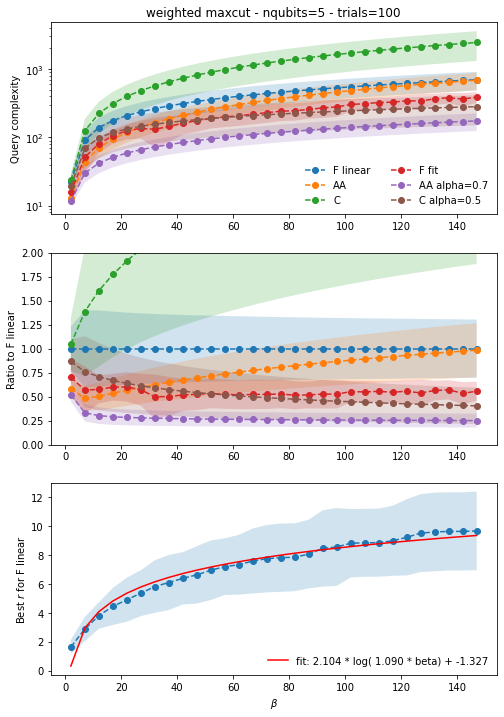

In [28]:
def plot_band(axs, x, cv, std, label=None):
    axs.plot(x, cv, 'o--',label=label)
    axs.fill_between(x, cv-std, cv+std, alpha=0.2)
    
fig, axs = plt.subplots(3, figsize=(8,12))
axs[0].set_title('weighted maxcut - nqubits=%d - trials=%d' % (nqubits, ntrials))
plot_band(axs[0], beta_range, np.mean(qref, axis=1), np.std(qref, axis=1), label='F linear')
plot_band(axs[0], beta_range, np.mean(qampl, axis=1), np.std(qampl, axis=1), label='AA')
plot_band(axs[0], beta_range, np.mean(qc, axis=1), np.std(qc, axis=1), label='C')
plot_band(axs[0], beta_range, np.nanmean(qopt, axis=1), np.nanstd(qopt, axis=1), label='F fit')

plot_band(axs[0], beta_range, np.mean(qampl_alpha, axis=1), np.std(qampl_alpha, axis=1), label=f'AA alpha={alpha_ampl}')
plot_band(axs[0], beta_range, np.mean(qc_alpha, axis=1), np.std(qc_alpha, axis=1), label=f'C alpha={alpha_c}')

axs[0].set_yscale('log')
axs[0].legend(frameon=False, ncol=2)
axs[0].set_ylabel('Query complexity')

plot_band(axs[1], beta_range, np.mean(qref, axis=1)/np.mean(qref, axis=1), np.std(qref, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], beta_range, np.mean(qampl, axis=1)/np.mean(qref, axis=1), np.std(qampl, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], beta_range, np.mean(qc, axis=1)/np.mean(qref, axis=1), np.std(qc, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], beta_range, np.nanmean(qopt, axis=1)/np.mean(qref, axis=1), np.nanstd(qopt, axis=1)/np.mean(qref, axis=1))

plot_band(axs[1], beta_range, np.mean(qampl_alpha, axis=1)/np.mean(qref, axis=1), np.std(qampl_alpha, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], beta_range, np.mean(qc_alpha, axis=1)/np.mean(qref, axis=1), np.std(qc_alpha, axis=1)/np.mean(qref, axis=1))

axs[1].set_ylim([0,2])
axs[2].set_xlabel(r'$\beta$')
axs[1].set_ylabel('Ratio to F linear');

axs[2].set_ylabel('Best $r$ for F linear')
plot_band(axs[2], beta_range, np.mean(bestr, axis=1), np.std(bestr, axis=1))

def func(x, a, b, c):
    return a * np.log(np.abs(b) * x) + c

popt, pcov = curve_fit(func, beta_range, np.mean(bestr, axis=1))
axs[2].plot(beta_range, func(beta_raPnge, *popt), 'r-',
        label='fit: %5.3f * log( %5.3f * beta) + %5.3f' % tuple(popt))
axs[2].legend(loc='lower right', frameon=False)

<ipython-input-115-8a998b648576>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-115-8a998b648576>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-115-8a998b648576>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-115-8a998b648576>:4: Runt

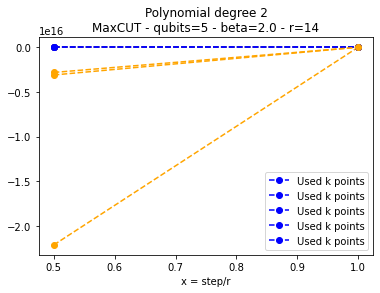

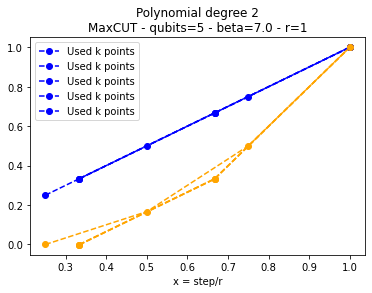

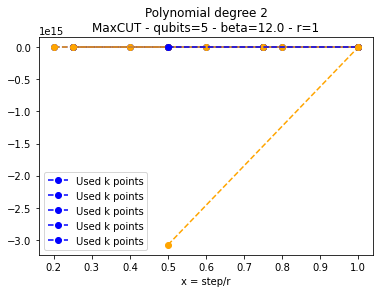

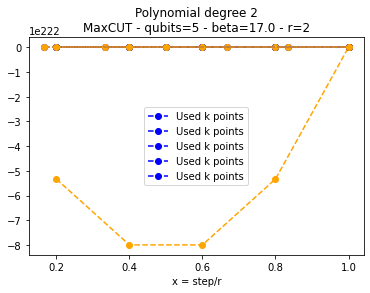

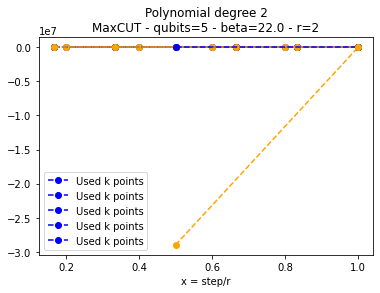

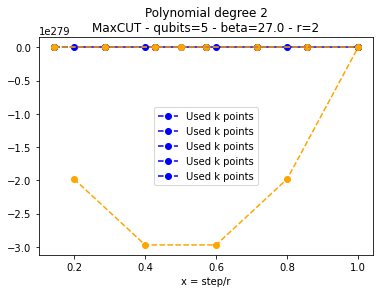

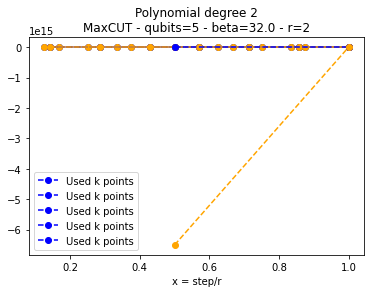

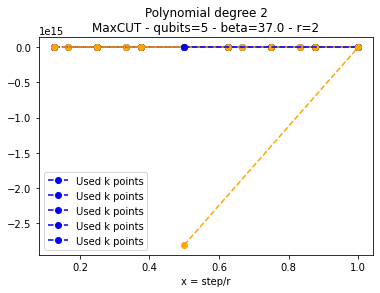

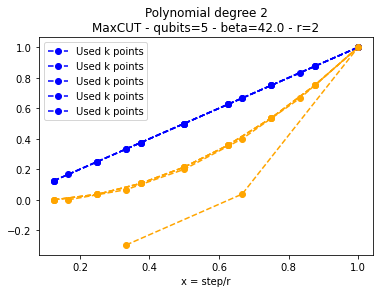

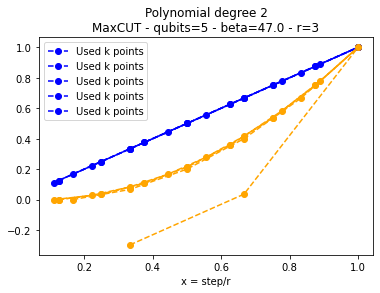

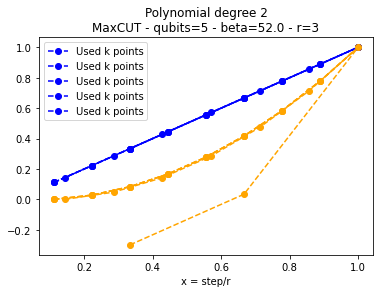

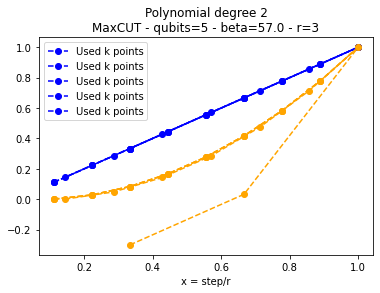

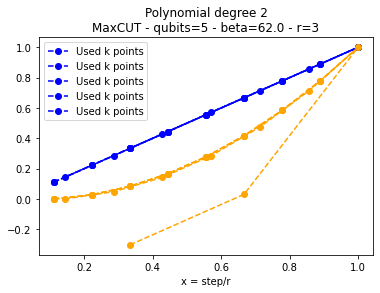

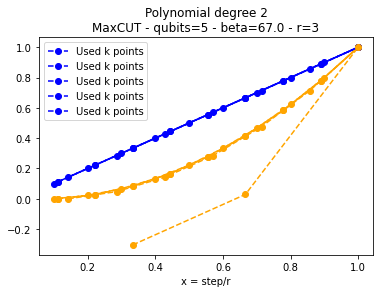

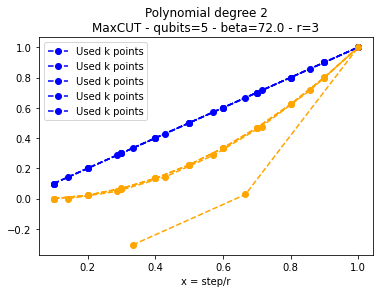

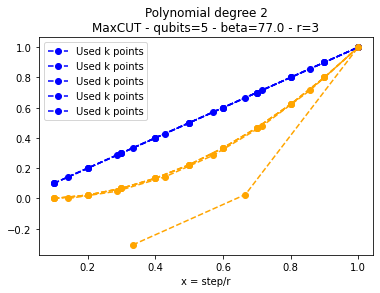

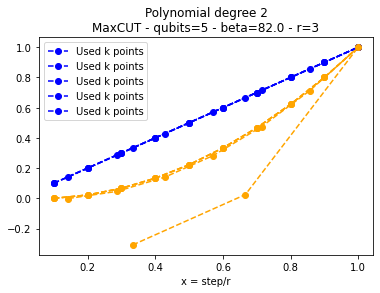

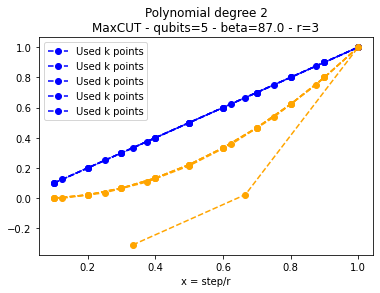

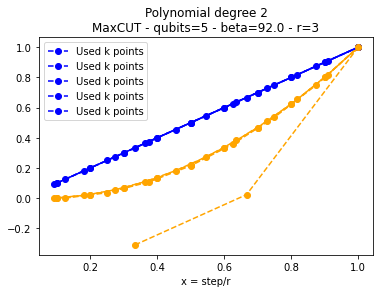

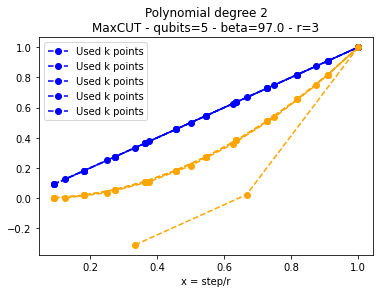

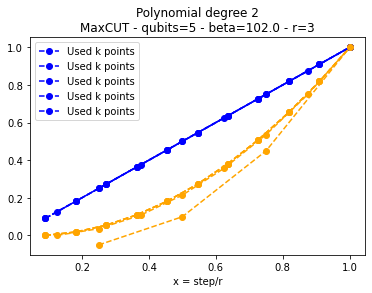

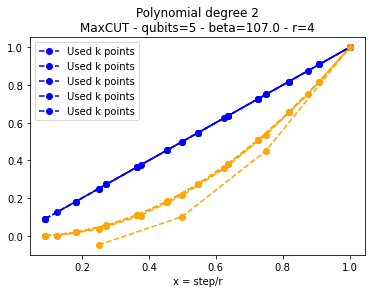

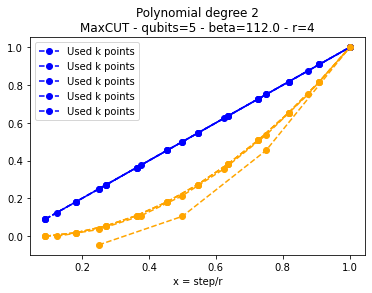

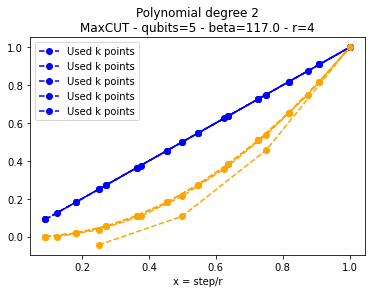

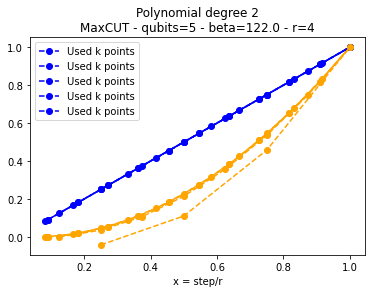

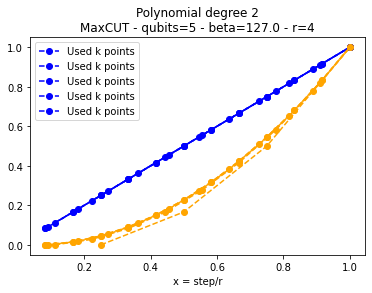

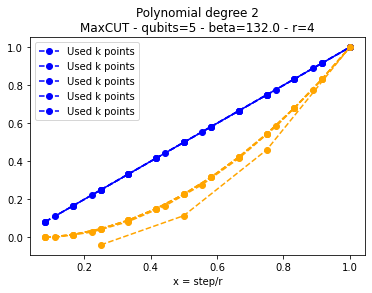

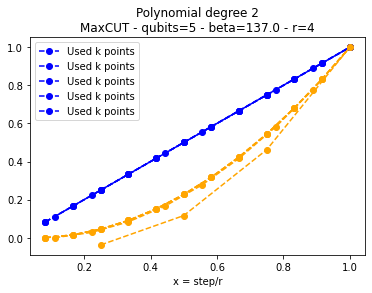

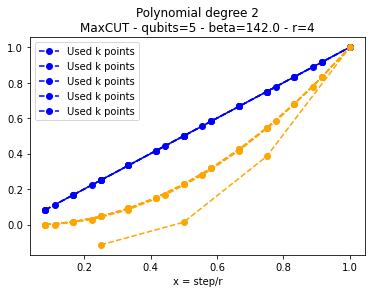

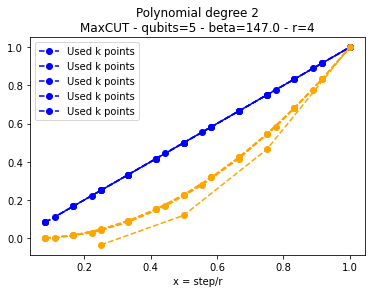

In [115]:
# plot
x = np.linspace(0,1,50)
for ii, beta in enumerate(beta_range):
    plt.figure()
    plt.title('Polynomial degree %d\nMaxCUT - qubits=%d - beta=%.1f - r=%d' % (len(initial_guess)+1,nqubits, beta, r))
    #plt.plot(x, [i for i in x], '--', label=r'$Q(\beta,\epsilon)=%.2f$ (linear)' % reference);
    for jj in range(parameters.shape[1]):
        r = int(bestr[ii][jj])
        xr = np.array(range(1,r+1))/r      
        #plt.plot(x, [myschedule(i, parameters[ii][jj]) for i in x], color='orange');
        plt.plot(xr, xr, 'o--', color='blue', label='Used k points')        
        plt.plot(xr,[myschedule(ixr, parameters[ii][jj]) for ixr in xr], 'o--', color='orange')
    plt.xlabel('x = step/r')
    plt.legend();